# 01 - Several models using lat+lon only

In the beginning, our plan was to get familiar with the data and the many possible models to use throughout the project.

The stores_train and stores_test data included the store's latitude and longitude coordinates. We decided to explore this feature and see if it was important when predicting the revenues and to get started with a submission. First, the location of all stores_train were plottet on a map to see how the provided data was distributed througout Norway. Then, we decided to train different models on a dataset using only the stores' latitudes and longitudes as features. We did not expect any good results but wanted to see if any of the models would perform better than random guessing. It turned out that many of the models performed similarly when trained using only latitude and longitude. Although not very good, they were certainly better than the VeryBadRandomGuesser.



### Load datasets

In [2]:
import pandas as pd

stores_train = pd.read_csv('data/stores_train.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_test = pd.read_csv('data/stores_test.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_extra = pd.read_csv('data/stores_extra.csv', engine="python", error_bad_lines=False, encoding='utf-8')
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv', engine="python", error_bad_lines=False, encoding='utf-8')
busstops_norway = pd.read_csv('data/busstops_norway.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_age_distribution = pd.read_csv('data/grunnkrets_age_distribution.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_households_num_persons = pd.read_csv('data/grunnkrets_households_num_persons.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_income_households = pd.read_csv('data/grunnkrets_income_households.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_norway_stripped = pd.read_csv('data/grunnkrets_norway_stripped.csv', engine="python", error_bad_lines=False, encoding='utf-8')


Skipping line 12465: unexpected end of data


### Data cleaning

In [3]:
# Remove 'year' column from stores since it only has one value
stores_train.drop(['year'], axis=1, inplace=True)
stores_test.drop(['year'], axis=1, inplace=True)
stores_extra.drop(['year'], axis=1, inplace=True)

# Remove all grunkretts from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_norway_stripped.drop(grunnkrets_norway_stripped[grunnkrets_norway_stripped['year'] != 2016].index, inplace=True)
grunnkrets_norway_stripped.drop(['year'], axis=1, inplace=True)

# Remove grunkrett age data from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_age_distribution.drop(grunnkrets_age_distribution[grunnkrets_age_distribution['year'] != 2016].index, inplace=True)
grunnkrets_age_distribution.drop(['year'], axis=1, inplace=True)

# Remove grunkrett household data from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_households_num_persons.drop(grunnkrets_households_num_persons[grunnkrets_households_num_persons['year'] != 2016].index, inplace=True)
grunnkrets_households_num_persons.drop(['year'], axis=1, inplace=True)

# Remove grunkrett income data from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_income_households.drop(grunnkrets_income_households[grunnkrets_income_households['year'] != 2016].index, inplace=True)
grunnkrets_income_households.drop(['year'], axis=1, inplace=True)


### Merging datasets

In [4]:
merged = stores_train.merge(grunnkrets_norway_stripped, how='left', on='grunnkrets_id')
merged = merged.merge(grunnkrets_age_distribution, how='left', on='grunnkrets_id')
merged = merged.merge(grunnkrets_households_num_persons, how='left', on='grunnkrets_id')
merged = merged.merge(grunnkrets_income_households, how='left', on='grunnkrets_id')
merged = merged.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

# Extract relevant features
df_relevant = merged[['lat', 'lon', 'revenue']]

# Remove NaN values (for now)
print('Shape before removing NaN rows:', df_relevant.shape)
df_relevant = df_relevant.dropna()
print('Shape after removing NaN rows: ', df_relevant.shape)

df_relevant

Shape before removing NaN rows: (12859, 3)
Shape after removing NaN rows:  (12859, 3)


lat        lon  revenue
0      59.743104  10.204928   17.998
1      59.913759  10.734031   23.828
2      60.164751  10.254656   16.099
3      67.283669  14.379796    9.296
4      63.358068  10.374832    4.528
...          ...        ...      ...
12854  59.416276  10.480970    0.088
12855  60.799991  10.693635    1.816
12856  59.946562  11.007659   38.225
12857  58.850261   5.735674    3.642
12858  69.670422  19.042659    2.328

[12859 rows x 3 columns]

### Analyzing the Data

#### stores_train missing values and revenue distributions

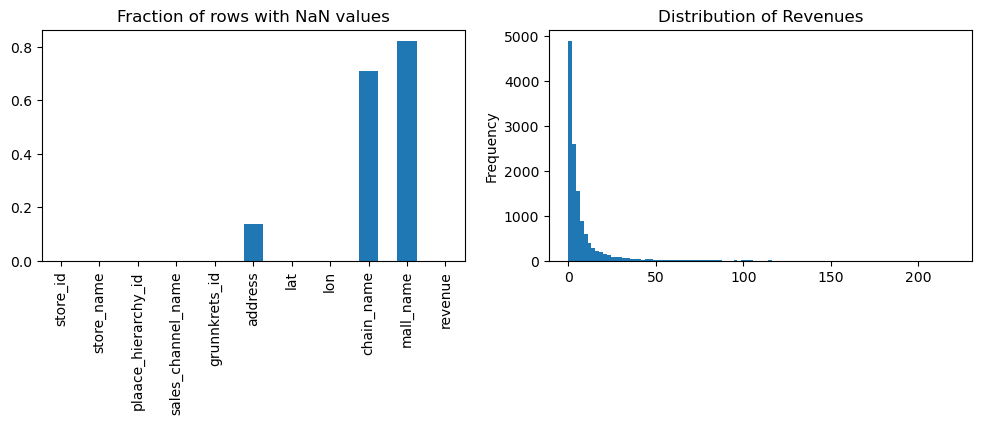

In [5]:
import matplotlib.pyplot as plt 

fig, (ax1, ax2) = plt.subplots(figsize=(12, 3), ncols=2)
stores_train.isna().mean().plot.bar(ax=ax1)
ax1.set_title('Fraction of rows with NaN values')
stores_train.revenue.plot.hist(bins=100, ax=ax2)
ax2.set_title('Distribution of Revenues');

#### stores_train geographcal location

The provided dataset stores_train contains stores from across Norway. However, more stores are found in the denser regions of the country. This is expected.

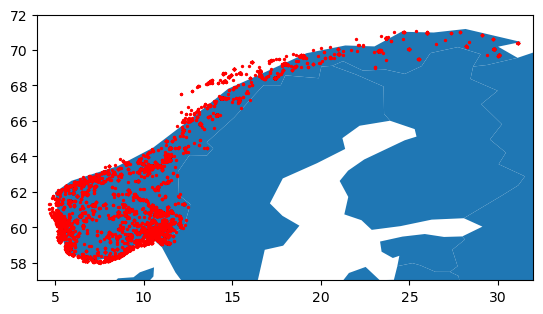

In [6]:
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(df_relevant['lon'], df_relevant['lat'])]
gdf = GeoDataFrame(geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot()
minx, miny, maxx, maxy = 4, 57, 32, 72
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

gdf.plot(ax=ax, marker='o', color='red', markersize=2);

### Divide data into train/test

In [7]:
from sklearn.model_selection import train_test_split, KFold

X, y = df_relevant.drop(['revenue'], axis=1), df_relevant['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Building different models

In [ ]:
import numpy as np 

def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))


#### Decision Tree

In [8]:
from sklearn.tree import DecisionTreeRegressor

# Create and fit a model 
model = DecisionTreeRegressor(
    criterion = 'squared_error',
    max_depth = 5,
    min_samples_split = 4,
    min_samples_leaf = 2,
    random_state=42
)
model.fit(X_train, y_train)

# Generate predictions over the training set
y_train_pred = model.predict(X_train)
print(f'Train set RMSLE: {rmsle(y_train, y_train_pred) :.4f}')

# Generate predictions over the test set
y_test_pred = model.predict(X_test)
print(f'Test set RMSLE: {rmsle(y_test, y_test_pred) :.4f}')

Train set RMSLE: 1.1955
Test set RMSLE: 1.2055


#### Random Forest

In [9]:
from sklearn.ensemble import RandomForestRegressor

# Create and fit a model 
model = RandomForestRegressor(
    n_estimators=50,
    criterion='squared_error',
    max_depth=None,
#     min_samples_split=2,
#     min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)
model.fit(X_train, y_train)

# Generate predictions over the training set
y_train_pred = model.predict(X_train)
print(f'Train set RMSLE: {rmsle(y_train, y_train_pred) :.4f}')

# Generate predictions over the test set
y_test_pred = model.predict(X_test)
print(f'Test set RMSLE: {rmsle(y_test, y_test_pred) :.4f}')

Train set RMSLE: 0.7270
Test set RMSLE: 1.2508


#### AdaBoostRegressor

In [10]:
from sklearn.ensemble import AdaBoostRegressor

# Create and fit a model 
model = AdaBoostRegressor(
    n_estimators=1500,
    learning_rate=0.005,
    loss='square',
    random_state=42
)
model.fit(X_train, y_train)

# Generate predictions over the training set
y_train_pred = model.predict(X_train)
print(f'Train set RMSLE: {rmsle(y_train, y_train_pred) :.4f}')

# Generate predictions over the test set
y_test_pred = model.predict(X_test)
print(f'Test set RMSLE: {rmsle(y_test, y_test_pred) :.4f}')

Train set RMSLE: 1.6889
Test set RMSLE: 1.6840


#### GradientBoostingRegressor

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

# Create and fit a model 
model = model4 = GradientBoostingRegressor(
    learning_rate=0.005,
    n_estimators=2000,
    subsample=1.0, 
    criterion='squared_error', 
    min_samples_split=4, 
    min_samples_leaf=2, 
    min_weight_fraction_leaf=0.0, 
    max_depth=9, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=0, 
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0
)
model.fit(X_train, y_train)

# Generate predictions over the training set
y_train_pred = model.predict(X_train)
print(f'Train set RMSLE: {rmsle(y_train, y_train_pred) :.4f}')

# Generate predictions over the test set
y_test_pred = model.predict(X_test)
print(f'Test set RMSLE: {rmsle(y_test, y_test_pred) :.4f}')

Train set RMSLE: 1.0311
Test set RMSLE: 1.2078


#### LightGBM

In [12]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
    num_leaves=4,
    max_depth=5, 
    random_state=42, 
    metric='squared_error',
    n_jobs=4, 
    n_estimators=1000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)
model.fit(X_train, y_train)

# Generate predictions over the training set
y_train_pred = model.predict(X_train)
print(f'Train set RMSLE: {rmsle(y_train, y_train_pred) :.4f}')

# Generate predictions over the test set
y_test_pred = model.predict(X_test)
print(f'Test set RMSLE: {rmsle(y_test, y_test_pred) :.4f}')

Train set RMSLE: 1.1798
Test set RMSLE: 1.2025


#### XGBoost

In [13]:
import xgboost as xgb
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=7,
    eta=0.1,
    subsample=0.7,
    colsample_bytree=0.8
)
model.fit(X_train, y_train)

# Generate predictions over the training set
y_train_pred = model.predict(X_train)
print(f'Train set RMSLE: {rmsle(y_train, y_train_pred) :.4f}')

# Generate predictions over the test set
y_test_pred = model.predict(X_test)
print(f'Test set RMSLE: {rmsle(y_test, y_test_pred) :.4f}')

Train set RMSLE: 1.0893
Test set RMSLE: 1.1928


#### CatBoostRegressor

In [14]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    thread_count=-1,
    max_depth=6,
    silent=True,
    loss_function='RMSE',
    random_seed=42,
    bagging_temperature=0.3,
    od_type="Iter"
)
model.fit(X_train, y_train)

# Generate predictions over the training set
y_train_pred = model.predict(X_train)
print(f'Train set RMSLE: {rmsle(y_train, y_train_pred) :.4f}')

# Generate predictions over the test set
y_test_pred = model.predict(X_test)
print(f'Test set RMSLE: {rmsle(y_test, y_test_pred) :.4f}')

Train set RMSLE: 1.1201
Test set RMSLE: 1.2081


### Creating a Submission

In [15]:
# Predict on the test set 
X_test = stores_test[['lat', 'lon']] 
y_test_pred = model.predict(X_test)

# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = stores_test.store_id 
submission['predicted'] = np.asarray(y_test_pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('sample_submission.csv', index=False)
submission

id  predicted
0     914206820-914239427-717245   8.736166
1     916789157-916823770-824309   7.411169
2       913341082-977479363-2948   3.884521
3      889682582-889697172-28720  14.197955
4     997991699-998006945-417222   8.480064
...                          ...        ...
8572  917323003-917383529-844309   7.350572
8573  917353379-917411824-845904   3.746443
8574  917072302-917089248-833647   8.508502
8575  916960557-916993161-829908  17.713486
8576   987280891-972040746-45320   8.625533

[8577 rows x 2 columns]

# 02 - h2o AutoML on stores_train with model interpretation

We quickly realized it would be difficult to explore each provided feature individually. Therefore, we tried automating the process by using the AutoML model from the h2o library. At first, this was trained using the raw stores_train dataset. When uploading the result to Kaggle, a score of 0.7552 was achieved. Much better than anything we had tried so far. From this moment forward, we decided to focus on the h2o AutoML model.

The h2o AutoML model includes an explanation method in order to interpret and explain the trianed model. This helped indicate which features were important to include when trianing the model. According to the plots, chain_name, for example, had the highest level of importance.

We also discovered that changing from "RMSE" to "RMSLE" (which is used in Kaggle) error evaluation during training, we automatically improved our score.

In [1]:
# Import and init h2o lib. Running on java
#%pip install h2o
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ------------------------------
H2O_cluster_uptime:         1 min 07 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.1
H2O_cluster_version_age:    1 month and 19 days
H2O_cluster_name:           H2O_from_python_jupyter_mpvowx
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.748 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.7.12 final
--------------------------  ------------------------------

### Load datasets

In [3]:
import pandas as pd

stores_train = pd.read_csv('data/stores_train.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_test = pd.read_csv('data/stores_test.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_extra = pd.read_csv('data/stores_extra.csv', engine="python", error_bad_lines=False, encoding='utf-8')
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv', engine="python", error_bad_lines=False, encoding='utf-8')
busstops_norway = pd.read_csv('data/busstops_norway.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_age_distribution = pd.read_csv('data/grunnkrets_age_distribution.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_households_num_persons = pd.read_csv('data/grunnkrets_households_num_persons.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_income_households = pd.read_csv('data/grunnkrets_income_households.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_norway_stripped = pd.read_csv('data/grunnkrets_norway_stripped.csv', engine="python", error_bad_lines=False, encoding='utf-8')


Skipping line 12465: unexpected end of data


### Building a Model


In [9]:
df = h2o.H2OFrame(stores_train)
df_test = h2o.H2OFrame(stores_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [11]:
# Setting features as factor
catagorical_columns = ['store_name',
                    'plaace_hierarchy_id',
                    'sales_channel_name',
                    'grunnkrets_id',
                    'address',
                    'chain_name',
                    'mall_name']

for column in catagorical_columns:
    if column == 'lv2' or column == 'lv3' or column == 'lv4':
        continue
    df[column] = df[column].asfactor()
    df_test[column] = df_test[column].asfactor()

In [13]:
# Removing labels from train set
y = "revenue"
x = df.columns
x.remove(y)

In [14]:
# Running fit/training on train set with cross validation n=5
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(x = x, y = y, training_frame = df)

AutoML progress: |
09:58:45.148: _train param, Dropping bad and constant columns: [store_id, year_store]

███
09:59:10.584: _train param, Dropping bad and constant columns: [store_id, year_store]

███████
09:59:52.760: GLM_1_AutoML_1_20221027_95844 [GLM def_1] failed: DistributedException from /127.0.0.1:54321: 'Java heap space', caused by java.lang.OutOfMemoryError: Java heap space
09:59:52.814: _train param, Dropping bad and constant columns: [store_id, year_store]

█
10:00:17.324: _train param, Dropping bad and constant columns: [store_id, year_store]

█
10:00:32.28: _train param, Dropping bad and constant columns: [store_id, year_store]

██
10:02:32.779: _train param, Dropping bad and constant columns: [store_id, year_store]


10:02:39.516: _train param, Dropping bad and constant columns: [store_id, year_store]

█
10:02:47.216: _train param, Dropping bad and constant columns: [store_id, year_store]

██
10:02:57.38: _train param, Dropping bad and constant columns: [store_id, year_st

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_1_20221027_95844

No summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 50.18365159046586
RMSE: 7.0840420375987225
MAE: 3.6607914569763484
RMSLE: 0.6954767413280257
Mean Residual Deviance: 50.18365159046586
R^2: 0.7898025672324753
Null degrees of freedom: 10049
Residual degrees of freedom: 10042
Null deviance: 2399392.104804436
Residual deviance: 504345.69848418183
AIC: 67891.34206410615

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 94.3373847733934
RMSE: 9.712743421577315
MAE: 4.70831823638652
RMSLE: 0.7971690637855409
Mean Residual Deviance: 94.3373847733934
R^2: 0.6010054084809966
Null degrees of freedom: 12858
Residual degrees of freedom: 12849
Null deviance: 3041468.731421414
Residual deviance: 1213084.4308010656
AIC: 94982.55969188576

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
mae                     4.73927   0.175485   4.77574       4.47998       4.80526       4.95546       4.6799
mean_residual_deviance  93.8985   15.2586    85.4172       72.3541       99.0109       111.775       100.935
mse                     93.8985   15.2586    85.4172       72.3541       99.0109       111.775       100.935
null_deviance           608294    101894     676271        468779        578255        734524        583640
r2                      0.600475  0.0440557  0.668838      0.599965      0.551041      0.606702      0.575829
residual_deviance       241269    38273.4    223793        186963        259607        288490        247494
rmse                    9.66354   0.801906   9.24215       8.50612       9.95042       10.5724       10.0467
rmsle                   0.80509   0.016304   0.786153      0.820019      0.823326      0.802873      0.793077

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [15]:
lb = aml.leaderboard
# Showing best perforimg models
lb.head()

model_id                                                    rmse       mse      mae       rmsle    mean_residual_deviance
------------------------------------------------------  --------  --------  -------  ----------  ------------------------
StackedEnsemble_AllModels_1_AutoML_1_20221027_95844      9.71274   94.3374  4.70832    0.797169                   94.3374
StackedEnsemble_BestOfFamily_1_AutoML_1_20221027_95844   9.7363    94.7956  4.72162    0.798923                   94.7956
GBM_2_AutoML_1_20221027_95844                            9.82496   96.5298  4.72827  nan                          96.5298
GBM_5_AutoML_1_20221027_95844                            9.83075   96.6436  4.73145  nan                          96.6436
GBM_1_AutoML_1_20221027_95844                            9.84717   96.9668  4.77022  nan                          96.9668
GBM_3_AutoML_1_20221027_95844                            9.89966   98.0033  4.73548  nan                          98.0033
GBM_4_AutoML_1_20221027_95844                            9.93679   98.7398  4.74458  nan                          98.7398
DRF_1_AutoML_1_20221027_95844                            9.94869   98.9765  4.64568    0.772097                   98.9765
XGBoost_2_AutoML_1_20221027_95844                       10.0828   101.664   4.95278  nan                         101.664
XGBoost_3_AutoML_1_20221027_95844                       10.1607   103.239   5.02426  nan                         103.239
[10 rows x 6 columns]

### Creating a Submission

In [36]:
# Predict on the test set
#preds = aml.predict(df_test)
preds = aml.get_best_model(algorithm="drf").predict(df_test)
preds = h2o.as_list(preds)

# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = stores_test.store_id 
submission['predicted'] = np.asarray(preds)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('sample_submission.csv', index=False)
submission

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


id  predicted
0     914206820-914239427-717245   3.981299
1     916789157-916823770-824309   6.583038
2       913341082-977479363-2948   5.452482
3      889682582-889697172-28720   6.138083
4     997991699-998006945-417222  18.329472
...                          ...        ...
8572  917323003-917383529-844309  11.179706
8573  917353379-917411824-845904   5.040914
8574  917072302-917089248-833647   9.946639
8575  916960557-916993161-829908   4.263184
8576   987280891-972040746-45320   4.643659

[8577 rows x 2 columns]

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                   rmse      mse      mae       rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
------------------------------------------------------  -------  -------  -------  ----------  ------------------------  ------------------  -------------------------  ---------------
DRF_1_AutoML_1_20221027_95844                           4.13678  17.1129  2.1684     0.47213                    17.1129               20979                   0.031118  DRF
GBM_4_AutoML_1_20221027_95844                           5.72324  32.7555  2.94511    0.636371                   32.7555                1581                   0.026166  GBM
StackedEnsemble_BestOfFamily_1_AutoML_1_20221027_95844  6.30324  39.7308  3.40806    0.679519                   39.7308                2575                   0.044056  StackedEnsemble
GBM_3_AutoML_1_20221027_95844                           6.43588  41.4206  3.30916    0.679185                   41.4206                1199                   0.015423  GBM
GBM_5_AutoML_1_20221027_95844                           6.68342  44.6681  3.54502    0.704818                   44.6681                 937                   0.014261  GBM
StackedEnsemble_AllModels_1_AutoML_1_20221027_95844     6.95302  48.3445  3.62974    0.693518                   48.3445                3046                   0.109513  StackedEnsemble
GBM_2_AutoML_1_20221027_95844                           7.01813  49.2541  3.56075    0.706418                   49.2541                 966                   0.012839  GBM
XGBoost_2_AutoML_1_20221027_95844                       7.93921  63.0311  4.28838  nan                          63.0311                2568                   0.003016  XGBoost
XGBoost_1_AutoML_1_20221027_95844                       8.05903  64.9479  4.23271  nan                          64.9479                3490                   0.00458   XGBoost
GBM_1_AutoML_1_20221027_95844                           8.25517  68.1479  3.72631  nan                          68.1479                2279                   0.02181   GBM
XGBoost_3_AutoML_1_20221027_95844                       8.47471  71.8208  4.5461   nan                          71.8208                1858                   0.002206  XGBoost
XRT_1_AutoML_1_20221027_95844                           8.85396  78.3926  4.73306    0.8256                     78.3926               14837                   0.031554  DRF
[12 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

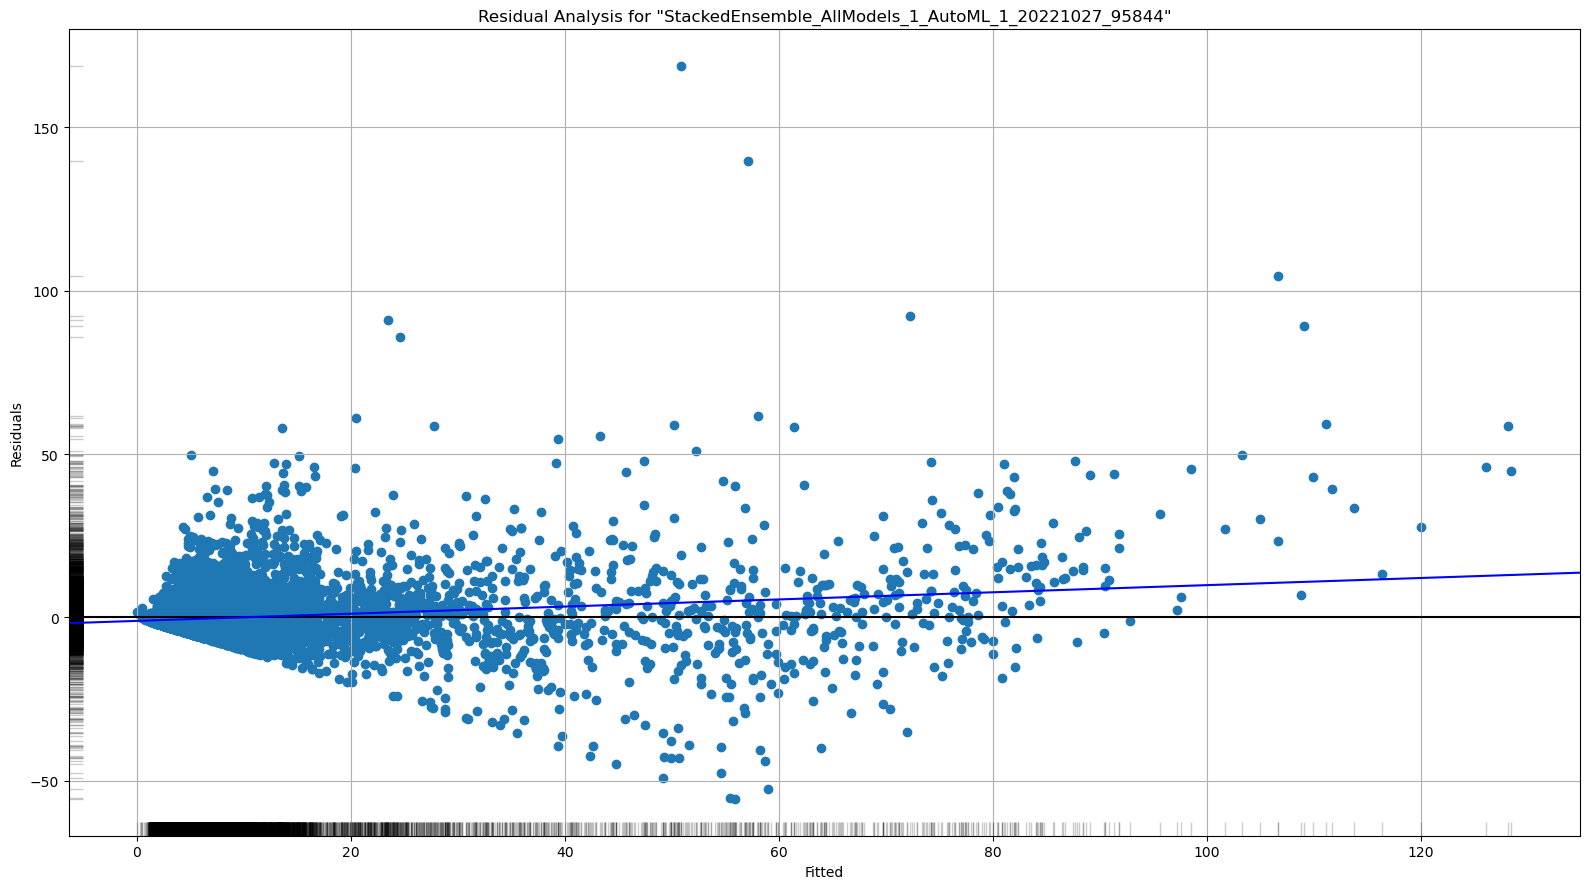

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

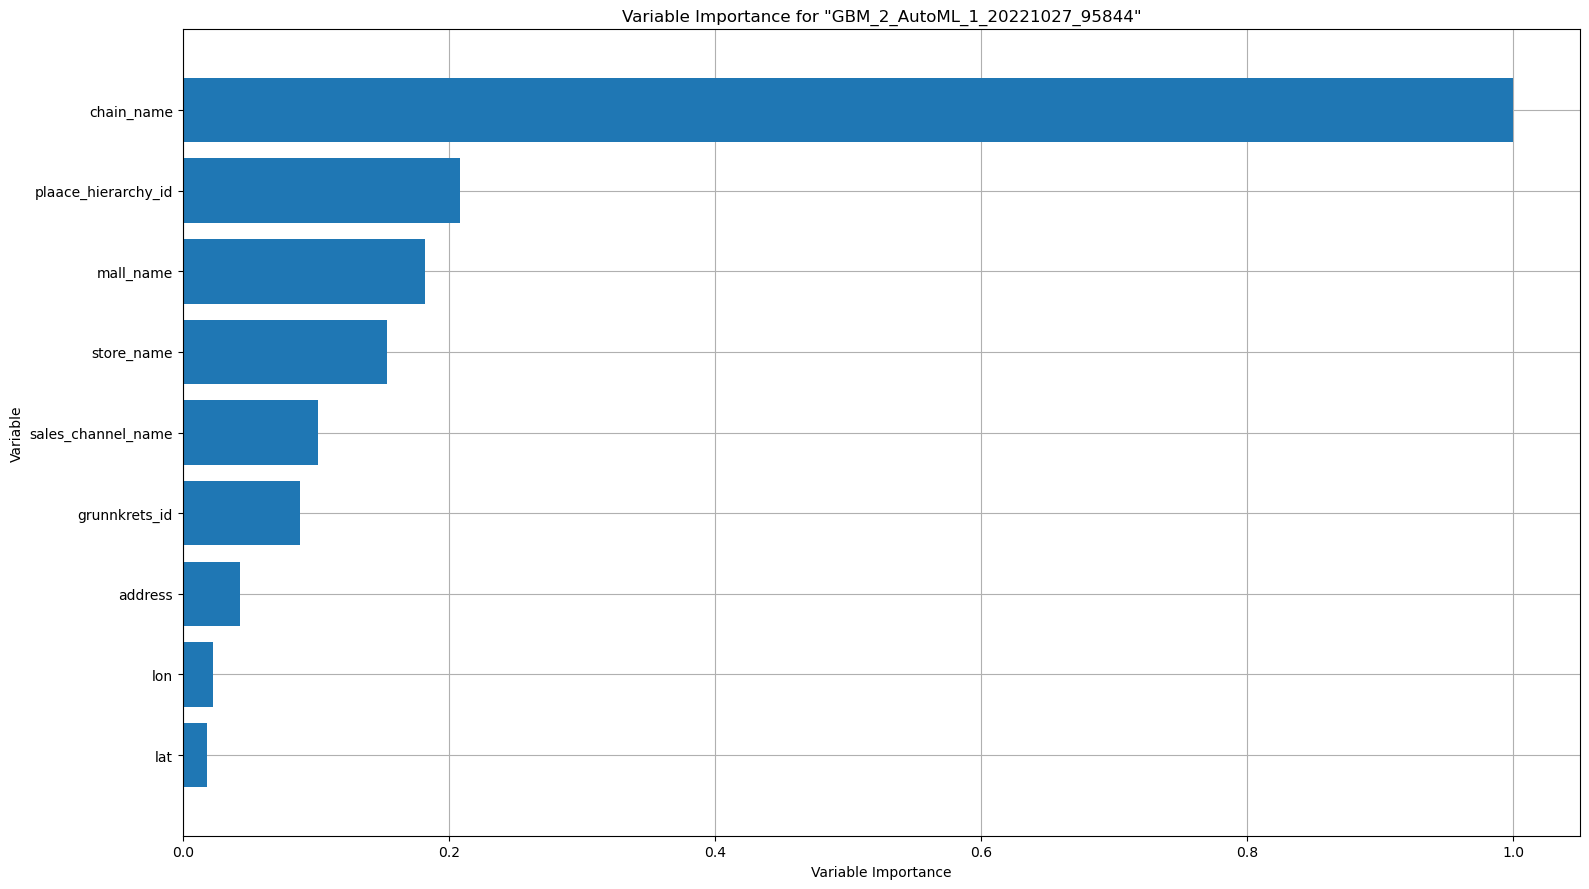

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

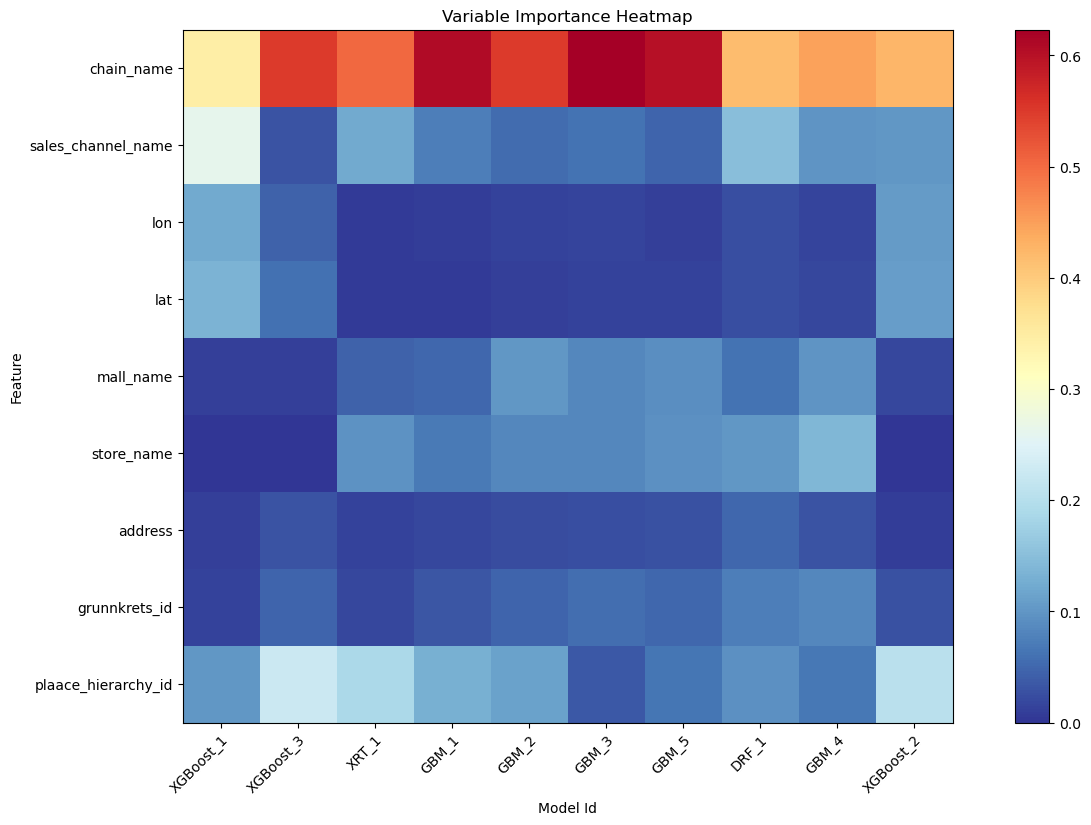

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

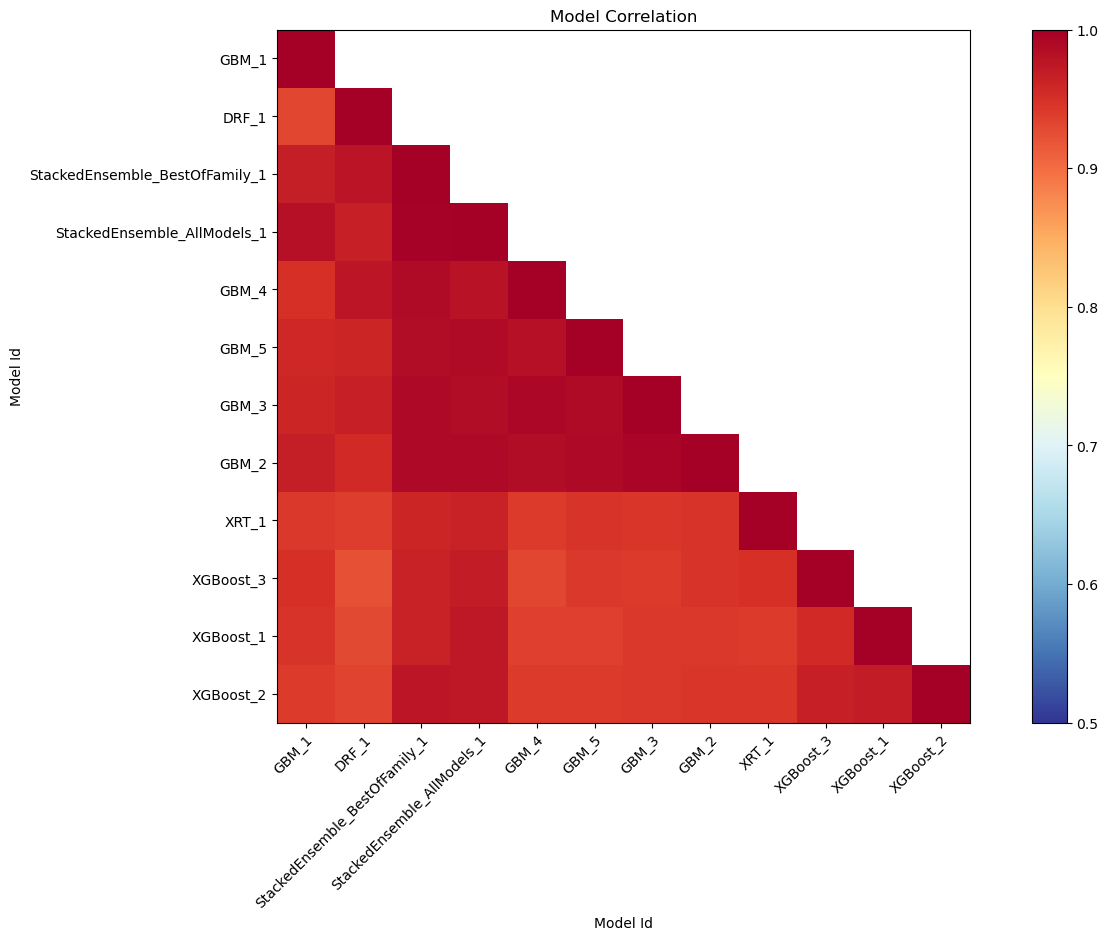

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

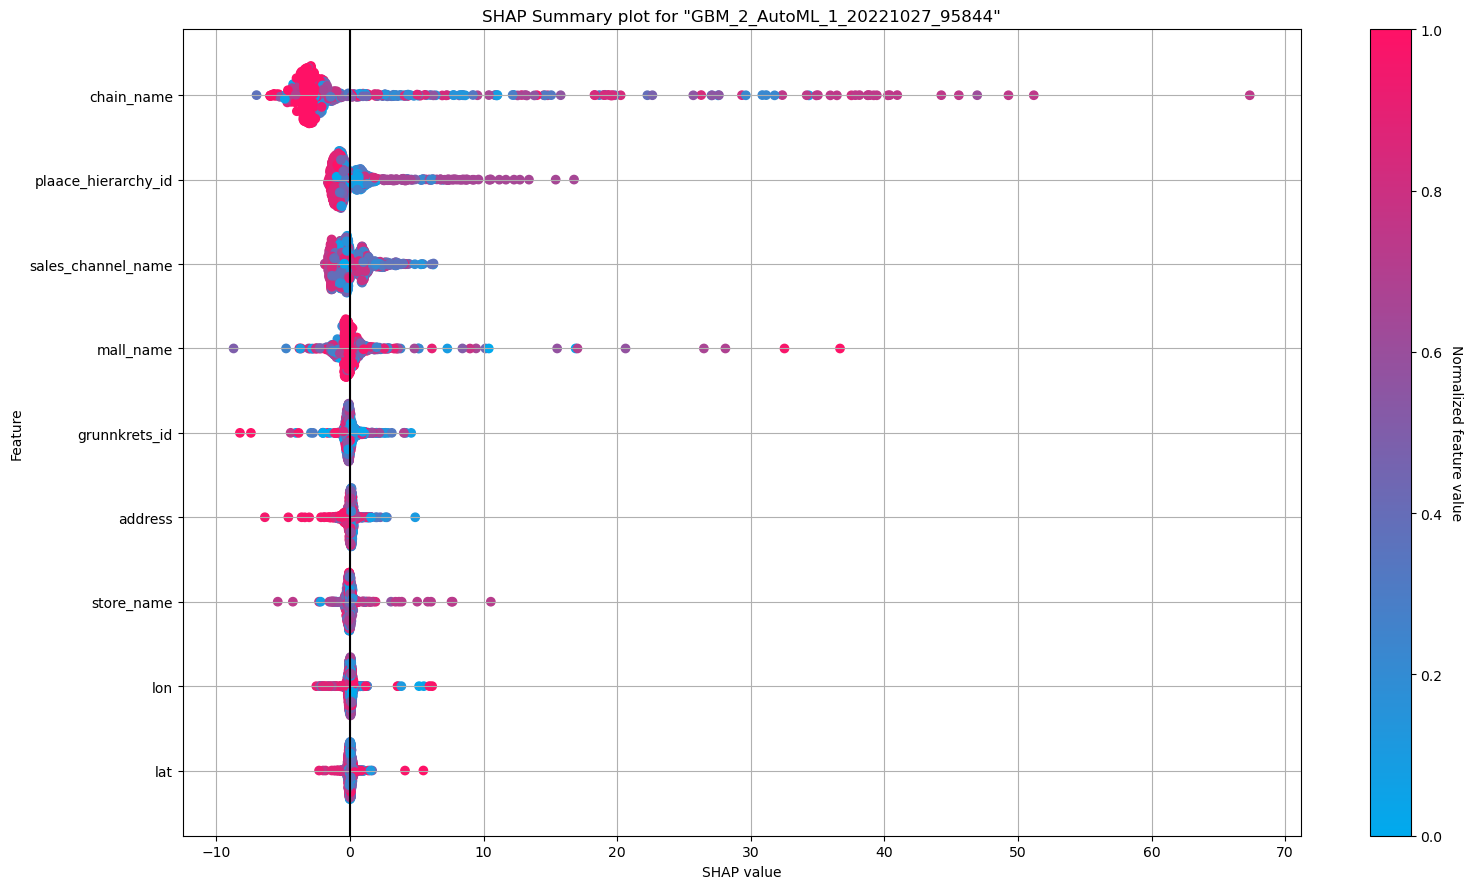

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

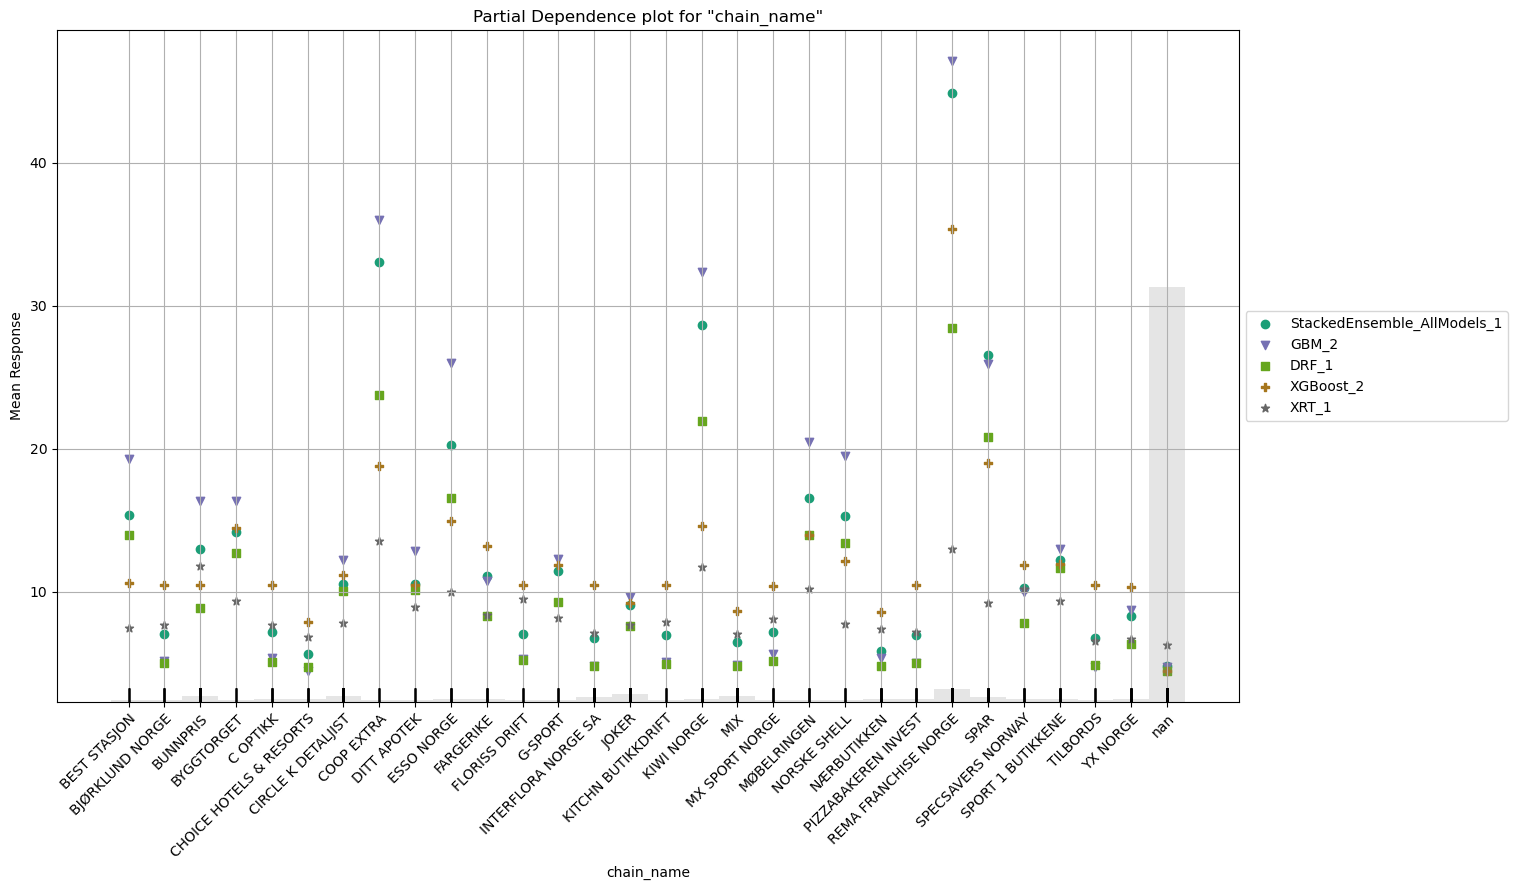

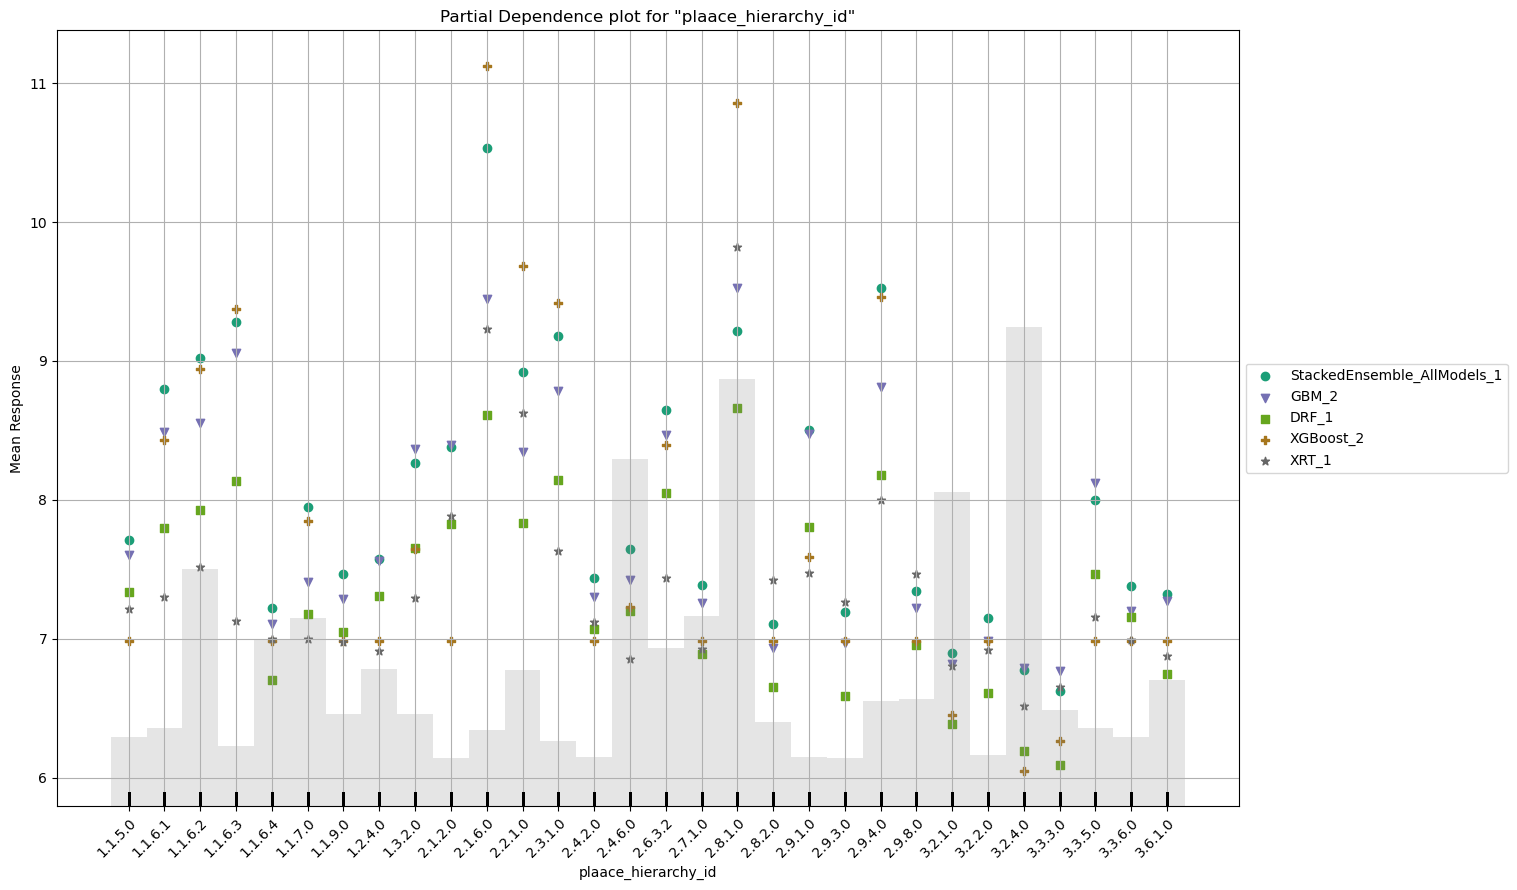

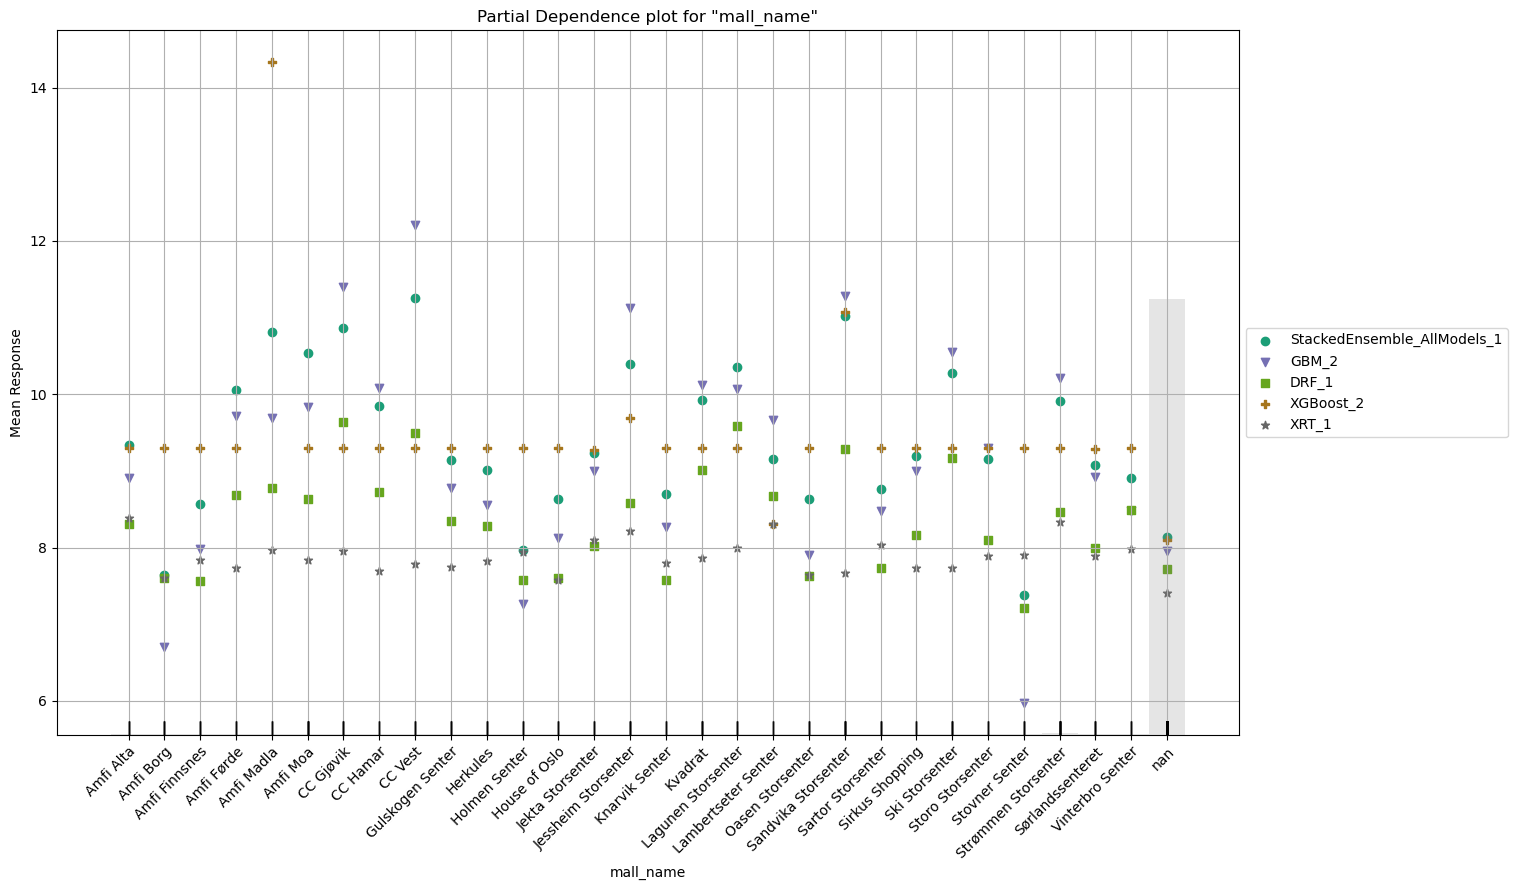

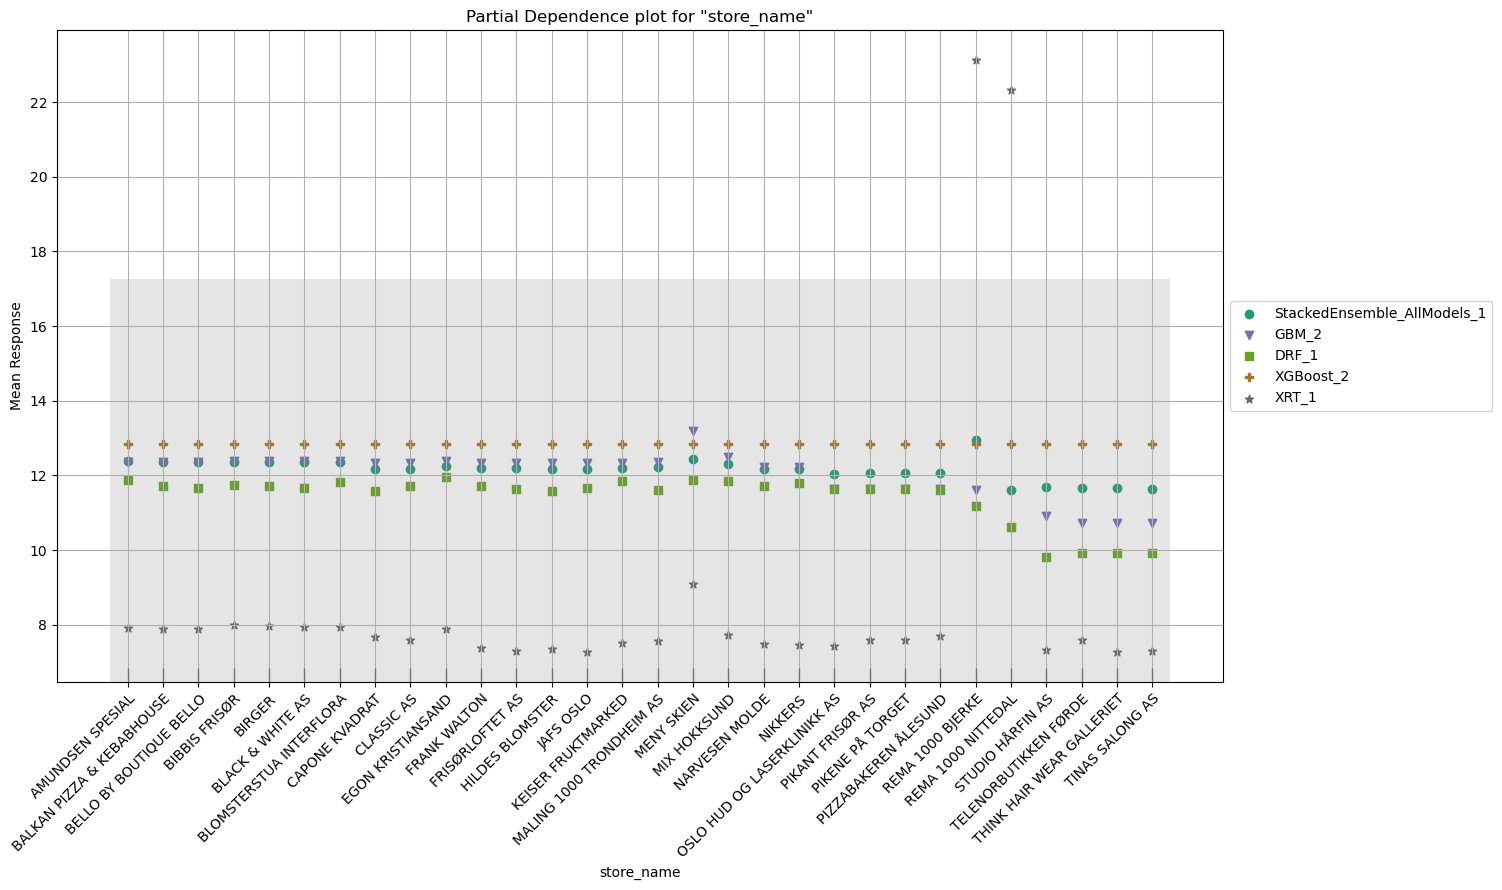

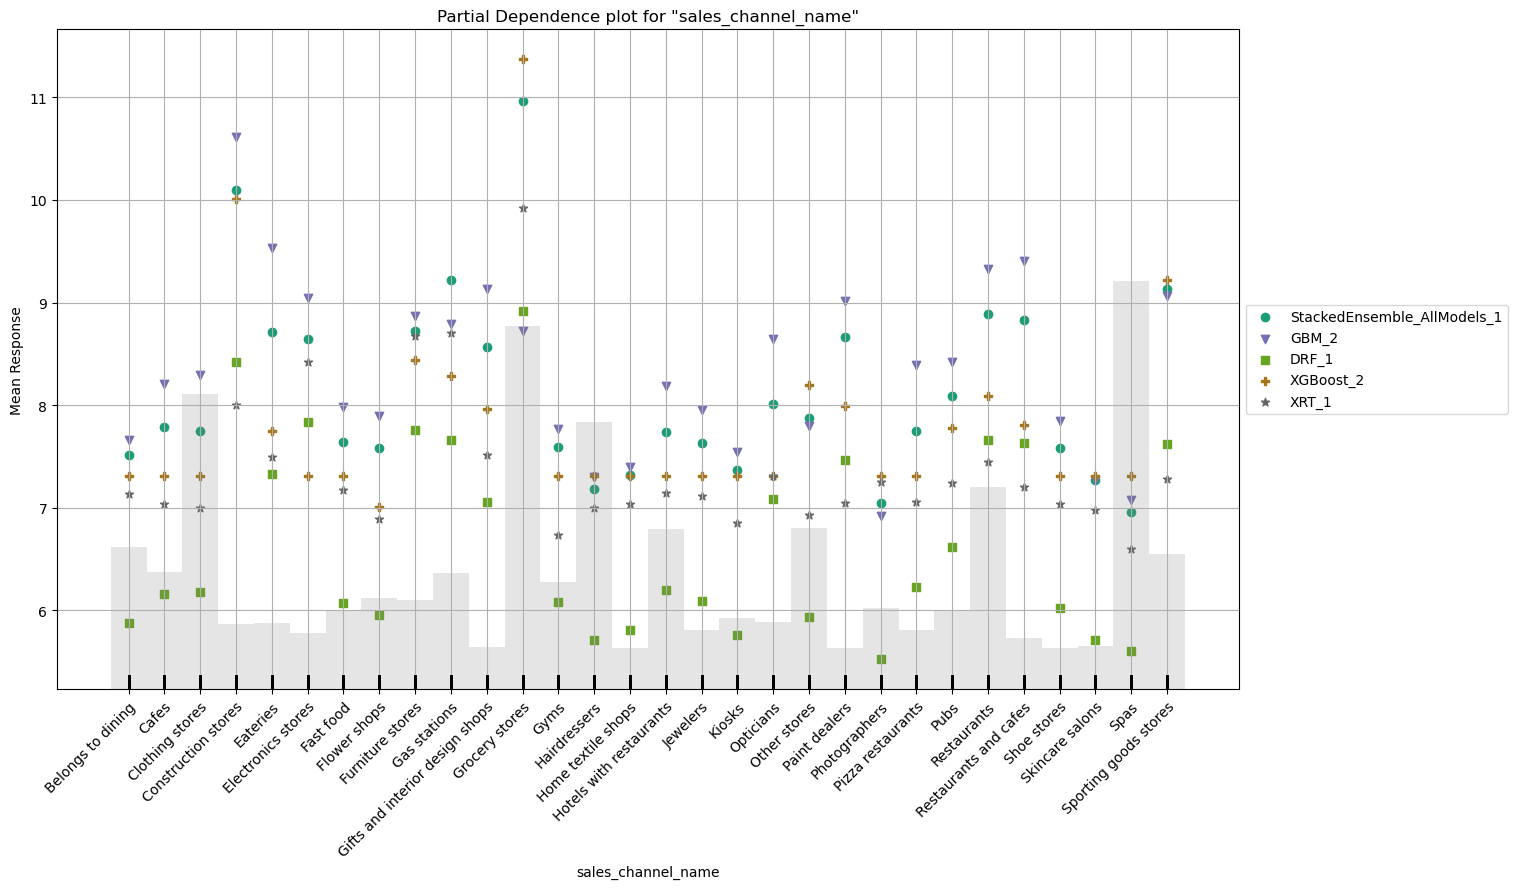

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

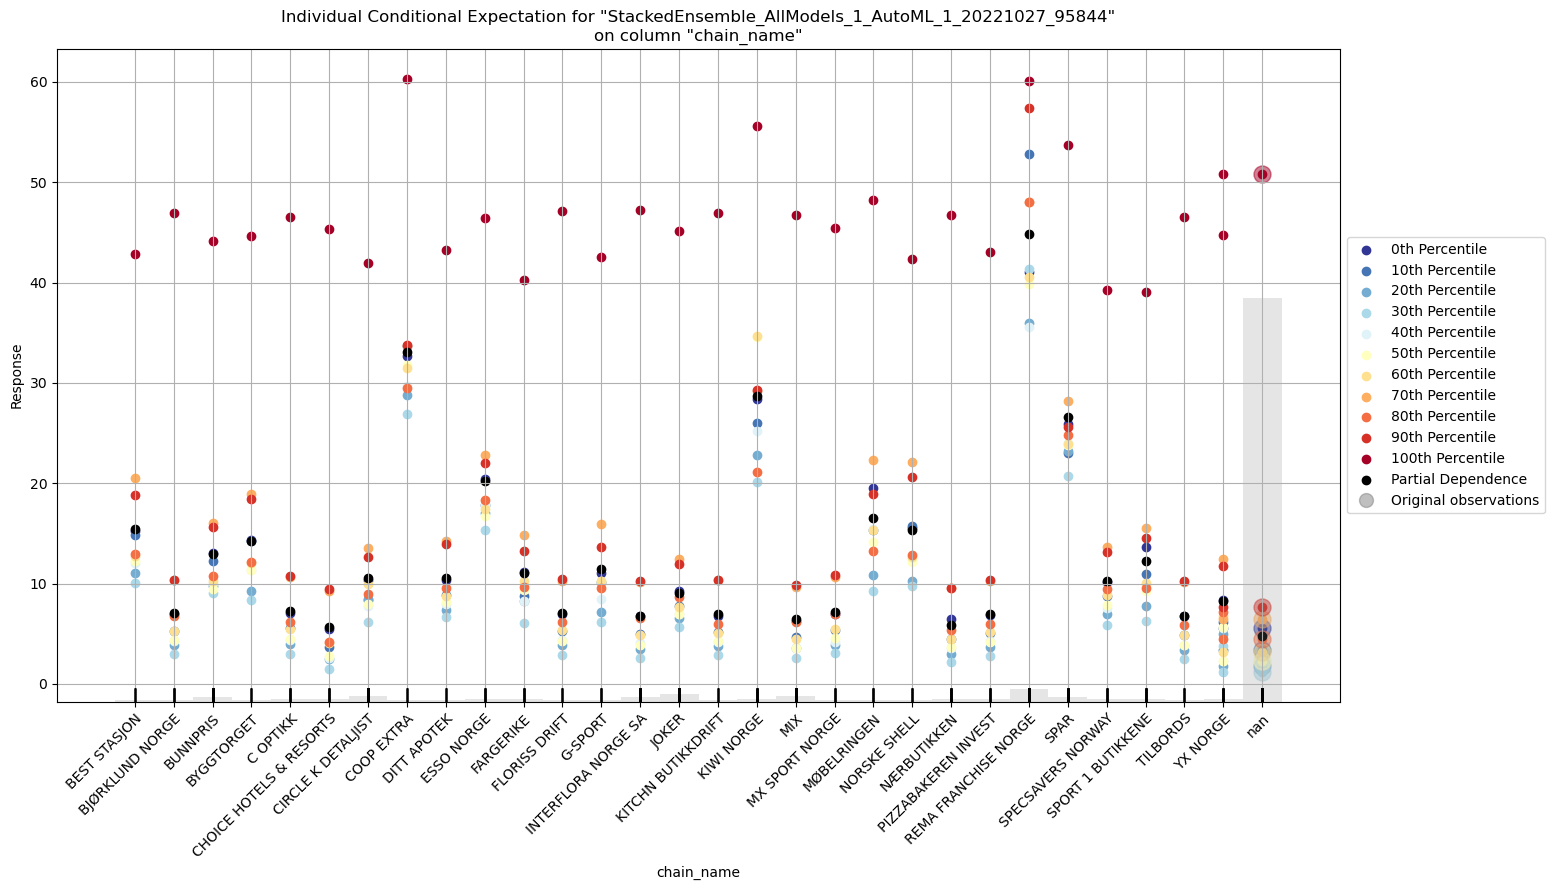

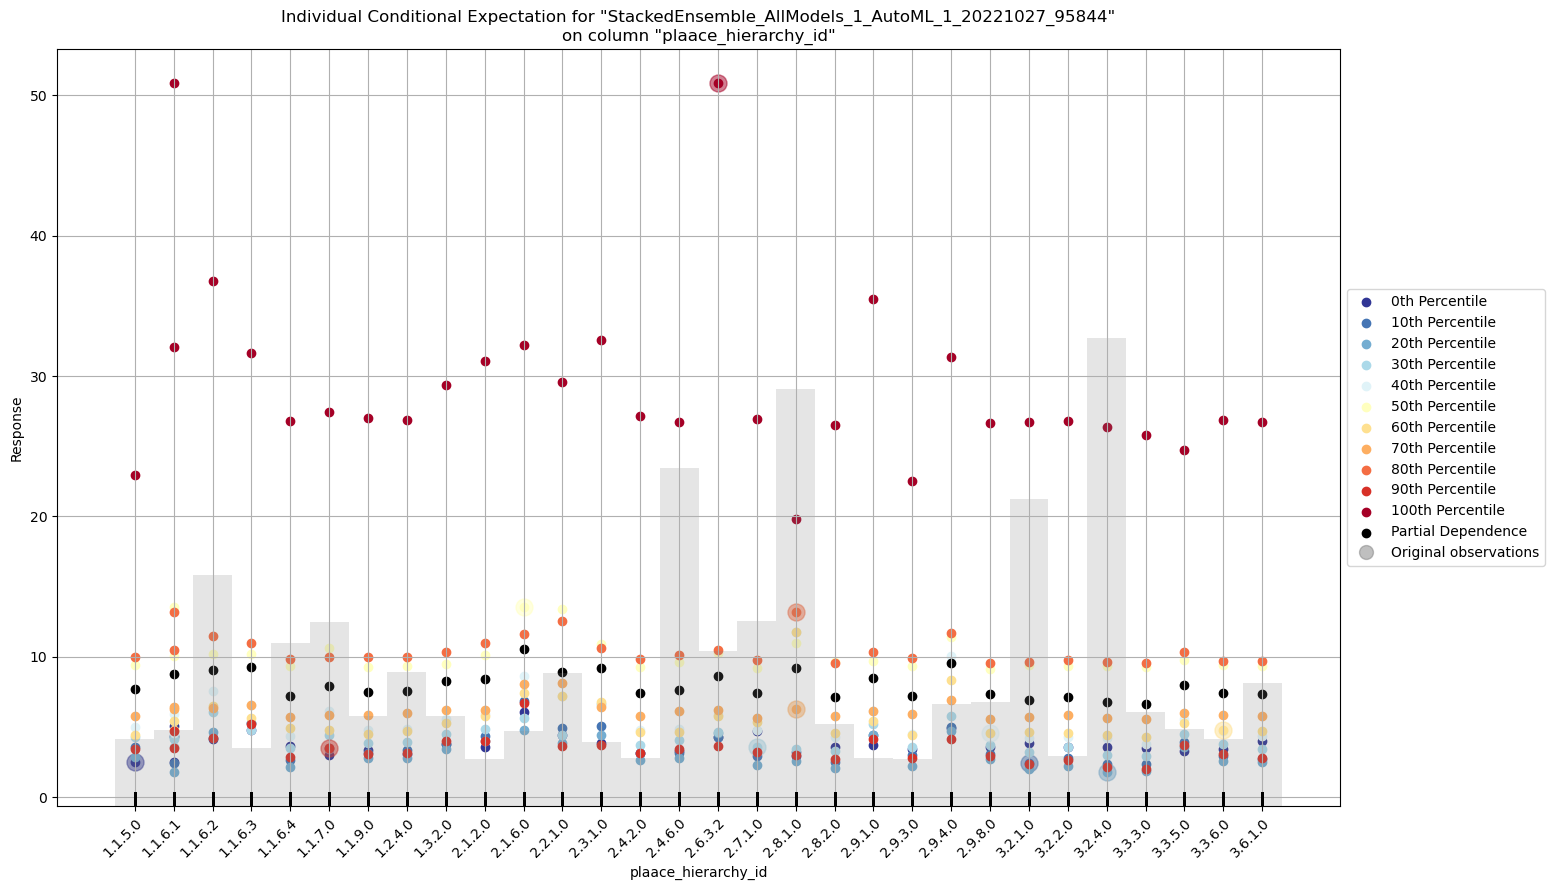

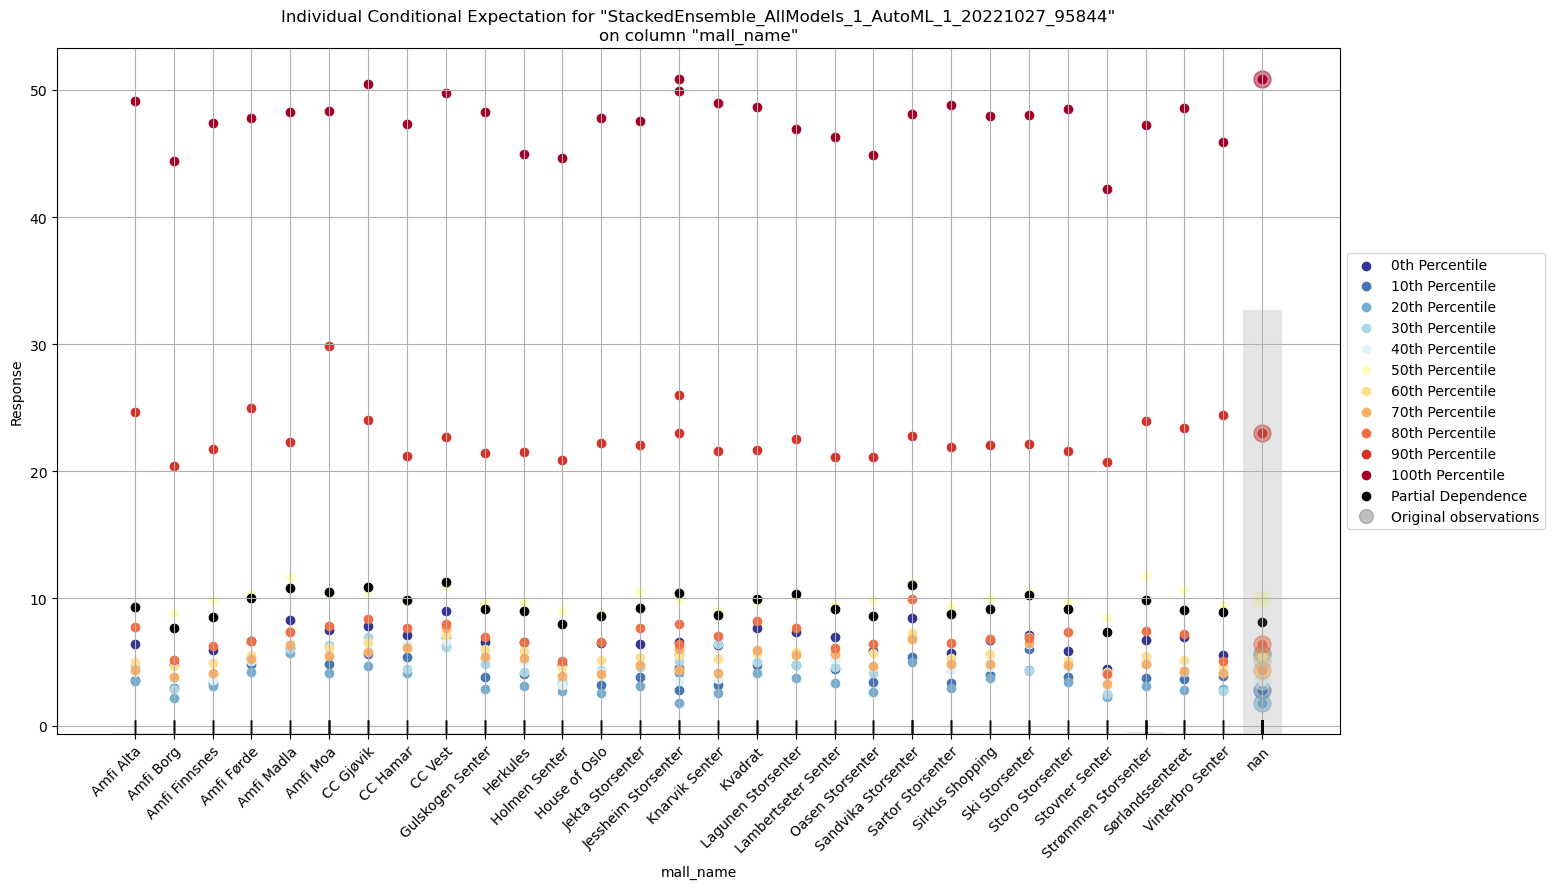

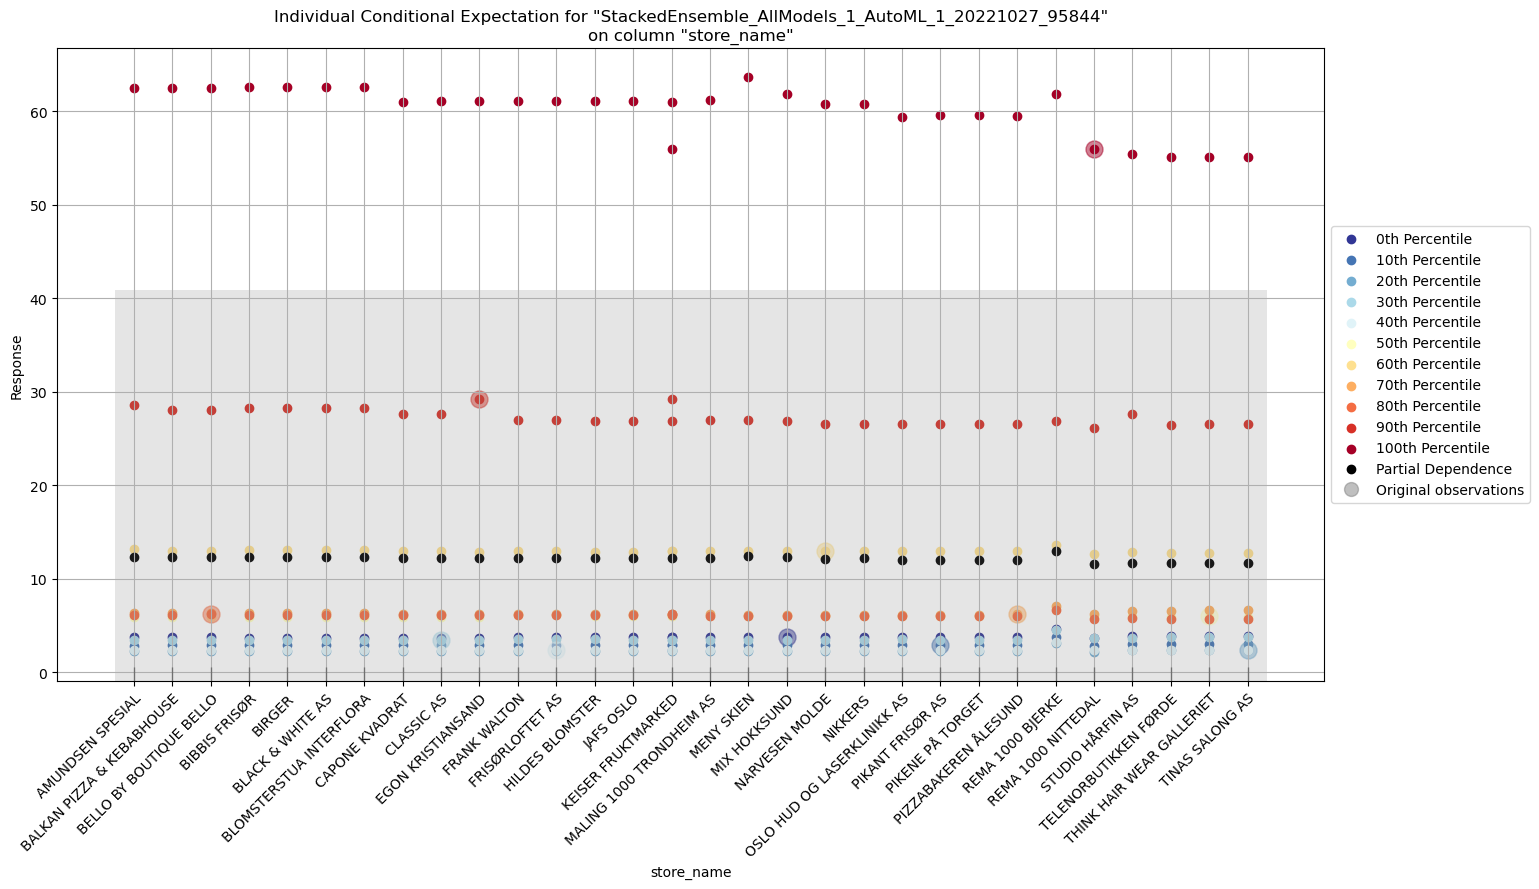

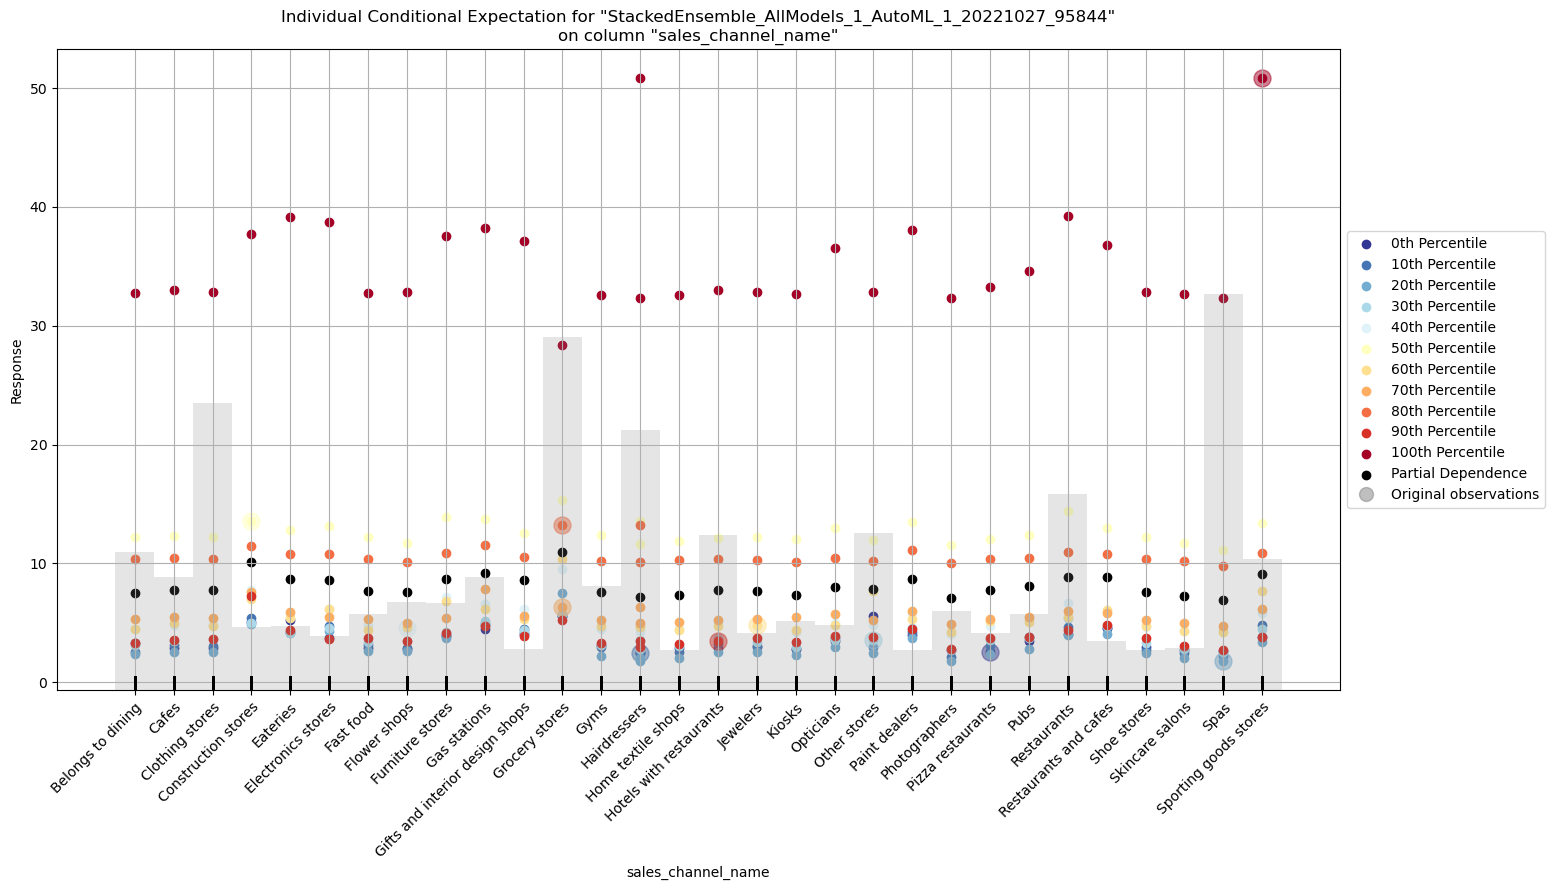

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                   rmse      mse      mae       rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
------------------------------------------------------  -------  -------  -------  ----------  ------------------------  ------------------  -------------------------  ---------------
DRF_1_AutoML_1_20221027_95844                           4.13678  17.1129  2.1684     0.47213                    17.1129               20979                   0.031118  DRF
GBM_4_AutoML_1_20221027_95844                           5.72324  32.7555  2.94511    0.636371                   32.7555                1581                   0.026166  GBM
StackedEnsemble_BestOfFamily_1_AutoML_1_20221027_95844  6.30324  39.7308  3.40806    0.679519                   39.7308                2575                   0.044056  StackedEnsemble
GBM_3_AutoML_1_20221027_95844                           6.43588  41.4206  3.30916    0.679185                   41.4206                1199                   0.015423  GBM
GBM_5_AutoML_1_20221027_95844                           6.68342  44.6681  3.54502    0.704818                   44.6681                 937                   0.014261  GBM
StackedEnsemble_AllModels_1_AutoML_1_20221027_95844     6.95302  48.3445  3.62974    0.693518                   48.3445                3046                   0.109513  StackedEnsemble
GBM_2_AutoML_1_20221027_95844                           7.01813  49.2541  3.56075    0.706418                   49.2541                 966                   0.012839  GBM
XGBoost_2_AutoML_1_20221027_95844                       7.93921  63.0311  4.28838  nan                          63.0311                2568                   0.003016  XGBoost
XGBoost_1_AutoML_1_20221027_95844                       8.05903  64.9479  4.23271  nan                          64.9479                3490                   0.00458   XGBoost
GBM_1_AutoML_1_20221027_95844                           8.25517  68.1479  3.72631  nan                          68.1479                2279                   0.02181   GBM
XGBoost_3_AutoML_1_20221027_95844                       8.47471  71.8208  4.5461   nan                          71.8208                1858                   0.002206  XGBoost
XRT_1_AutoML_1_20221027_95844                           8.85396  78.3926  4.73306    0.8256                     78.3926               14837                   0.031554  DRF
[12 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [21]:
aml.explain(df)

# 05 - h2o AutoML on all features engineered

Now that h2o AutoML on the raw stores_train data proved very successful, it was interesting to explore whether adding more features to the training data would improve the result. In this part, we tried merging all the datasets together (apart from busstops) in order to create the ultimate training data set. 

Exploratory Data Analysis was also a part of this process, where we did the following:
- Manually interpret the data by looking at the types of data and features
- Look for missing data
- Feature correlations between each feature and the target (revenue)
- Looked at the graphs and visualizations given from the "aml.explain" function


Merging this many datasets resulted in over 100 different features, and to reduce the curse of dimensionality and the required training time, the feature space was reduced and modified through **feature engineering**:
- Some of the missing data was replaced by using imputation through "IterativeImputer" with the estimator RandomForestRegressor.
- Reduce household age feature space
- Modify stores data by replacing nan values in chain_name and mall_name with categorical ones
- Aggregate ages and separate couples and singles into individual column


Unfortunately, the resulting score turned out worse than when training on the raw store_train dataset. 

In [3]:
# Import and init h2o lib. Running on java
#%pip install h2o
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ------------------------------
H2O_cluster_uptime:         05 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.1
H2O_cluster_version_age:    1 month and 19 days
H2O_cluster_name:           H2O_from_python_jupyter_mpvowx
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.748 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.7.12 final
--------------------------  ------------------------------

### Load datasets

In [ ]:
import pandas as pd

stores_train = pd.read_csv('data/stores_train.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_test = pd.read_csv('data/stores_test.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_extra = pd.read_csv('data/stores_extra.csv', engine="python", error_bad_lines=False, encoding='utf-8')
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv', engine="python", error_bad_lines=False, encoding='utf-8')
busstops_norway = pd.read_csv('data/busstops_norway.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_age_distribution = pd.read_csv('data/grunnkrets_age_distribution.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_households_num_persons = pd.read_csv('data/grunnkrets_households_num_persons.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_income_households = pd.read_csv('data/grunnkrets_income_households.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_norway_stripped = pd.read_csv('data/grunnkrets_norway_stripped.csv', engine="python", error_bad_lines=False, encoding='utf-8')


### Feature engineering

#### Impute missing data

In [ ]:
import missingno
import numpy as np

grunnkrets_household_income_nan = grunnkrets_income_households.replace(0, np.nan)
grunnkrets_household_income_nan.head()
missingno.bar(grunnkrets_household_income_nan)
grunnkrets_household_income_nan.isnull().sum()

In [ ]:
# https://stackoverflow.com/questions/63608624/how-to-impute-missing-values-for-multiple-columns-using-a-regressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp_mean = IterativeImputer(estimator=RandomForestRegressor(), random_state=0, max_iter=10)
imp_mean.fit(grunnkrets_household_income_nan)
grunnkrets_household_income_imputed = pd.DataFrame(imp_mean.transform(grunnkrets_household_income_nan), columns=grunnkrets_income_households.columns)

# grunnkrets_household_income_imputed.to_csv('data/grunnkrets_household_income_imputed.csv', index=False)
grunnkrets_household_income_imputed.head()

#### Reduce household age feature space

In [ ]:
grunnkrets_age_distribution['children_age_distribution'] =  grunnkrets_age_distribution.iloc[:,2:8].sum(axis=1)
grunnkrets_age_distribution['teenagers_age_distribution'] =  grunnkrets_age_distribution.iloc[:,8:20].sum(axis=1)
grunnkrets_age_distribution['adults_age_distribution'] =  grunnkrets_age_distribution.iloc[:,20:].sum(axis=1)

grunnkrets_age_distribution_transformed = grunnkrets_age_distribution.loc[:, ["grunnkrets_id", "children_age_distribution", "teenagers_age_distribution", "adults_age_distribution"]]
grunnkrets_age_distribution_transformed.head()

#### Modify stores_train data by replacing nan values in chain_name and mall_name with categorical ones

In [ ]:
# display(stores_train.isnull().sum())
stores_train['mall_name'].fillna('no mall', inplace=True)
stores_train['chain_name'].fillna('no chain', inplace=True)

stores_test['mall_name'].fillna('no mall', inplace=True)
stores_test['chain_name'].fillna('no chain', inplace=True)
# stores_train_transformed = stores_extra.drop('year', axis=1) # all 2016
# stores_train_transformed.head()

#### Modify stores_extra data by replacing nan values in chain_name and mall_name with categorical ones

In [ ]:
# display(stores_train.isnull().sum())
stores_extra['mall_name'].fillna('no mall', inplace=True)
stores_extra['chain_name'].fillna('no chain', inplace=True)

#### Aggregate ages and separate couples and singles into individual column

In [ ]:
grunnkrets_households_num_persons['couples'] =  grunnkrets_households_num_persons.iloc[:,2:6].sum(axis=1)
grunnkrets_households_num_persons['children_household_types'] =  grunnkrets_households_num_persons.loc[:,["couple_children_0_to_5_years", "single_parent_children_0_to_5_years"]].sum(axis=1)
grunnkrets_households_num_persons['teenagers_household_types'] =  grunnkrets_households_num_persons.loc[:,["couple_children_6_to_17_years", "single_parent_children_6_to_17_years"]].sum(axis=1)
grunnkrets_households_num_persons['adults_household_types'] =  grunnkrets_households_num_persons.loc[:,["couple_children_18_or_above", "single_parent_children_18_or_above"]].sum(axis=1)
grunnkrets_households_num_persons_transformed = grunnkrets_households_num_persons.loc[:, ["grunnkrets_id", "children_household_types", "teenagers_household_types", "adults_household_types", "singles", "couples"]]

grunnkrets_households_num_persons_transformed.head()

#### Write new feature engineering to old dataframes

In [ ]:
grunnkrets_age_distribution = grunnkrets_age_distribution_transformed
grunnkrets_income_households = grunnkrets_household_income_imputed
grunnkrets_households_num_persons = grunnkrets_households_num_persons_transformed

### Merging datasets for train and test

In [ ]:
# Augment stores_train with information about the hierarchy
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
stores_all_features_train = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
stores_all_features_train = stores_all_features_train.merge(grunnkrets_norway_stripped, how='left', on='grunnkrets_id')
stores_all_features_train = stores_all_features_train.merge(grunnkrets_age_distribution, how='left', on='grunnkrets_id')
stores_all_features_train = stores_all_features_train.merge(grunnkrets_households_num_persons, how='left', on='grunnkrets_id')
stores_all_features_train = stores_all_features_train.merge(grunnkrets_income_households, how='left', on='grunnkrets_id')

stores_all_features_train.head()

In [ ]:
stores_all_features_train.drop_duplicates(subset=['store_id'], keep='first', inplace=True, ignore_index=True)
stores_all_features_train.drop(['year'], axis=1, inplace=True)

stores_all_features_train.head()

In [ ]:
# test dataset

stores_all_features_test = stores_test.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
stores_all_features_test = stores_all_features_test.merge(grunnkrets_norway_stripped, how='left', on='grunnkrets_id')
stores_all_features_test = stores_all_features_test.merge(grunnkrets_age_distribution, how='left', on='grunnkrets_id')
stores_all_features_test = stores_all_features_test.merge(grunnkrets_households_num_persons, how='left', on='grunnkrets_id')
stores_all_features_test = stores_all_features_test.merge(grunnkrets_income_households, how='left', on='grunnkrets_id')

stores_all_features_test.drop_duplicates(subset=['store_id'], keep='first', inplace=True, ignore_index=True)

stores_all_features_test.head()

### Feature correlations

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_correlation(df):
    fig, axs = plt.subplots(1, 1, figsize=(12, 12))

    sns.heatmap(df.corr(), ax=axs, annot=True, square=True, cmap='coolwarm', annot_kws={'size': 7})
    axs.tick_params(axis='x', labelsize=10)
    axs.tick_params(axis='y', labelsize=10)

    # axs[0].set_title('Train Set Correlations', size=12)

    plt.show()
    
# Show dataframe, but transposed so that we can more easily see all the resulting columns

show_correlation(stores_all_features_train)

### Divide data

In [ ]:
from sklearn.model_selection import train_test_split, KFold

X, y = stores_all_features_train.drop(['revenue'], axis=1), stores_all_features_train['revenue']

In [ ]:
stores_all_features_train.columns # thomas bjerke / trym 

In [ ]:
stores_all_features_train.head()

### Building a Model


In [ ]:
stores_all_features_train.drop(['lv3'], axis=1, inplace=True)

stores_all_features_train = h2o.H2OFrame(stores_all_features_train)
stores_all_features_test = h2o.H2OFrame(stores_all_features_test)

In [ ]:
# Setting features as factor

# train
stores_all_features_train['store_id'] = stores_all_features_train['store_id'].asfactor()
stores_all_features_train['store_name'] = stores_all_features_train['store_name'].asfactor()
stores_all_features_train['plaace_hierarchy_id'] = stores_all_features_train['plaace_hierarchy_id'].asfactor()
stores_all_features_train['sales_channel_name_x'] = stores_all_features_train['sales_channel_name_x'].asfactor()
stores_all_features_train['address'] = stores_all_features_train['address'].asfactor()
stores_all_features_train['chain_name'] = stores_all_features_train['chain_name'].asfactor()
stores_all_features_train['mall_name'] = stores_all_features_train['mall_name'].asfactor()
stores_all_features_train['sales_channel_name_y'] = stores_all_features_train['sales_channel_name_y'].asfactor()
stores_all_features_train['lv2_desc'] = stores_all_features_train['lv2_desc'].asfactor()
# stores_all_features['lv3'] = stores_all_features['lv3'].asfactor()
stores_all_features_train['lv3_desc'] = stores_all_features_train['lv3_desc'].asfactor()
stores_all_features_train['lv4'] = stores_all_features_train['lv4'].asfactor()
stores_all_features_train['lv4_desc'] = stores_all_features_train['lv4_desc'].asfactor()
stores_all_features_train['grunnkrets_name'] = stores_all_features_train['grunnkrets_name'].asfactor()
stores_all_features_train['district_name'] = stores_all_features_train['district_name'].asfactor()
stores_all_features_train['municipality_name'] = stores_all_features_train['municipality_name'].asfactor()
stores_all_features_train['geometry'] = stores_all_features_train['geometry'].asfactor()


# test
stores_all_features_test['store_id'] = stores_all_features_test['store_id'].asfactor()
stores_all_features_test['store_name'] = stores_all_features_test['store_name'].asfactor()
stores_all_features_test['plaace_hierarchy_id'] = stores_all_features_test['plaace_hierarchy_id'].asfactor()
stores_all_features_test['sales_channel_name_x'] = stores_all_features_test['sales_channel_name_x'].asfactor()
stores_all_features_test['address'] = stores_all_features_test['address'].asfactor()
stores_all_features_test['chain_name'] = stores_all_features_test['chain_name'].asfactor()
stores_all_features_test['mall_name'] = stores_all_features_test['mall_name'].asfactor()
stores_all_features_test['sales_channel_name_y'] = stores_all_features_test['sales_channel_name_y'].asfactor()
stores_all_features_test['lv2_desc'] = stores_all_features_test['lv2_desc'].asfactor()
# stores_all_features_test['lv3'] = stores_all_features_test['lv3'].asfactor()
stores_all_features_test['lv3_desc'] = stores_all_features_test['lv3_desc'].asfactor()
stores_all_features_test['lv4'] = stores_all_features_test['lv4'].asfactor()
stores_all_features_test['lv4_desc'] = stores_all_features_test['lv4_desc'].asfactor()
stores_all_features_test['grunnkrets_name'] = stores_all_features_test['grunnkrets_name'].asfactor()
stores_all_features_test['district_name'] = stores_all_features_test['district_name'].asfactor()
stores_all_features_test['municipality_name'] = stores_all_features_test['municipality_name'].asfactor()
stores_all_features_test['geometry'] = stores_all_features_test['geometry'].asfactor()

In [ ]:
type(stores_all_features_test)

In [ ]:
# Running fit/training on train set with cross validation n=5
aml = H2OAutoML(seed = 1)
y = 'revenue'
X = stores_all_features_train.columns.remove(y)
aml.train(x=X, y=y, training_frame = stores_all_features_train)

In [ ]:
lb = aml.leaderboard
# Showing best perforimg models
lb.head(100)

In [ ]:
# # Explain a model
# exm = model.explain(test)

# # Explain an AutoML object
# exa = aml.explain(stores_all_features_test)

### Creating a Submission

In [ ]:
submission.head()

In [ ]:
# preds = aml.predict(stores_all_features_test)
model = aml.get_best_model(criterion="RMSLE")
preds = model.predict(stores_all_features_test)
preds = h2o.as_list(preds)

model.explain(stores_all_features_train)

In [ ]:
# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match

submission = pd.DataFrame()
submission['id'] = stores_test.store_id
submission['predicted'] = np.asarray(preds)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('sample_submission.csv', index=False)

# 06 - h2o AutoML with all features and no engineering

Since the model trained with our engineered added features did not achieve a higher score, we decided to try the same with all features combined, except our added features.

This, however, did not get a better score than using the plain stores_train dataset either. Moving forward, we would return focus to the stores_train dataset which proved successful earlier and select any additional features with care.

In [1]:
# Import and init h2o lib. Running on java
#%pip install h2o
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ------------------------------
H2O_cluster_uptime:         16 mins 18 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.1
H2O_cluster_version_age:    1 month and 19 days
H2O_cluster_name:           H2O_from_python_jupyter_mpvowx
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.669 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.7.12 final
--------------------------  ------------------------------

### Load datasets

In [2]:
import pandas as pd

stores_train = pd.read_csv('data/stores_train.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_test = pd.read_csv('data/stores_test.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_extra = pd.read_csv('data/stores_extra.csv', engine="python", error_bad_lines=False, encoding='utf-8')
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv', engine="python", error_bad_lines=False, encoding='utf-8')
busstops_norway = pd.read_csv('data/busstops_norway.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_age_distribution = pd.read_csv('data/grunnkrets_age_distribution.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_households_num_persons = pd.read_csv('data/grunnkrets_households_num_persons.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_income_households = pd.read_csv('data/grunnkrets_income_households.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_norway_stripped = pd.read_csv('data/grunnkrets_norway_stripped.csv', engine="python", error_bad_lines=False, encoding='utf-8')


### Data cleaning

In [ ]:
# Remove 'year' column from stores since it only has one value
stores_train.drop(['year'], axis=1, inplace=True)
stores_test.drop(['year'], axis=1, inplace=True)
stores_extra.drop(['year'], axis=1, inplace=True)

# Remove all grunkretts from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_norway_stripped.drop(grunnkrets_norway_stripped[grunnkrets_norway_stripped['year'] != 2016].index, inplace=True)
grunnkrets_norway_stripped.drop(['year'], axis=1, inplace=True)

# Remove grunkrett age data from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_age_distribution.drop(grunnkrets_age_distribution[grunnkrets_age_distribution['year'] != 2016].index, inplace=True)
grunnkrets_age_distribution.drop(['year'], axis=1, inplace=True)

# Remove grunkrett household data from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_households_num_persons.drop(grunnkrets_households_num_persons[grunnkrets_households_num_persons['year'] != 2016].index, inplace=True)
grunnkrets_households_num_persons.drop(['year'], axis=1, inplace=True)

# Remove grunkrett income data from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_income_households.drop(grunnkrets_income_households[grunnkrets_income_households['year'] != 2016].index, inplace=True)
grunnkrets_income_households.drop(['year'], axis=1, inplace=True)


### Merging datasets for train and test

In [ ]:
# Augment stores_train with information about the hierarchy
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
stores_all_features_train = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
stores_all_features_train = stores_all_features_train.merge(grunnkrets_norway_stripped, how='left', on='grunnkrets_id')
stores_all_features_train = stores_all_features_train.merge(grunnkrets_age_distribution, how='left', on='grunnkrets_id')
stores_all_features_train = stores_all_features_train.merge(grunnkrets_households_num_persons, how='left', on='grunnkrets_id')
stores_all_features_train = stores_all_features_train.merge(grunnkrets_income_households, how='left', on='grunnkrets_id')

stores_all_features_train.head()

In [ ]:
stores_all_features_train.drop_duplicates(subset=['store_id'], keep='first', inplace=True, ignore_index=True)

stores_all_features_train.head()

In [ ]:
# test dataset

stores_all_features_test = stores_test.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
stores_all_features_test = stores_all_features_test.merge(grunnkrets_norway_stripped, how='left', on='grunnkrets_id')
stores_all_features_test = stores_all_features_test.merge(grunnkrets_age_distribution, how='left', on='grunnkrets_id')
stores_all_features_test = stores_all_features_test.merge(grunnkrets_households_num_persons, how='left', on='grunnkrets_id')
stores_all_features_test = stores_all_features_test.merge(grunnkrets_income_households, how='left', on='grunnkrets_id')

stores_all_features_test.drop_duplicates(subset=['store_id'], keep='first', inplace=True, ignore_index=True)

stores_all_features_test.head()

### Divide data

In [ ]:
from sklearn.model_selection import train_test_split, KFold

X, y = stores_all_features_train.drop(['revenue'], axis=1), stores_all_features_train['revenue']

In [ ]:
stores_all_features_train.head()

### Building a Model


In [ ]:
stores_all_features_train.drop(['lv3'], axis=1, inplace=True)

stores_all_features_train = h2o.H2OFrame(stores_all_features_train)
stores_all_features_test = h2o.H2OFrame(stores_all_features_test)

In [ ]:
# Setting features as factor

# train
stores_all_features_train['store_id'] = stores_all_features_train['store_id'].asfactor()
stores_all_features_train['store_name'] = stores_all_features_train['store_name'].asfactor()
stores_all_features_train['plaace_hierarchy_id'] = stores_all_features_train['plaace_hierarchy_id'].asfactor()
stores_all_features_train['sales_channel_name_x'] = stores_all_features_train['sales_channel_name_x'].asfactor()
stores_all_features_train['address'] = stores_all_features_train['address'].asfactor()
stores_all_features_train['chain_name'] = stores_all_features_train['chain_name'].asfactor()
stores_all_features_train['mall_name'] = stores_all_features_train['mall_name'].asfactor()
stores_all_features_train['sales_channel_name_y'] = stores_all_features_train['sales_channel_name_y'].asfactor()
stores_all_features_train['lv2_desc'] = stores_all_features_train['lv2_desc'].asfactor()
# stores_all_features['lv3'] = stores_all_features['lv3'].asfactor()
stores_all_features_train['lv3_desc'] = stores_all_features_train['lv3_desc'].asfactor()
stores_all_features_train['lv4'] = stores_all_features_train['lv4'].asfactor()
stores_all_features_train['lv4_desc'] = stores_all_features_train['lv4_desc'].asfactor()
stores_all_features_train['grunnkrets_name'] = stores_all_features_train['grunnkrets_name'].asfactor()
stores_all_features_train['district_name'] = stores_all_features_train['district_name'].asfactor()
stores_all_features_train['municipality_name'] = stores_all_features_train['municipality_name'].asfactor()
stores_all_features_train['geometry'] = stores_all_features_train['geometry'].asfactor()


# test
stores_all_features_test['store_id'] = stores_all_features_test['store_id'].asfactor()
stores_all_features_test['store_name'] = stores_all_features_test['store_name'].asfactor()
stores_all_features_test['plaace_hierarchy_id'] = stores_all_features_test['plaace_hierarchy_id'].asfactor()
stores_all_features_test['sales_channel_name_x'] = stores_all_features_test['sales_channel_name_x'].asfactor()
stores_all_features_test['address'] = stores_all_features_test['address'].asfactor()
stores_all_features_test['chain_name'] = stores_all_features_test['chain_name'].asfactor()
stores_all_features_test['mall_name'] = stores_all_features_test['mall_name'].asfactor()
stores_all_features_test['sales_channel_name_y'] = stores_all_features_test['sales_channel_name_y'].asfactor()
stores_all_features_test['lv2_desc'] = stores_all_features_test['lv2_desc'].asfactor()
# stores_all_features_test['lv3'] = stores_all_features_test['lv3'].asfactor()
stores_all_features_test['lv3_desc'] = stores_all_features_test['lv3_desc'].asfactor()
stores_all_features_test['lv4'] = stores_all_features_test['lv4'].asfactor()
stores_all_features_test['lv4_desc'] = stores_all_features_test['lv4_desc'].asfactor()
stores_all_features_test['grunnkrets_name'] = stores_all_features_test['grunnkrets_name'].asfactor()
stores_all_features_test['district_name'] = stores_all_features_test['district_name'].asfactor()
stores_all_features_test['municipality_name'] = stores_all_features_test['municipality_name'].asfactor()
stores_all_features_test['geometry'] = stores_all_features_test['geometry'].asfactor()

In [ ]:
type(stores_all_features_test)

In [ ]:
# Running fit/training on train set with cross validation n=5
aml = H2OAutoML(seed = 1)
y = 'revenue'
X = stores_all_features_train.columns.remove(y)
aml.train(x=X, y=y, training_frame = stores_all_features_train)

In [ ]:
lb = aml.leaderboard
# Showing best perforimg models
lb.head(100)

In [ ]:
# # Explain a model
# exm = model.explain(test)

# # Explain an AutoML object
# exa = aml.explain(stores_all_features_test)

### Creating a Submission

In [ ]:
submission.head()

In [ ]:
# preds = aml.predict(stores_all_features_test)
model = aml.get_best_model(criterion="RMSLE")
preds = model.predict(stores_all_features_test)
preds = h2o.as_list(preds)
¶

# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match

submission = pd.DataFrame()
submission['id'] = stores_test.store_id
submission['predicted'] = np.asarray(preds)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('sample_submission.csv', index=False)
# submission.head()

# 12 - stores_train using autoML and ln(x+2) with normalization on revenue

This notebook returns back to using the stores_train dataset without all the other features since it got a worse result. 

It also implements two revenue transformations:
- Firstly, we implemented a log transform, since we noticed that the revenue distribution was exponential. We also experimented with different base numbers and functions, but ended up with ln(x+2).
- The second function was a normalization function that normalizes the values between 1 and 0, which also seemed to have a slight positive effect.
- Finally, the stores with 0 revenue are completely removed. This is under the assumption that the revenue data for these stores were either missing or inaccurate.

In [3]:
# Import and init h2o lib. Running on java
#%pip install h2o
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ------------------------------
H2O_cluster_uptime:         30 mins 02 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.1
H2O_cluster_version_age:    1 month and 19 days
H2O_cluster_name:           H2O_from_python_jupyter_mpvowx
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.603 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.7.12 final
--------------------------  ------------------------------

### Load datasets

In [6]:
import pandas as pd

stores_train = pd.read_csv('data/stores_train.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_test = pd.read_csv('data/stores_test.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_extra = pd.read_csv('data/stores_extra.csv', engine="python", error_bad_lines=False, encoding='utf-8')
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv', engine="python", error_bad_lines=False, encoding='utf-8')
busstops_norway = pd.read_csv('data/busstops_norway.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_age_distribution = pd.read_csv('data/grunnkrets_age_distribution.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_households_num_persons = pd.read_csv('data/grunnkrets_households_num_persons.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_income_households = pd.read_csv('data/grunnkrets_income_households.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_norway_stripped = pd.read_csv('data/grunnkrets_norway_stripped.csv', engine="python", error_bad_lines=False, encoding='utf-8')


Skipping line 12465: unexpected end of data


### Data cleaning

In [7]:
# Remove 'year' column from stores since it only has one value
stores_train.drop(['year'], axis=1, inplace=True)
stores_test.drop(['year'], axis=1, inplace=True)
stores_extra.drop(['year'], axis=1, inplace=True)


# Remove all grunkretts from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_norway_stripped.drop(grunnkrets_norway_stripped[grunnkrets_norway_stripped['year'] != 2016].index, inplace=True)
grunnkrets_norway_stripped.drop(['year'], axis=1, inplace=True)


# Remove grunkrett age data from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_age_distribution.drop(grunnkrets_age_distribution[grunnkrets_age_distribution['year'] != 2016].index, inplace=True)
grunnkrets_age_distribution.drop(['year'], axis=1, inplace=True)
# Reduce age groups to children, teenager, adults
grunnkrets_age_distribution['children_age_distribution'] =  grunnkrets_age_distribution.iloc[:,2:8].sum(axis=1)
grunnkrets_age_distribution['teenagers_age_distribution'] =  grunnkrets_age_distribution.iloc[:,8:20].sum(axis=1)
grunnkrets_age_distribution['adults_age_distribution'] =  grunnkrets_age_distribution.iloc[:,20:].sum(axis=1)
grunnkrets_age_distribution = grunnkrets_age_distribution.loc[:, ["grunnkrets_id", "children_age_distribution", "teenagers_age_distribution", "adults_age_distribution"]]


# Remove grunkrett household data from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_households_num_persons.drop(grunnkrets_households_num_persons[grunnkrets_households_num_persons['year'] != 2016].index, inplace=True)
grunnkrets_households_num_persons.drop(['year'], axis=1, inplace=True)


# Remove grunkrett income data from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_income_households.drop(grunnkrets_income_households[grunnkrets_income_households['year'] != 2016].index, inplace=True)
grunnkrets_income_households.drop(['year'], axis=1, inplace=True)


### Constructing train and test dataframes

In [8]:
merged = stores_train.copy()
merged_test = stores_test.copy()

list(merged.columns)

['store_id',
 'store_name',
 'plaace_hierarchy_id',
 'sales_channel_name',
 'grunnkrets_id',
 'address',
 'lat',
 'lon',
 'chain_name',
 'mall_name',
 'revenue']

### Perform log(x+2) transformation and normalization on revenue

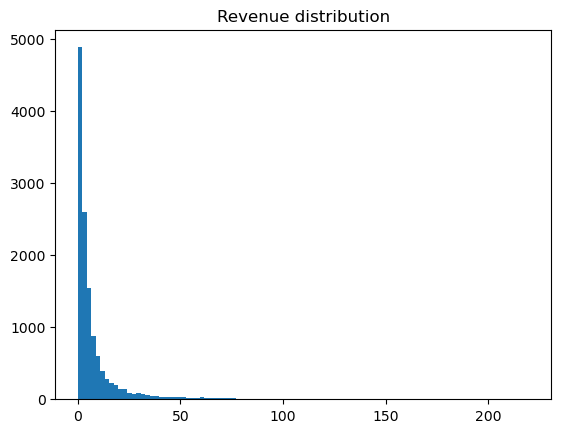

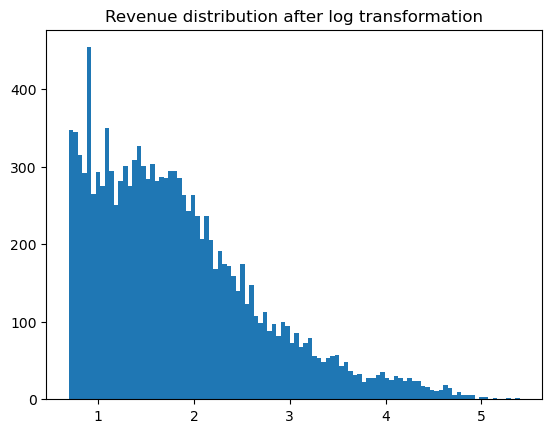

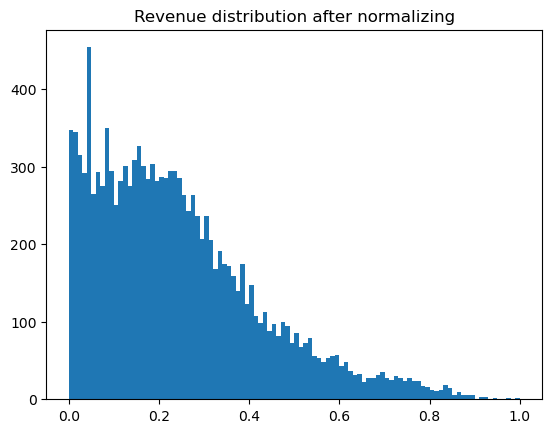

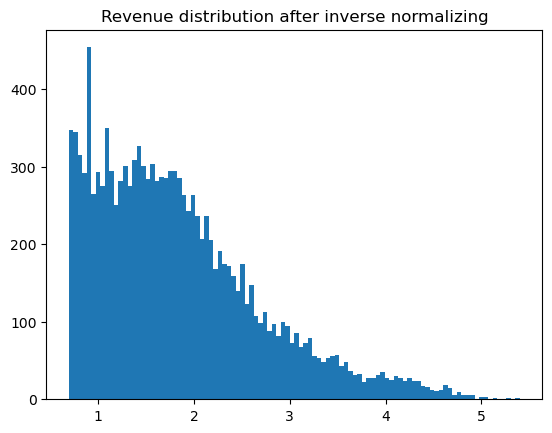

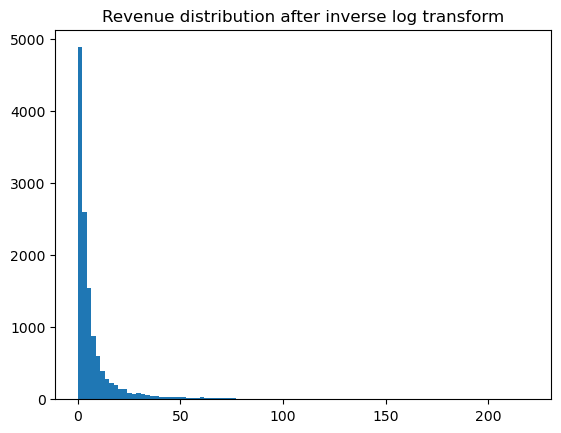

In [9]:
import matplotlib.pyplot as plt
import numpy as np


def log_transform(column: pd.Series):
    return column.map(lambda x: np.log(x + 2))

def inverse_log_transform(column: pd.Series):
    return np.exp(column).map(lambda x: x - 2)

# Plot revenue distribution
plt.hist(merged['revenue'], bins=100)
plt.title("Revenue distribution")
plt.show()

# Remove rows with revenue=0
#merged = merged.loc[~(merged['revenue'] == 0)]

# Perform log transform on revenue
merged['revenue'] = log_transform(merged['revenue'])
plt.hist(merged['revenue'], bins=100)
plt.title("Revenue distribution after log transformation")
plt.show()

# Normalize revenue between 0 and 1
min_revenue, max_revenue = merged['revenue'].min(), merged['revenue'].max()
merged['revenue'] = (merged['revenue'] - min_revenue) / (max_revenue - min_revenue)
plt.hist(merged['revenue'], bins=100)
plt.title("Revenue distribution after normalizing")
plt.show()

# Plot inverse normalization to confirm that it works
inversed = merged['revenue'] * (max_revenue - min_revenue) + min_revenue
plt.hist(inversed, bins=100)
plt.title("Revenue distribution after inverse normalizing")
plt.show()

# Plot inverse log transform to confirm that it works
inversed = inverse_log_transform(inversed)
plt.hist(inversed, bins=100)
plt.title("Revenue distribution after inverse log transform")
plt.show()


### Building a Model


In [10]:
df = h2o.H2OFrame(merged)
df_test = h2o.H2OFrame(merged_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [11]:
# Setting features as factor
catagorical_columns = ['store_name',
                       'plaace_hierarchy_id',
                       'sales_channel_name',
                       'grunnkrets_id',
                       'address',
                       'chain_name',
                       'mall_name']

for column in catagorical_columns:
    if column == 'lv2' or column == 'lv3' or column == 'lv4':
        continue
    df[column] = df[column].asfactor()
    df_test[column] = df_test[column].asfactor()

In [12]:
# Removing labels from train set
y = "revenue"
x = df.columns
x.remove(y)

In [12]:
# Running fit/training on train set with cross validation n=5
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(x = x, y = y, training_frame = df)

AutoML progress: |
19:30:31.762: _train param, Dropping bad and constant columns: [store_id]

██
19:30:57.636: _train param, Dropping bad and constant columns: [store_id]

██████
19:31:49.778: _train param, Dropping bad and constant columns: [store_id]

█
19:32:05.904: _train param, Dropping bad and constant columns: [store_id]

█
19:32:20.536: _train param, Dropping bad and constant columns: [store_id]

██
19:34:16.126: _train param, Dropping bad and constant columns: [store_id]

█
19:34:22.650: _train param, Dropping bad and constant columns: [store_id]


19:34:30.139: _train param, Dropping bad and constant columns: [store_id]

███
19:34:53.326: _train param, Dropping bad and constant columns: [store_id]

███
19:36:48.456: _train param, Dropping unused columns: [store_id]

█
19:36:52.461: _train param, Dropping unused columns: [store_id]

███████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_1_20221103_193031

No summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.00884657781934293
RMSE: 0.09405624816748183
MAE: 0.07065513321207853
RMSLE: 0.07511444575104279
Mean Residual Deviance: 0.00884657781934293
R^2: 0.73884297773174
Null degrees of freedom: 10049
Residual degrees of freedom: 10039
Null deviance: 340.4392902854131
Residual deviance: 88.90810708439645
AIC: -18968.96752992654

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.015705325494114478
RMSE: 0.12532089009464653
MAE: 0.09401759415217731
RMSLE: 0.09913781517017398
Mean Residual Deviance: 0.015705325494114478
R^2: 0.5320017976972664
Null degrees of freedom: 12858
Residual degrees of freedom: 12848
Null deviance: 431.6168740001491
Residual deviance: 201.95478052881805
AIC: -16896.879757792354

Cross-Validation Metrics Summary: 
                        mean       sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     0.0941484  0.00106471   0.0940392     0.0932421     0.0942155     0.0958967     0.0933483
mean_residual_deviance  0.0156944  0.000493621  0.0155946     0.0157238     0.0154155     0.0165114     0.0152269
mse                     0.0156944  0.000493621  0.0155946     0.0157238     0.0154155     0.0165114     0.0152269
null_deviance           86.3234    4.16137      88.254        81.7025       91.2502       88.1558       82.2544
r2                      0.531619   0.022283     0.537042      0.50204       0.556844      0.516168      0.545999
residual_deviance       40.372     1.91413      40.8577       40.646        40.4193       42.6159       37.3212
rmse                    0.125265   0.0019571    0.124878      0.125394      0.124159      0.128497      0.123398
rmsle                   0.0990955  0.00152452   0.0988686     0.0992467     0.0980553     0.101592      0.0977146

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [13]:
lb = aml.leaderboard
# Showing best perforimg models
lb.head()

model_id                                                     rmse        mse        mae      rmsle    mean_residual_deviance
-------------------------------------------------------  --------  ---------  ---------  ---------  ------------------------
StackedEnsemble_AllModels_1_AutoML_1_20221103_193031     0.125321  0.0157053  0.0940176  0.0991378                 0.0157053
StackedEnsemble_BestOfFamily_1_AutoML_1_20221103_193031  0.125498  0.0157497  0.0941807  0.0992545                 0.0157497
GBM_1_AutoML_1_20221103_193031                           0.127027  0.0161358  0.0951558  0.100423                  0.0161358
GBM_2_AutoML_1_20221103_193031                           0.127205  0.016181   0.095381   0.100572                  0.016181
GBM_3_AutoML_1_20221103_193031                           0.127326  0.016212   0.0952255  0.10063                   0.016212
GLM_1_AutoML_1_20221103_193031                           0.127773  0.016326   0.0964209  0.100944                  0.016326
GBM_4_AutoML_1_20221103_193031                           0.12789   0.0163559  0.0956855  0.10107                   0.0163559
DRF_1_AutoML_1_20221103_193031                           0.128336  0.0164701  0.0950845  0.10128                   0.0164701
XGBoost_3_AutoML_1_20221103_193031                       0.128946  0.016627   0.0978864  0.101833                  0.016627
XGBoost_2_AutoML_1_20221103_193031                       0.129295  0.0167171  0.097415   0.10219                   0.0167171
[10 rows x 6 columns]

### Creating a Submission

In [14]:
# Predict on the test set
#preds = aml.predict(df_test)
preds = aml.get_best_model(criterion="RMSLE").predict(df_test)
preds = h2o.as_list(preds)

# Inverse normalization
preds['predict'] = preds['predict'] * (max_revenue - min_revenue) + min_revenue
# Inverse log transform
preds['predict'] = inverse_log_transform(preds['predict'])

# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = stores_test.store_id 
submission['predicted'] = np.asarray(preds)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('sample_submission.csv', index=False)
submission

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'store_name' has levels not trained on: ["0047 OSLO AS", "1001 IMPORT TROMSØ AS", "1001 NATT", "2 FRISØRER MØRSTAD STORSENTER", "2 WEAR AMFI BERTHEUS", "24-7 TRENIGSSENTER SENTRUM", "24-7 TRENINGSSENTER MARIERO", "3 BYGG ØSTFOLD AS", "3 T ROSTEN", "3 T STEINKJER", ...8493 not listed..., "ØSTVOLD ERNST AS", "ØVERLANDS ARNULF GALLERI AS", "ØVERÅS TORE AS", "ØVRE SUKKE GÅRD AS", "ØYA FYRVERKERI AS", "ØYE GUNNAR AS", "ØYENE OPTIKK AS", "ØYENLEGE ALTENAU", "ØYEREN BÅTSERVICE AS", "ØYNOR CONSULT AS"]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'plaace_hierarchy_id' has levels not trained on: ["1.5.1.0"]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'sales_channel_name' has levels not trained on: ["Bowling alleys"]
  warnings.warn(w)
/opt/conda/lib/python

id  predicted
0     914206820-914239427-717245   3.808377
1     916789157-916823770-824309   6.823427
2       913341082-977479363-2948   3.671630
3      889682582-889697172-28720   6.253134
4     997991699-998006945-417222  16.894373
...                          ...        ...
8572  917323003-917383529-844309   7.092716
8573  917353379-917411824-845904   3.282901
8574  917072302-917089248-833647   6.405402
8575  916960557-916993161-829908   3.223137
8576   987280891-972040746-45320   2.843537

[8577 rows x 2 columns]

# Explain

In [15]:
#aml.explain(df)

# 14 - bus stop and stores distance feature engineering with memory optimization

This notebook attempts to do some feature engineering with the bus stops dataset in order to determine how central or accessible each store is. This quickly became a problem since we tried to calculate the distances in the combination of "all stores x all bus stops" - which gave a very large list of distances (~10k stores x ~70k bus stops). We therefore ran out of ram - even while using 32GB. 

To combat this, we optimized the memory usage by only storing the distances we actually needed. This highly reduced the list down to a managable size. We used this to calculate features that represented the count of bus stops within different radiuses. 

This worked well, and we decided to try the same for other stores as well. The stores search space was not as bad (~10k x ~10k). This also improved our score.

In [1]:
# Import and init h2o lib. Running on javasample_submission.csv
sample_submission.csv
Complete · thomassteenfeldt · 1d ago · 16 - EXACT same as six tries ago (0.68233) (just had to make sure it was reproducable)
0.68233

￼
check_circle
#%pip install h2o
import h2o
from h2o.automl import H2OAutoML
h2o.init()

SyntaxError: invalid character in identifier (3585410160.py, line 2)

### Load datasets

In [3]:
import pandas as pd

stores_train = pd.read_csv('data/stores_train.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_test = pd.read_csv('data/stores_test.csv', engine="python", error_bad_lines=False, encoding='utf-8')
busstops_norway = pd.read_csv('data/busstops_norway.csv', engine="python", error_bad_lines=False, encoding='utf-8')

Skipping line 12465: unexpected end of data


## Bus stop engineering: Storing only the count of different radiuses instead of the entire set of distances to save memory

## Haversine latlong distance calculation

In [4]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return km

## stores_train

In [7]:
# only store distance counts < 10 km to save space

from tqdm import tqdm

stores = []
for i, store in tqdm(stores_train.iterrows()):

    distances_1_km = 0
    distances_5_km = 0
    distances_10_km = 0

    store_lat = store.lat
    store_lon = store.lon    

    for j, busstop in busstops_norway.iterrows():
        busstop_latlon = busstop.geometry[6:-1]
        [busstop_lon, busstop_lat] = busstop_latlon.split(' ')
        busstop_lat = float(busstop_lat)
        busstop_lon = float(busstop_lon)
        distance = haversine(store_lon, store_lat, busstop_lon, busstop_lat) # km
        
        if distance < 10:
            distances_10_km += 1

        if distance < 5:
            distances_5_km += 1

        if distance < 1:
            distances_1_km += 1

    stores.append([distances_1_km, distances_5_km, distances_10_km])

In [8]:
# save to csv

stores_distances = np.array(stores)

stores_train['busstops_within_1km'] = stores_distances[:,0]
stores_train['busstops_within_5km'] = stores_distances[:,1]
stores_train['busstops_within_10km'] = stores_distances[:,2]

stores_train.to_csv('/data/stores_train_busstop_distances.csv', index=False)

stores_train

In [10]:
# load checkpoint csv
# stores_train = pd.read_csv('data/stores_train_busstop_distances.csv', engine="python", error_bad_lines=False, encoding='utf-8')

/tmp/ipykernel_376824/3048631481.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  stores_train = pd.read_csv('../data/stores_train_busstop_distances.csv', engine="python", error_bad_lines=False, encoding='utf-8')


## stores_test

In [12]:
# only store distance counts < 10 km to save space

from tqdm import tqdm

stores = []
for i, store in tqdm(stores_test.iterrows()):

    distances_1_km = 0
    distances_5_km = 0
    distances_10_km = 0

    store_lat = store.lat
    store_lon = store.lon    

    for j, busstop in busstops_norway.iterrows():
        busstop_latlon = busstop.geometry[6:-1]
        [busstop_lon, busstop_lat] = busstop_latlon.split(' ')
        busstop_lat = float(busstop_lat)
        busstop_lon = float(busstop_lon)
        distance = haversine(store_lon, store_lat, busstop_lon, busstop_lat) # km
        
        if distance < 10:
            distances_10_km += 1

        if distance < 5:
            distances_5_km += 1

        if distance < 1:
            distances_1_km += 1

    stores.append([distances_1_km, distances_5_km, distances_10_km])

In [13]:
# save to csv

stores_distances = np.array(stores)

stores_test['busstops_within_1km'] = stores_distances[:,0]
stores_test['busstops_within_5km'] = stores_distances[:,1]
stores_test['busstops_within_10km'] = stores_distances[:,2]

stores_test.to_csv('/data/stores_test_busstop_distances.csv', index=False)

stores_test

In [15]:
# load checkpoint csv
stores_test = pd.read_csv('data/stores_test_busstop_distances.csv', engine="python", error_bad_lines=False, encoding='utf-8')

/tmp/ipykernel_376824/2619353580.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  stores_test = pd.read_csv('../data/stores_test_busstop_distances.csv', engine="python", error_bad_lines=False, encoding='utf-8')


## stores distances engineering

### train

In [16]:
# save store x store distances

from tqdm import tqdm

stores = []
for i, store in tqdm(stores_train.iterrows()):

    distances_1_km = 0
    distances_5_km = 0
    distances_10_km = 0

    store_lat = store.lat
    store_lon = store.lon    

    for j, other_store in stores_train.iterrows():
        other_store_lat = other_store.lat
        other_store_lon = other_store.lon    
        
        distance = haversine(store_lon, store_lat, other_store_lon, other_store_lat) # km

        if distance < 10:
            distances_10_km += 1

        if distance < 5:
            distances_5_km += 1

        if distance < 1:
            distances_1_km += 1

    stores.append([distances_1_km, distances_5_km, distances_10_km])

In [17]:
# save to csv

stores_distances = np.array(stores)

stores_train['stores_within_1km'] = stores_distances[:,0]
stores_train['stores_within_5km'] = stores_distances[:,1]
stores_train['stores_within_10km'] = stores_distances[:,2]

stores_train.to_csv('../data/stores_train_busstop_stores_distances.csv', index=False)

stores_train

In [18]:
stores_train = pd.read_csv('../data/stores_train_busstop_stores_distances.csv', engine="python", error_bad_lines=False, encoding='utf-8')

/tmp/ipykernel_376824/1416784484.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  stores_train = pd.read_csv('../data/stores_train_busstop_stores_distances.csv', engine="python", error_bad_lines=False, encoding='utf-8')


## test

In [19]:
# save store x store distances

from tqdm import tqdm

stores = []
for i, store in tqdm(stores_test.iterrows()):
    distances_1_km = 0
    distances_5_km = 0
    distances_10_km = 0

    store_lat = store.lat
    store_lon = store.lon    

    for j, other_store in stores_test.iterrows():
        other_store_lat = other_store.lat
        other_store_lon = other_store.lon    
        
        distance = haversine(store_lon, store_lat, other_store_lon, other_store_lat) # km
        
        if distance < 10:
            distances_10_km += 1

        if distance < 5:
            distances_5_km += 1

        if distance < 1:
            distances_1_km += 1

    stores.append([distances_1_km, distances_5_km, distances_10_km])

8577it [41:56,  3.41it/s]


In [20]:
# save to csv

stores_distances = np.array(stores)

stores_test['stores_within_1km'] = stores_distances[:,0]
stores_test['stores_within_5km'] = stores_distances[:,1]
stores_test['stores_within_10km'] = stores_distances[:,2]

stores_test.to_csv('data/stores_test_busstop_stores_distances.csv', index=False)

stores_test

store_id                    store_name  \
0     914206820-914239427-717245     VÅLERENGA HALAL BURGER AS   
1     916789157-916823770-824309             BURGER KING MYREN   
2       913341082-977479363-2948           BURGER KING STOVNER   
3      889682582-889697172-28720       BURGER KING TUNGASLETTA   
4     997991699-998006945-417222              VULKAN BURGERBAR   
...                          ...                           ...   
8572  917323003-917383529-844309            GULATING HAUGESUND   
8573  917353379-917411824-845904             STAVANGER BEER AS   
8574  917072302-917089248-833647      GULATING ØLUTSALG OG PUB   
8575  916960557-916993161-829908     VI BRYGGER BUTIKKDRIFT AS   
8576   987280891-972040746-45320  KROKEN ØL OG MINERALVANN ANS   

     plaace_hierarchy_id     sales_channel_name  grunnkrets_id  \
0                1.1.1.0  Hamburger restaurants        3012704   
1                1.1.1.0  Hamburger restaurants        8061401   
2                1.1.1.0  Hamburger restaurants        3013917   
3                1.1.1.0  Hamburger restaurants       16012104   
4                1.1.1.0  Hamburger restaurants        3014305   
...                  ...                    ...            ...   
8572            2.8.11.2     Beer and soda shop       11490601   
8573            2.8.11.2     Beer and soda shop       11030901   
8574            2.8.11.2     Beer and soda shop        2270103   
8575            2.8.11.2     Beer and soda shop       12470701   
8576            2.8.11.2     Beer and soda shop        8170207   

                     address        lat        lon        chain_name  \
0           STRØMSVEIEN 25 A  59.908672  10.787031               NaN   
1                    MYREN 1  59.201467   9.588243       BURGER KING   
2           STOVNER SENTER 3  59.962146  10.924524       BURGER KING   
3             TUNGASLETTA 16  63.420785  10.461091       BURGER KING   
4     AUD SCHØNEMANNS VEI 15  59.921102  10.785123  VULKAN BURGERBAR   
...                      ...        ...        ...               ...   
8572           BRÅTAVEGEN 30  59.259575   5.325813  GULATING GRUPPEN   
8573              SANDVIGÅ 7  58.976219   5.721546               NaN   
8574          GARDERBAKKEN 6  59.928330  11.163202  GULATING GRUPPEN   
8575          RAVNANGERVEGEN  60.445790   5.161587               NaN   
8576                     NaN  59.097903   9.055490               NaN   

           mall_name  busstops_within_1km  busstops_within_5km  \
0                NaN                   56                  788   
1                NaN                   18                  244   
2     Stovner Senter                   17                  339   
3                NaN                   33                  536   
4                NaN                   45                  820   
...              ...                  ...                  ...   
8572             NaN                    9                   79   
8573             NaN                   46                  571   
8574             NaN                   16                   64   
8575             NaN                   11                  201   
8576             NaN                    7                   22   

      busstops_within_10km  stores_within_1km  stores_within_5km  \
0                     1609                 37                942   
1                      433                  6                 71   
2                     1178                  8                107   
3                      947                  4                245   
4                     1578                 35                942   
...                    ...                ...                ...   
8572                   255                  1                 12   
8573                  1093                 79                189   
8574                   355                  5                  6   
8575                   801                  4                 18   
8576                    44      

In [21]:
# load checkpoint csv
# stores_test = pd.read_csv('data/stores_test_busstop_stores_distances.csv', engine="python", error_bad_lines=False, encoding='utf-8')

# Data cleaning

In [22]:
# Remove 'year' column from stores since it only has one value
#stores_train.drop(['year'], axis=1, inplace=True)
#stores_test.drop(['year'], axis=1, inplace=True)

In [26]:
# TODO: Fix duplicate columns 'sales_channel_name_x', 'couple_without_children_x', 'singles_x'

list(stores_train.columns)

['store_id',
 'store_name',
 'plaace_hierarchy_id',
 'sales_channel_name',
 'grunnkrets_id',
 'address',
 'lat',
 'lon',
 'chain_name',
 'mall_name',
 'revenue',
 'busstops_within_1km',
 'busstops_within_5km',
 'busstops_within_10km',
 'stores_within_1km',
 'stores_within_5km',
 'stores_within_10km']

## revenue feature engineering

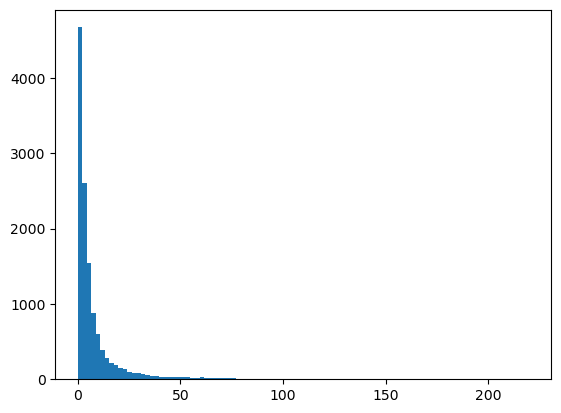

/tmp/ipykernel_376824/2149339045.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['revenue'] = merged['revenue'].map(lambda x: np.log(x+2))


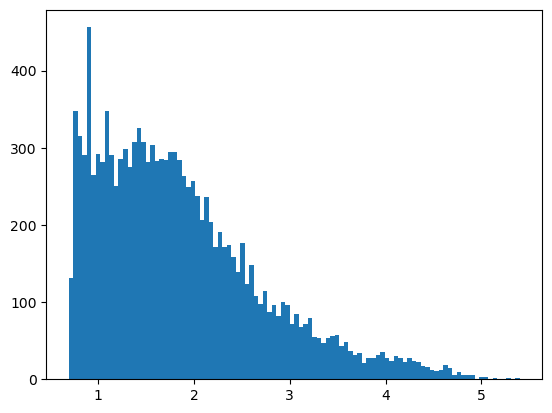

/tmp/ipykernel_376824/2149339045.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['revenue'] = (merged['revenue'] - min_revenue) / (max_revenue - min_revenue)


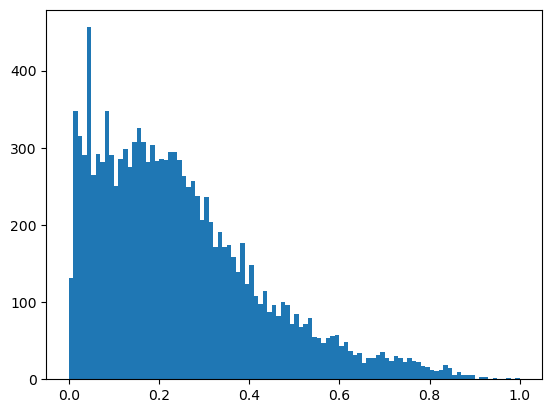

In [27]:
import matplotlib.pyplot as plt

# Remove rows with revenue=0
stores_train = stores_train.loc[~(stores_train['revenue'] == 0)]
plt.hist(stores_train['revenue'], bins=100)
plt.show()

# Perform log transform on revenue
stores_train['revenue'] = stores_train['revenue'].map(lambda x: np.log(x+2))
plt.hist(stores_train['revenue'], bins=100)
plt.show()

# Normalize revenue between 0 and 1
min_revenue, max_revenue = stores_train['revenue'].min(), stores_train['revenue'].max()
stores_train['revenue'] = (stores_train['revenue'] - min_revenue) / (max_revenue - min_revenue)
plt.hist(stores_train['revenue'], bins=100)
plt.show()

In [28]:
stores_train['revenue']

0        0.489033
1        0.543380
2        0.467836
3        0.367691
4        0.251200
           ...   
12854    0.009041
12855    0.137142
12856    0.637497
12857    0.220213
12858    0.163888
Name: revenue, Length: 12642, dtype: float64

### Building a Model


In [29]:
df = h2o.H2OFrame(stores_train)
df_test = h2o.H2OFrame(stores_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [30]:
# Setting features as factor
catagorical_columns = ['store_name',
                       'plaace_hierarchy_id',
                       'sales_channel_name',
                       'grunnkrets_id',
                       'address',
                       'chain_name',
                       'mall_name']

for column in catagorical_columns:
    if column == 'lv2' or column == 'lv3' or column == 'lv4':
        continue
    df[column] = df[column].asfactor()
    df_test[column] = df_test[column].asfactor()

In [31]:
# Removing labels from train set
y = "revenue"
x = df.columns
x.remove(y)

In [32]:
# Running fit/training on train set with cross validation n=5
aml = H2OAutoML(seed = 1)
aml.train(x = x, y = y, training_frame = df)

AutoML progress: |
20:28:41.806: _train param, Dropping bad and constant columns: [store_id]

████
20:30:43.673: _train param, Dropping bad and constant columns: [store_id]


20:30:55.471: _train param, Dropping bad and constant columns: [store_id]


20:30:59.294: _train param, Dropping unused columns: [store_id]
20:30:59.645: _train param, Dropping bad and constant columns: [store_id]

██
20:32:08.478: _train param, Dropping bad and constant columns: [store_id]

█
20:33:11.348: _train param, Dropping bad and constant columns: [store_id]
20:33:13.570: _train param, Dropping bad and constant columns: [store_id]

█
20:33:16.336: _train param, Dropping bad and constant columns: [store_id]


20:33:20.508: _train param, Dropping unused columns: [store_id]

█
20:33:20.861: _train param, Dropping unused columns: [store_id]
20:33:21.206: _train param, Dropping bad and constant columns: [store_id]

████
20:33:46.7: _train param, Dropping bad and constant columns: [store_id]

█
20:34:32.89: _tra

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20221106_202841

No summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.007420190725814144
RMSE: 0.08614052893855566
MAE: 0.06458865663107949
RMSLE: 0.06845814739136874
Mean Residual Deviance: 0.007420190725814144
R^2: 0.7749191814477162
Null degrees of freedom: 10049
Residual degrees of freedom: 10030
Null deviance: 331.3165043467062
Residual deviance: 74.57291679443215
AIC: -20718.01818693413

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.014144764756014993
RMSE: 0.11893176512612176
MAE: 0.08903180012845899
RMSLE: 0.09362841177689933
Mean Residual Deviance: 0.014144764756014993
R^2: 0.5727212425874411
Null degrees of freedom: 12641
Residual degrees of freedom: 12623
Null deviance: 418.51749887624226
Residual deviance: 178.81811604554153
AIC: -17918.386262351876

Cross-Validation Metrics Summary: 
                        mean       sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     0.0890425  0.0011309    0.0892634     0.0887049     0.0873686     0.0894146     0.0904611
mean_residual_deviance  0.0141474  0.000260937  0.0143957     0.0138319     0.0139208     0.0142032     0.0143854
mse                     0.0141474  0.000260937  0.0143957     0.0138319     0.0139208     0.0142032     0.0143854
null_deviance           83.7035    3.74255      81.4828       86.5445       88.8408       80.9922       80.6571
r2                      0.571967   0.0234472    0.544005      0.593717      0.596896      0.554019      0.571196
residual_deviance       35.7643    0.977648     37.1554       35.1606       35.8042       36.1187       34.5826
rmse                    0.118939   0.00109796   0.119982      0.117609      0.117986      0.119177      0.119939
rmsle                   0.0936346  0.000923664  0.094575      0.0926699     0.0926942     0.093765      0.094469

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [33]:
lb = aml.leaderboard
# Showing best perforimg models
lb.head()

model_id                                                     rmse        mse        mae      rmsle    mean_residual_deviance
-------------------------------------------------------  --------  ---------  ---------  ---------  ------------------------
StackedEnsemble_AllModels_3_AutoML_1_20221106_202841     0.118932  0.0141448  0.0890318  0.0936284                 0.0141448
StackedEnsemble_AllModels_4_AutoML_1_20221106_202841     0.118979  0.0141561  0.0890483  0.093666                  0.0141561
StackedEnsemble_AllModels_6_AutoML_1_20221106_202841     0.119052  0.0141733  0.0891897  0.0937165                 0.0141733
StackedEnsemble_BestOfFamily_7_AutoML_1_20221106_202841  0.119133  0.0141926  0.0893597  0.0937946                 0.0141926
StackedEnsemble_BestOfFamily_5_AutoML_1_20221106_202841  0.119163  0.0141998  0.0893006  0.0938175                 0.0141998
StackedEnsemble_BestOfFamily_4_AutoML_1_20221106_202841  0.119223  0.0142142  0.0893188  0.0938485                 0.0142142
StackedEnsemble_AllModels_2_AutoML_1_20221106_202841     0.119261  0.0142232  0.0893878  0.0938996                 0.0142232
StackedEnsemble_BestOfFamily_3_AutoML_1_20221106_202841  0.11938   0.0142516  0.0894527  0.0939762                 0.0142516
StackedEnsemble_AllModels_1_AutoML_1_20221106_202841     0.119444  0.0142668  0.0895947  0.0940411                 0.0142668
StackedEnsemble_BestOfFamily_2_AutoML_1_20221106_202841  0.119588  0.0143013  0.089697   0.0941567                 0.0143013
[10 rows x 6 columns]

### Creating a Submission

In [34]:
def inverse_log_transform(column: pd.Series):
    return np.exp(column).map(lambda x: x - 2)

In [35]:
# Predict on the test set
#preds = aml.predict(df_test)
preds = aml.get_best_model(criterion="RMSLE").predict(df_test)
preds = h2o.as_list(preds)

# Inverse normalization
preds['predict'] = preds['predict'] * (max_revenue - min_revenue) + min_revenue
#preds['predict'] = preds['predict'] * normalization_factor

# Inverse log transform
# preds['predict'] = np.exp(preds['predict'])
preds['predict'] = inverse_log_transform(preds['predict'])

# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = stores_test.store_id 
submission['predicted'] = np.asarray(preds)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('sample_submission.csv', index=False)
submission

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/home/trymg/.local/lib/python3.10/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'store_name' has levels not trained on: ["0047 OSLO AS", "1001 IMPORT TROMSØ AS", "1001 NATT", "2 FRISØRER MØRSTAD STORSENTER", "2 WEAR AMFI BERTHEUS", "24-7 TRENIGSSENTER SENTRUM", "24-7 TRENINGSSENTER MARIERO", "3 BYGG ØSTFOLD AS", "3 T ROSTEN", "3 T STEINKJER", ...8493 not listed..., "ØSTVOLD ERNST AS", "ØVERLANDS ARNULF GALLERI AS", "ØVERÅS TORE AS", "ØVRE SUKKE GÅRD AS", "ØYA FYRVERKERI AS", "ØYE GUNNAR AS", "ØYENE OPTIKK AS", "ØYENLEGE ALTENAU", "ØYEREN BÅTSERVICE AS", "ØYNOR CONSULT AS"]
  warnings.warn(w)
/home/trymg/.local/lib/python3.10/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'plaace_hierarchy_id' has levels not trained on: ["1.5.1.0"]
  warnings.warn(w)
/home/trymg/.local/lib/python3.10/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'sales_channel_name' has levels not trained on: ["Bowling alleys"]
  warnings.wa

id  predicted
0     914206820-914239427-717245   3.855776
1     916789157-916823770-824309   5.848100
2       913341082-977479363-2948   3.717278
3      889682582-889697172-28720   6.405339
4     997991699-998006945-417222  14.462778
...                          ...        ...
8572  917323003-917383529-844309   5.574410
8573  917353379-917411824-845904   3.427824
8574  917072302-917089248-833647   6.163800
8575  916960557-916993161-829908   2.774432
8576   987280891-972040746-45320   2.301397

[8577 rows x 2 columns]

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                      rmse         mse        mae      rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------------------  ---------  ----------  ---------  ---------  ------------------------  ------------------  -------------------------  ---------------
DeepLearning_grid_1_AutoML_1_20221106_202841_model_1     0.0401889  0.00161514  0.0246431  0.0308117                0.00161514               76216                   0.823972  DeepLearning
GBM_grid_1_AutoML_1_20221106_202841_model_15             0.0422426  0.00178443  0.0287347  0.033689                 0.00178443                1564                   0.0143    GBM
GBM_grid_1_AutoML_1_20221106_202841_model_8              0.0426562  0.00181955  0.0308453  0.0349595                0.00181955                3011                   0.010667  GBM
GBM_grid_1_AutoML_1_20221106_202841_model_13             0.0537116  0.00288494  0.0408072  0.0433858                0.00288494                3527                   0.010181  GBM
DRF_1_AutoML_1_20221106_202841                           0.0565525  0.00319818  0.0425062  0.045241                 0.00319818               11095                   0.020307  DRF
GBM_grid_1_AutoML_1_20221106_202841_model_1              0.0565976  0.00320329  0.0393369  0.0447113                0.00320329                1456                   0.015466  GBM
GBM_grid_1_AutoML_1_20221106_202841_model_18             0.0589139  0.00347085  0.044483   0.047302                 0.00347085                1144                   0.012836  GBM
GBM_grid_1_AutoML_1_20221106_202841_model_5              0.0666208  0.00443834  0.0467443  0.0526596                0.00443834                2216                   0.009167  GBM
GBM_grid_1_AutoML_1_20221106_202841_model_10             0.0673117  0.00453087  0.0481429  0.0535346                0.00453087                1279                   0.010745  GBM
GBM_grid_1_AutoML_1_20221106_202841_model_21             0.072866   0.00530945  0.0534689  0.0588867                0.00530945                1399                   0.008433  GBM
GBM_grid_1_AutoML_1_20221106_202841_model_4              0.0742722  0.00551637  0.0525965  0.0583714                0.00551637                 977                   0.011324  GBM
GBM_grid_1_AutoML_1_20221106_202841_model_23             0.0774054  0.00599159  0.0554294  0.0617231                0.00599159                 936                   0.008067  GBM
XGBoost_grid_1_AutoML_1_20221106_202841_model_8          0.0780167  0.00608661  0.0618462  0.0636881                0.00608661               44651                   0.002927  XGBoost
StackedEnsemble_BestOfFamily_2_AutoML_1_20221106_202841  0.0831105  0.00690736  0.0622422  0.0658631                0.00690736                 342                   0.021801  StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20221106_202841     0.0861212  0.00741685  0.0646615  0.0684662                0.00741685                8853                   0.831941  StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20221106_202841     0.0861428  0.00742059  0.0643431  0.0684923                0.00742059                 335                   0.021821  StackedEnsemble
GBM_4_AutoML_1_20221106_202841                           0.0870066  0.00757016  0.0624855  0.0696326                0.00757016                 771                   0.008063  GBM
StackedEnsemble_AllModels_4_AutoML_1_20221106_202841     0.0870195  0.00757239  0.0655334  0.069244                 0.00757239                9022                   1.02176   StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20221106_202841  0.0877441  0.00769903  0.0664055  0.0698834                0.00769903                1208                   0.114399  StackedEnsemble
StackedEnsemble_AllModels_6_AutoML_1_20221106_202841     0.0881153  0.00776431  0.0667382  0.0702528                0.00776431                9375         

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

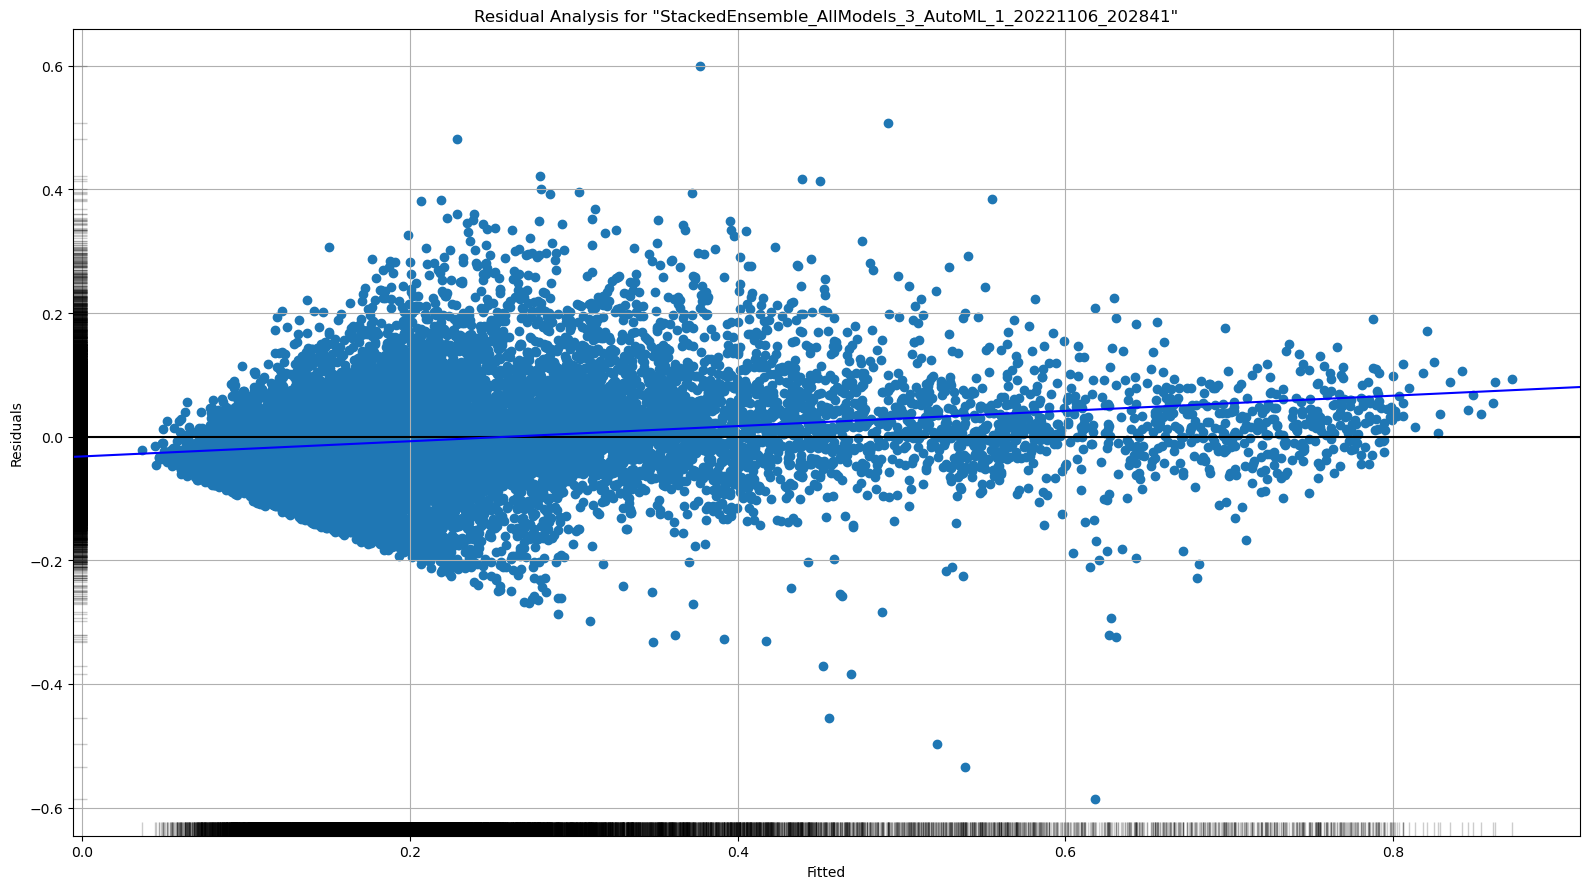

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

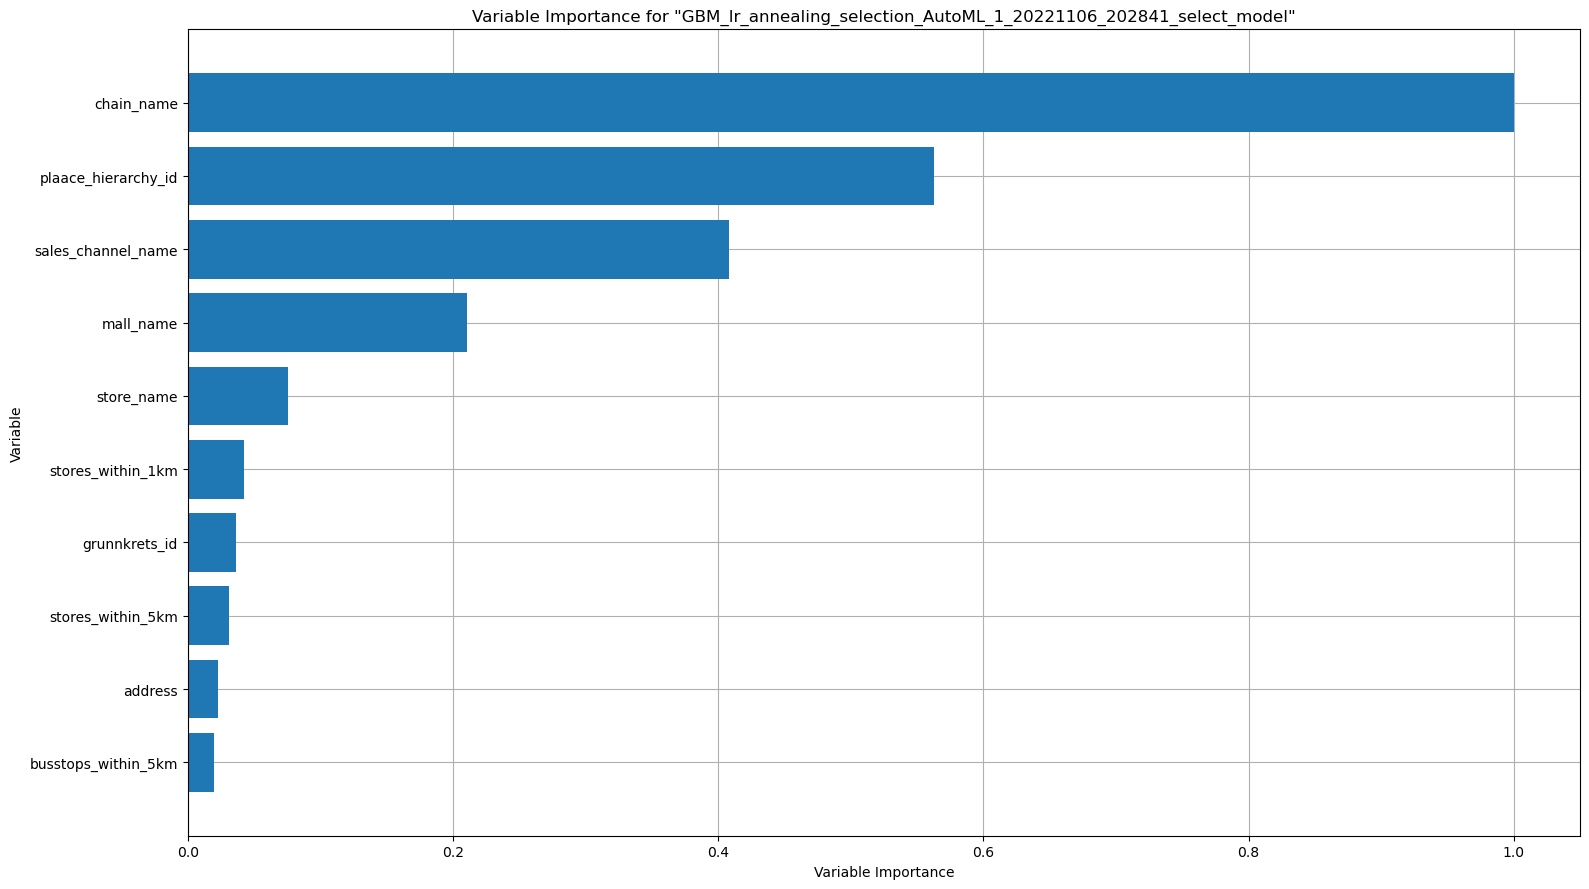

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

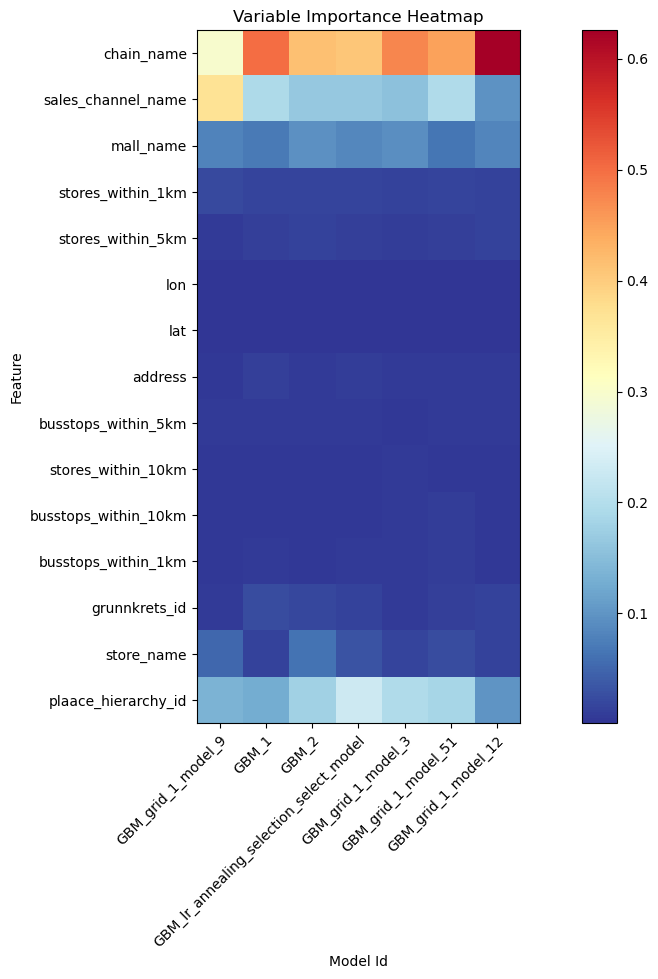

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

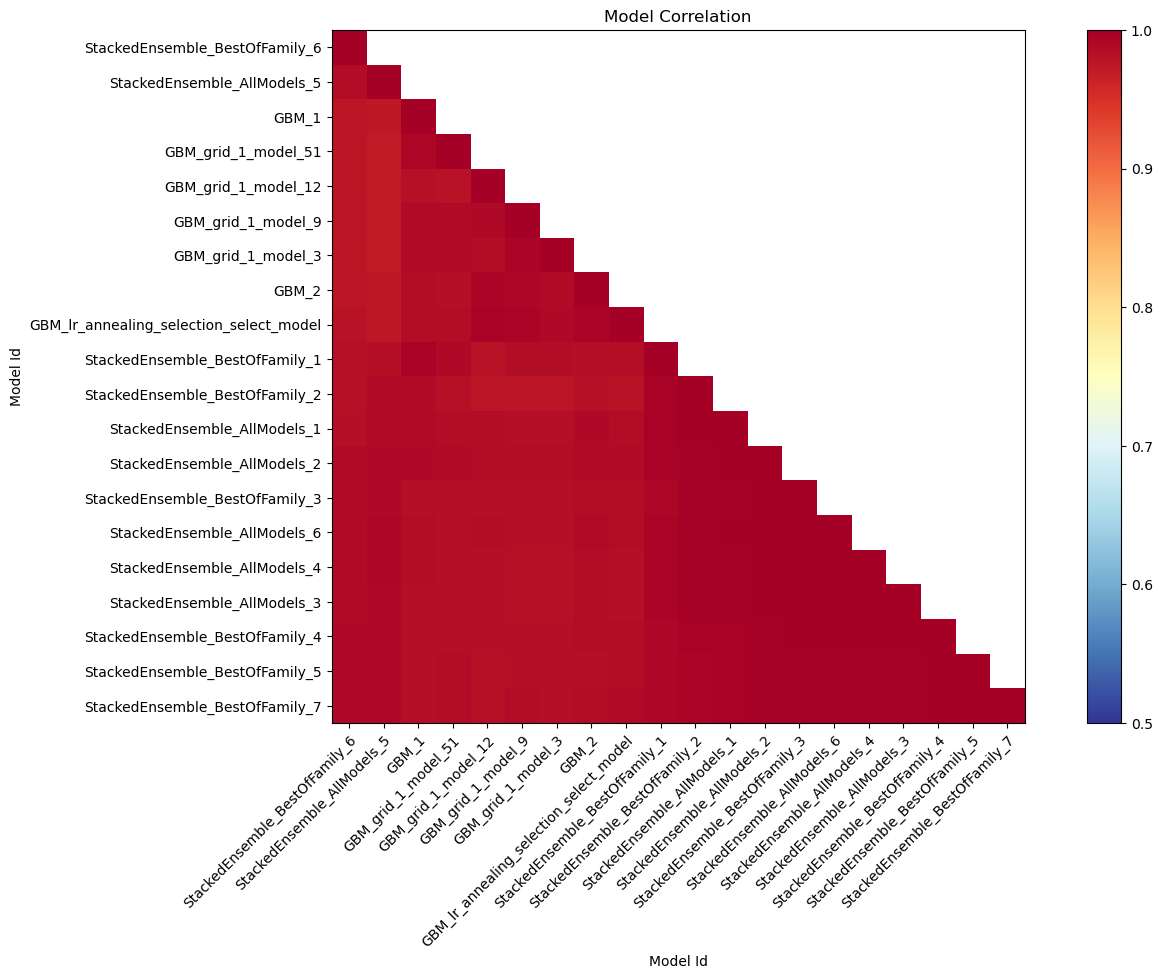

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

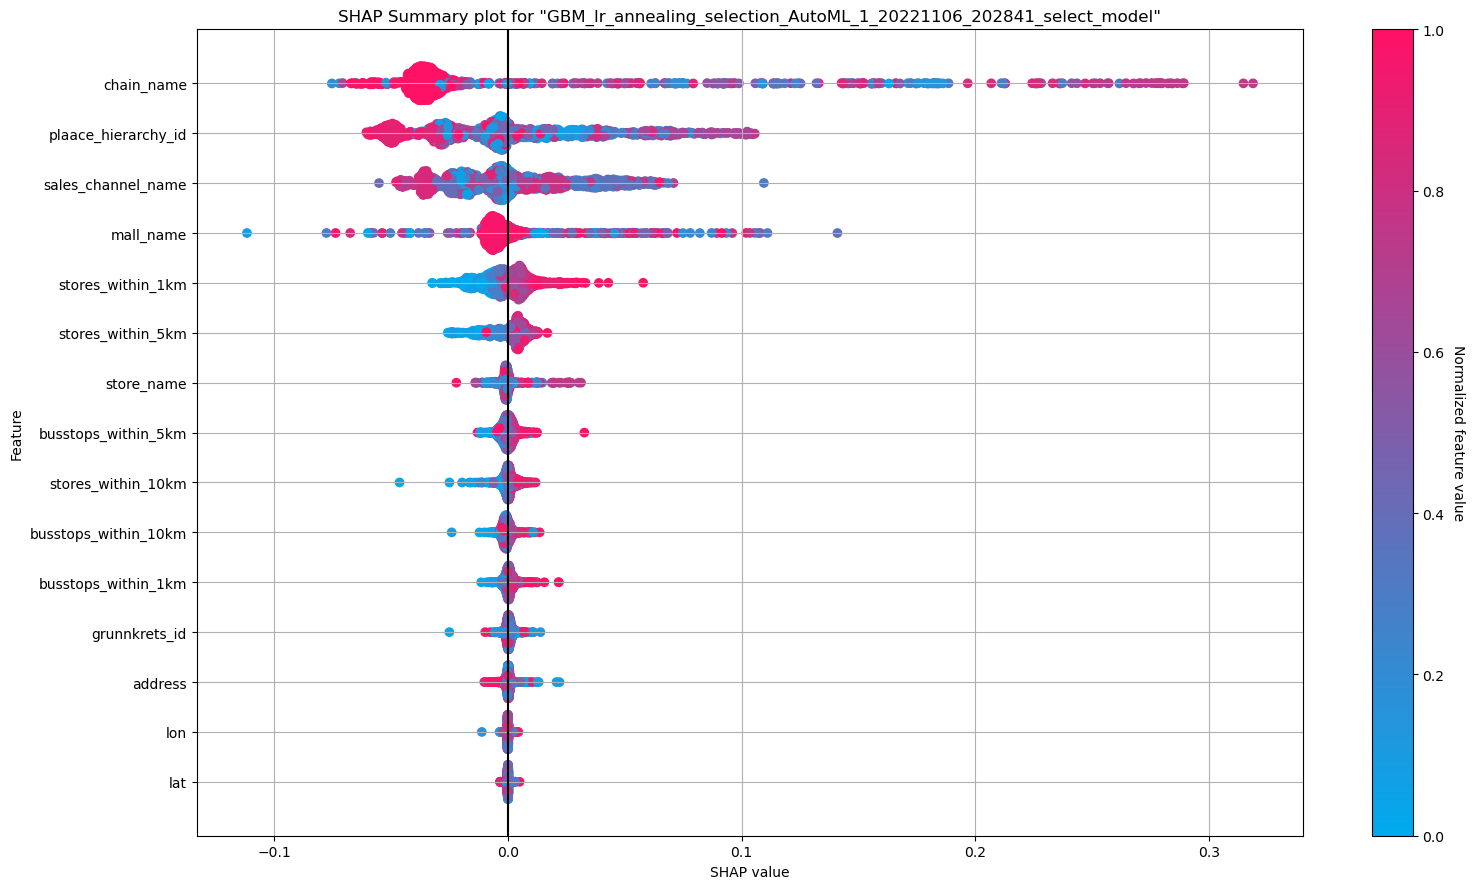

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

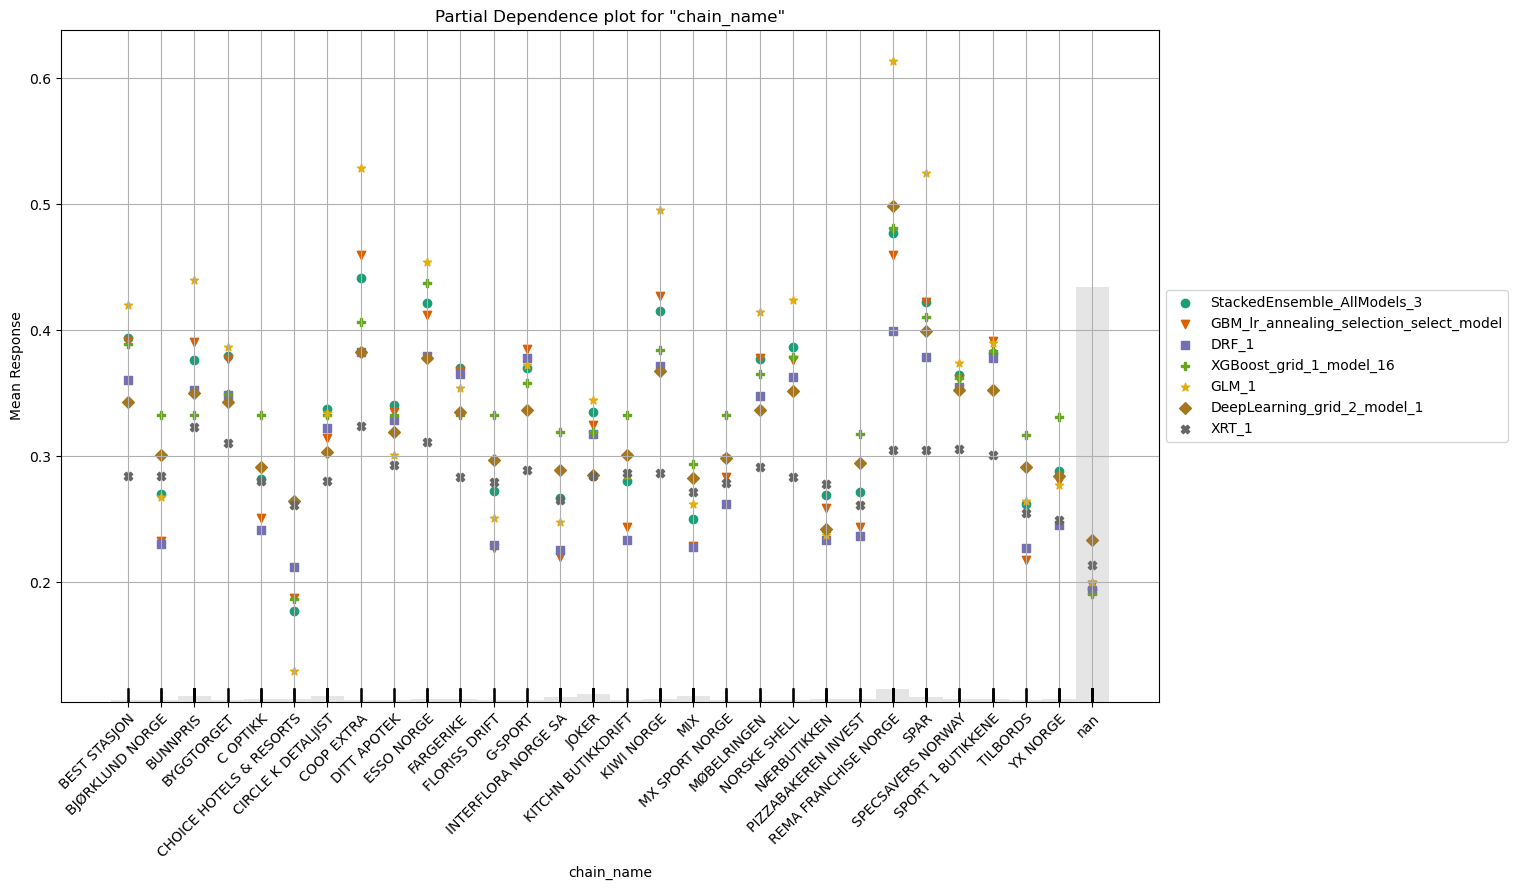

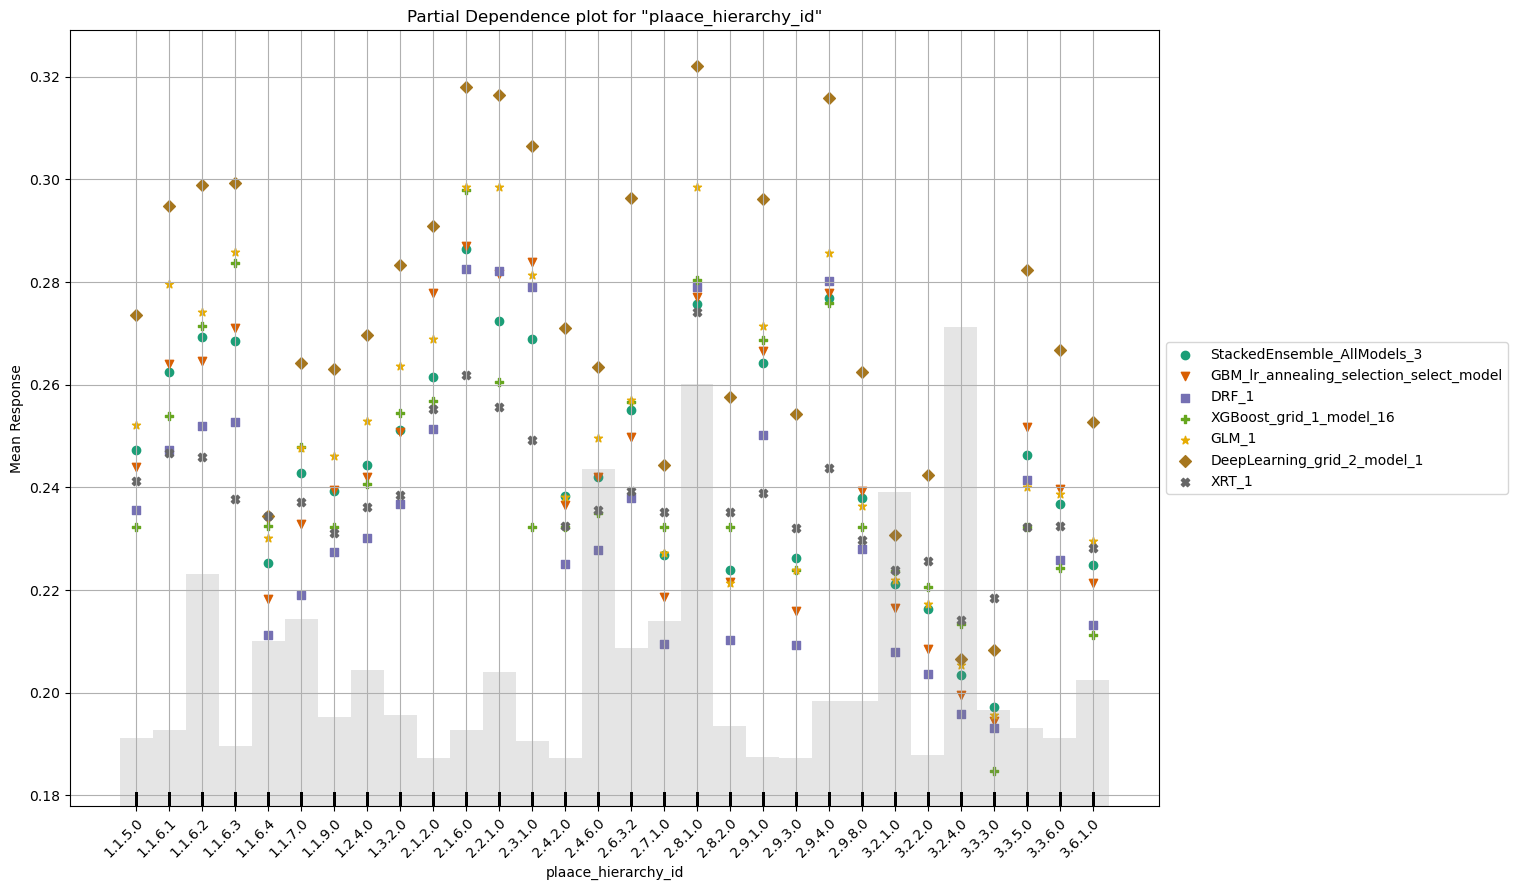

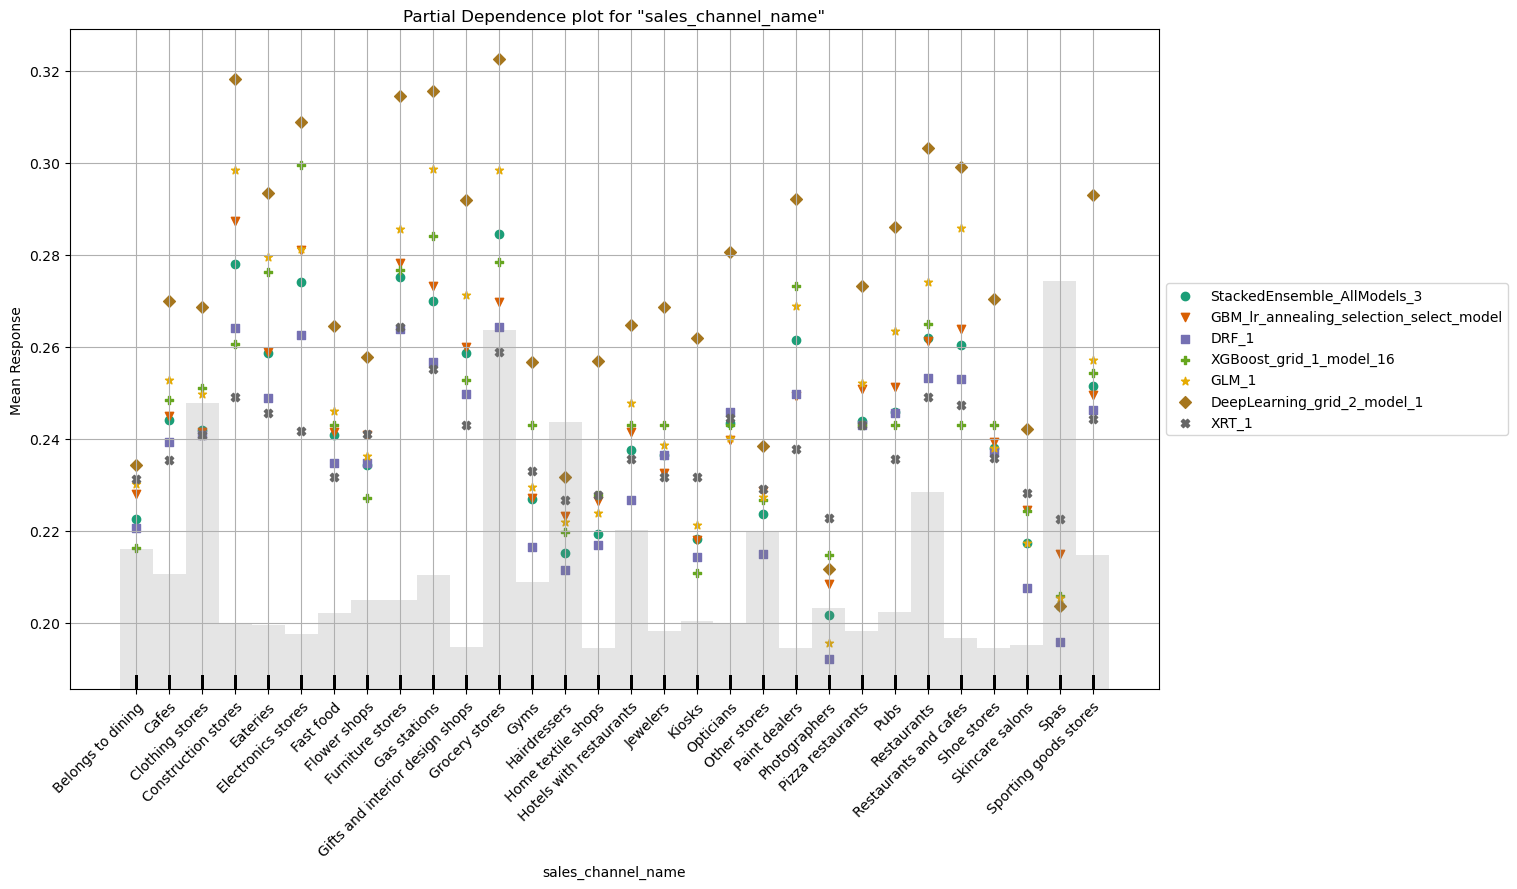

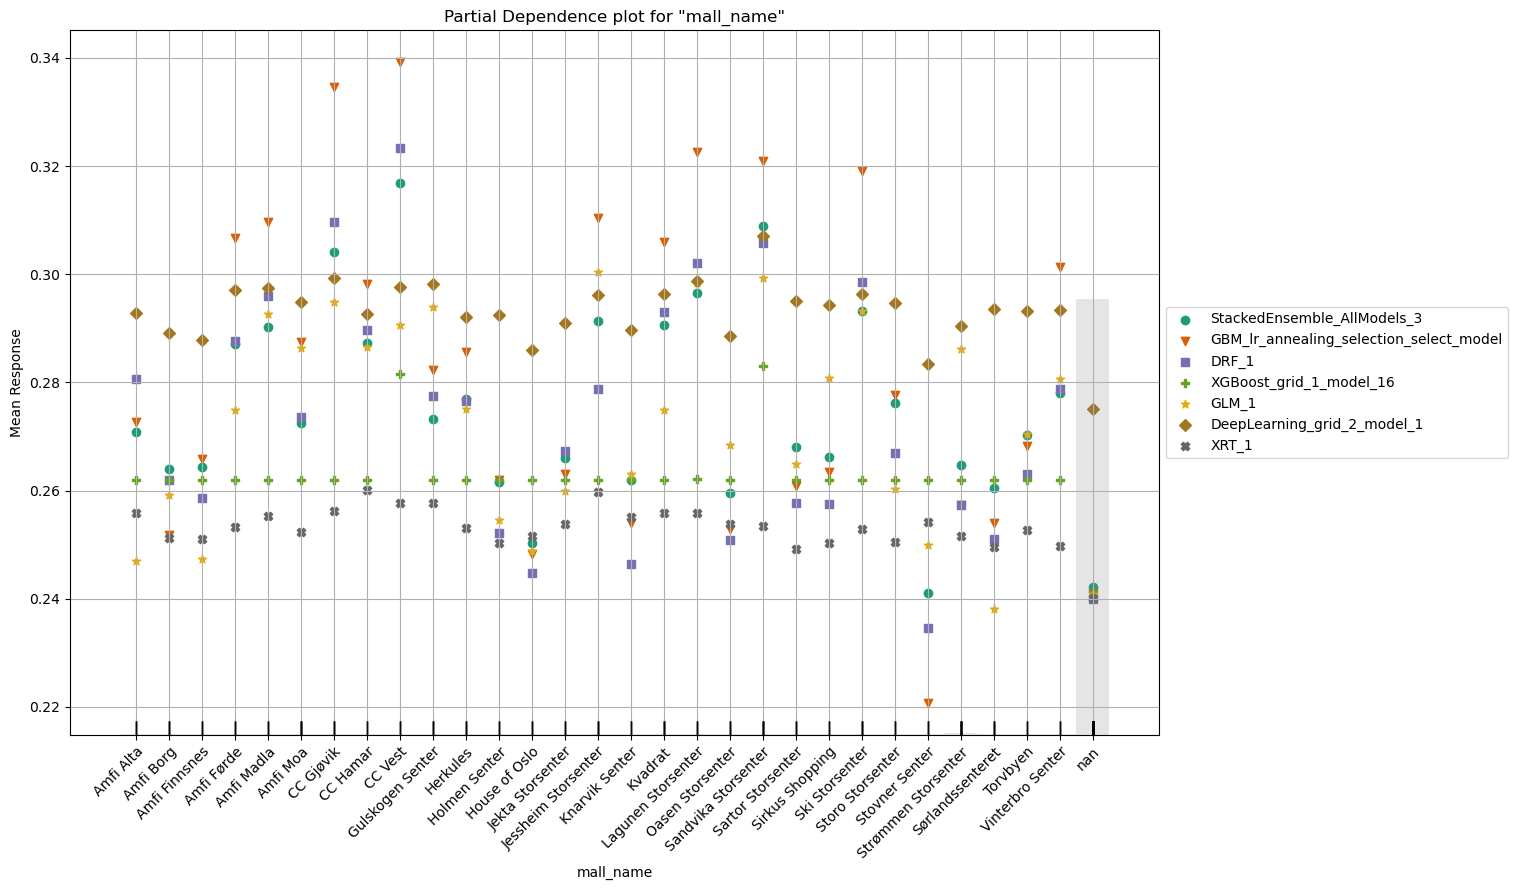

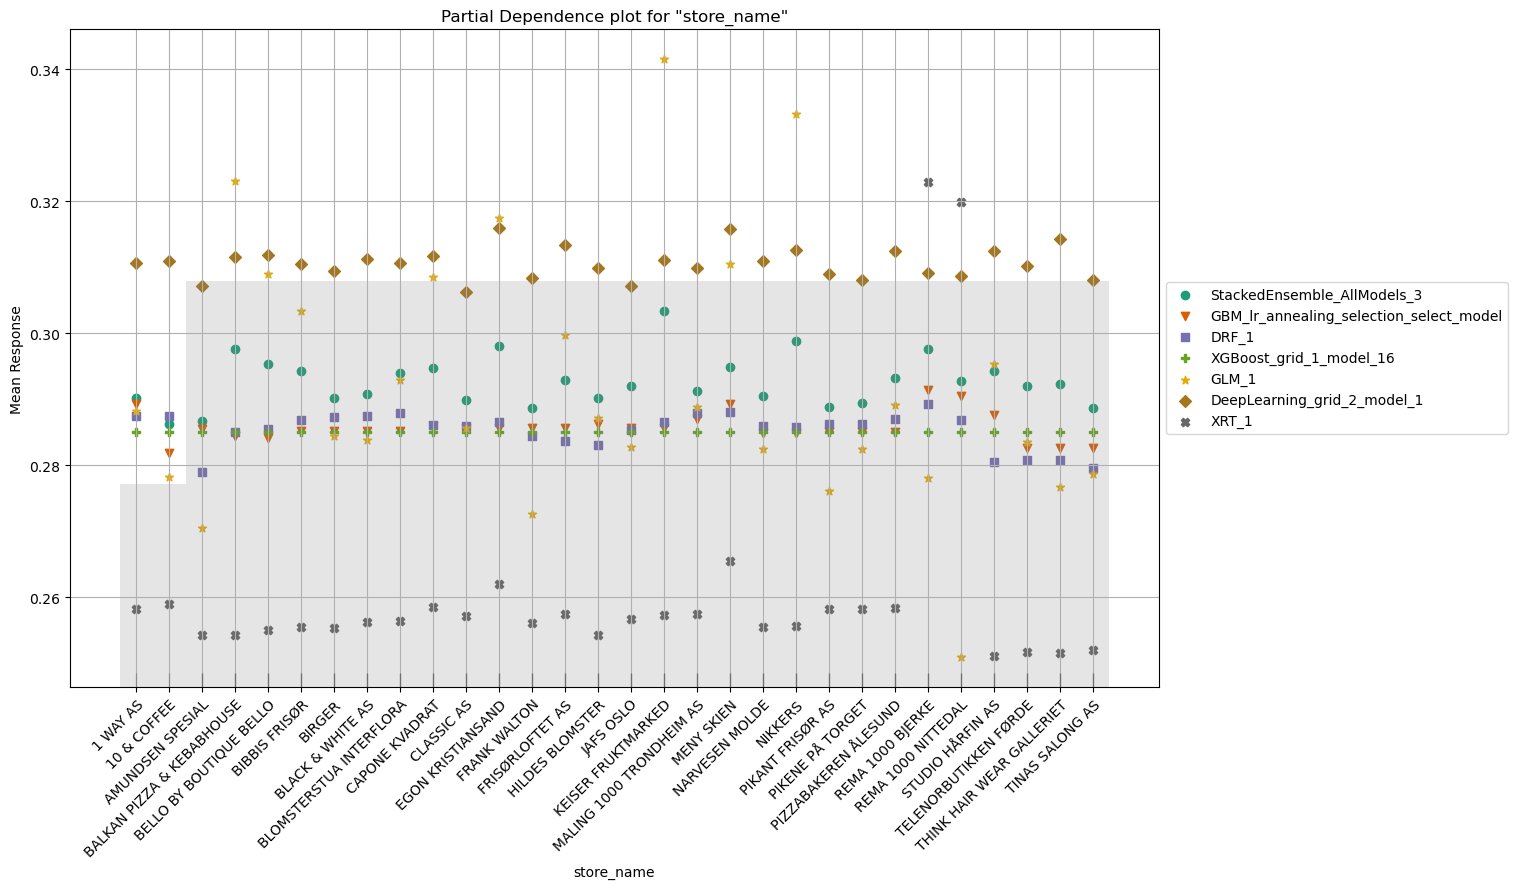

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

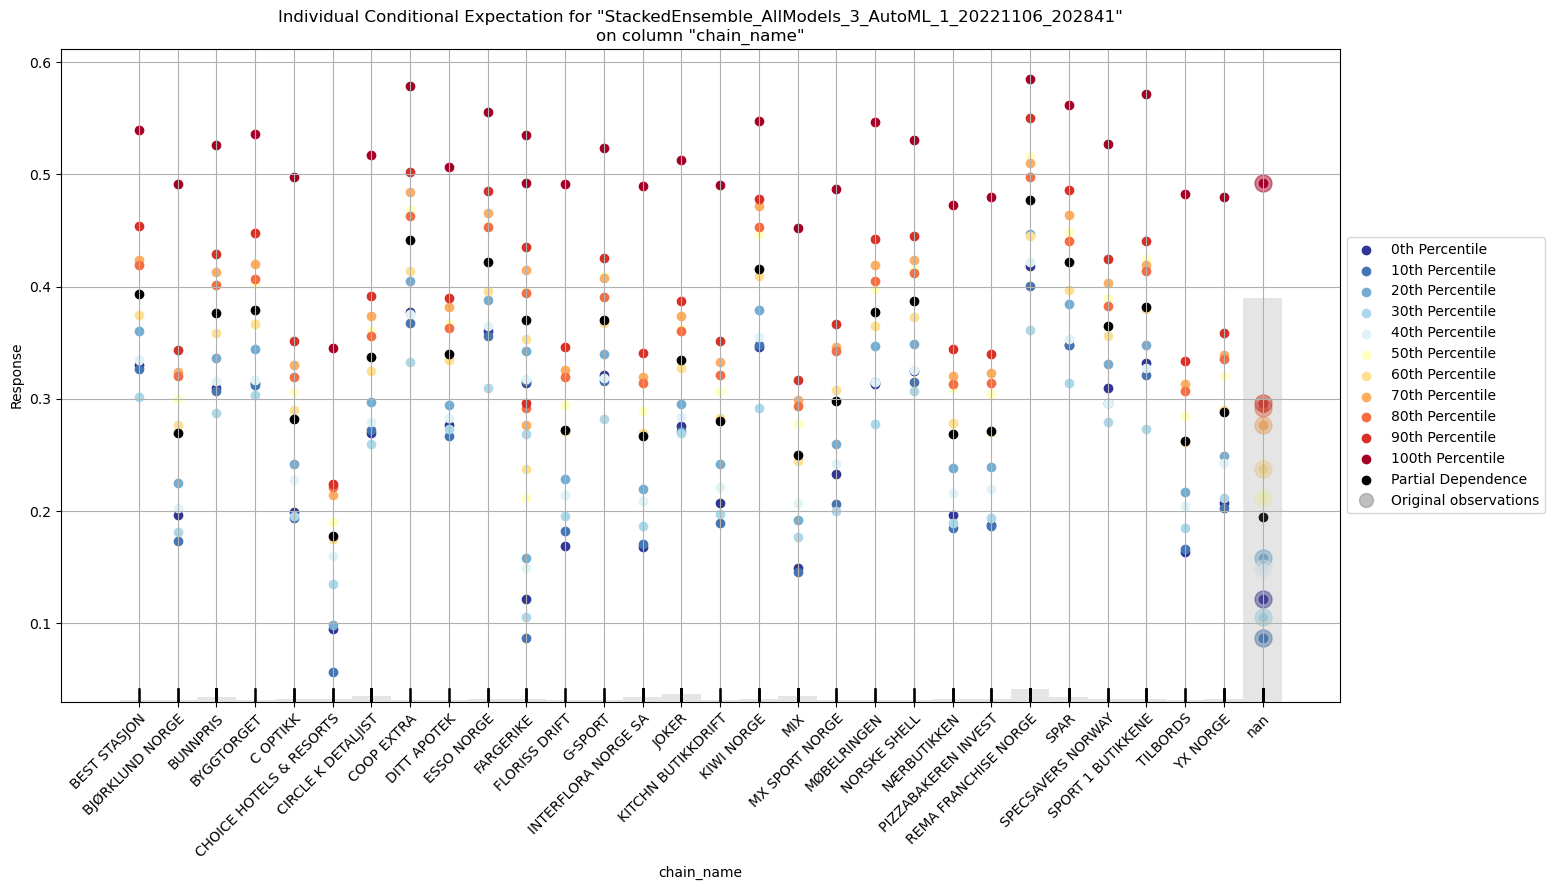

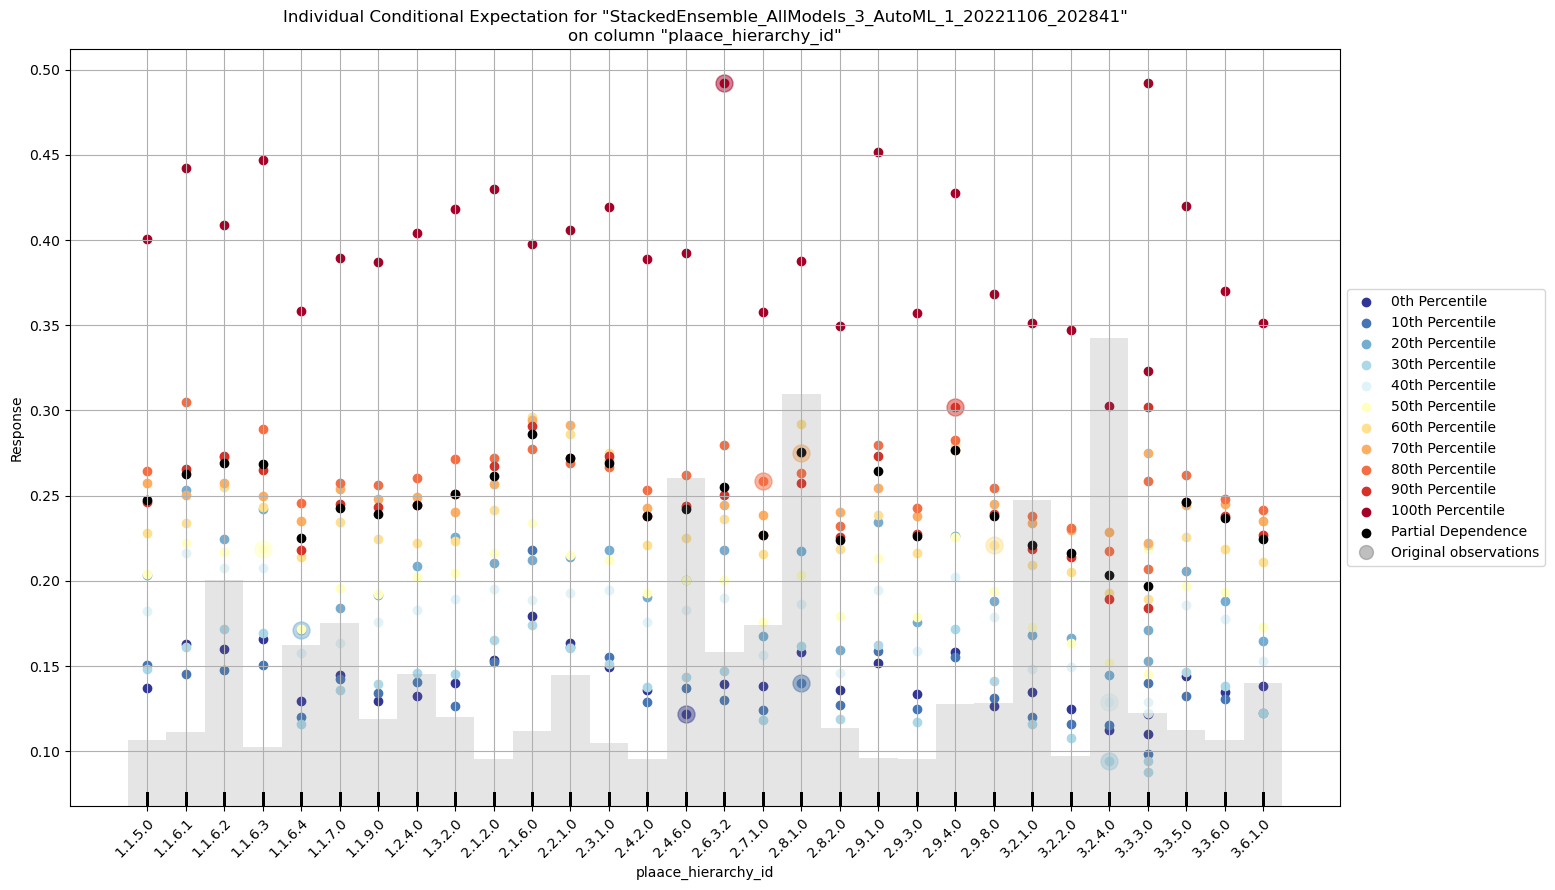

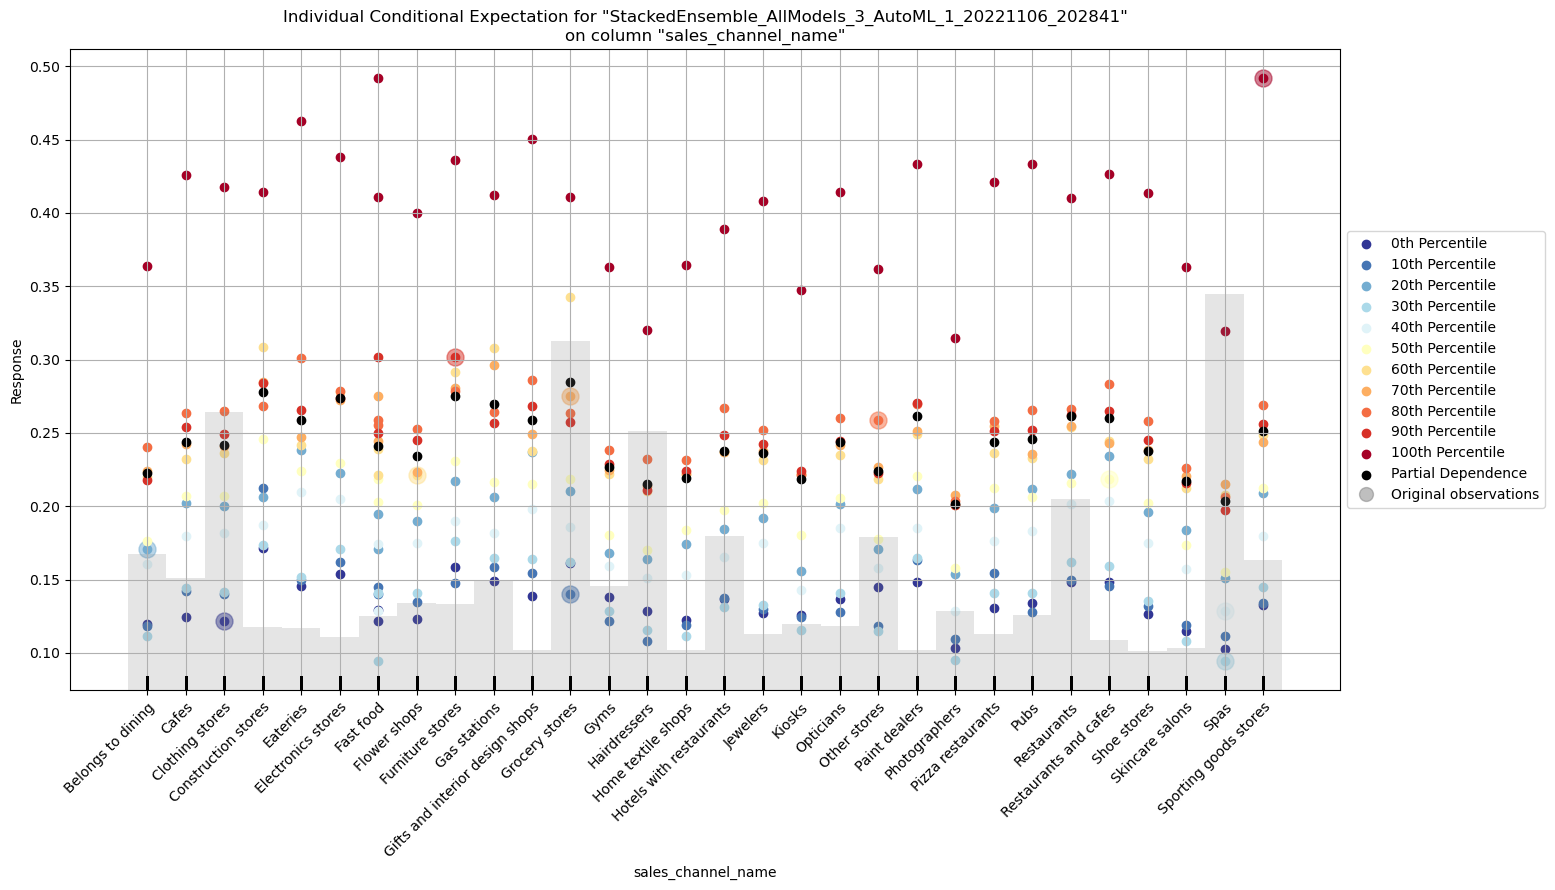

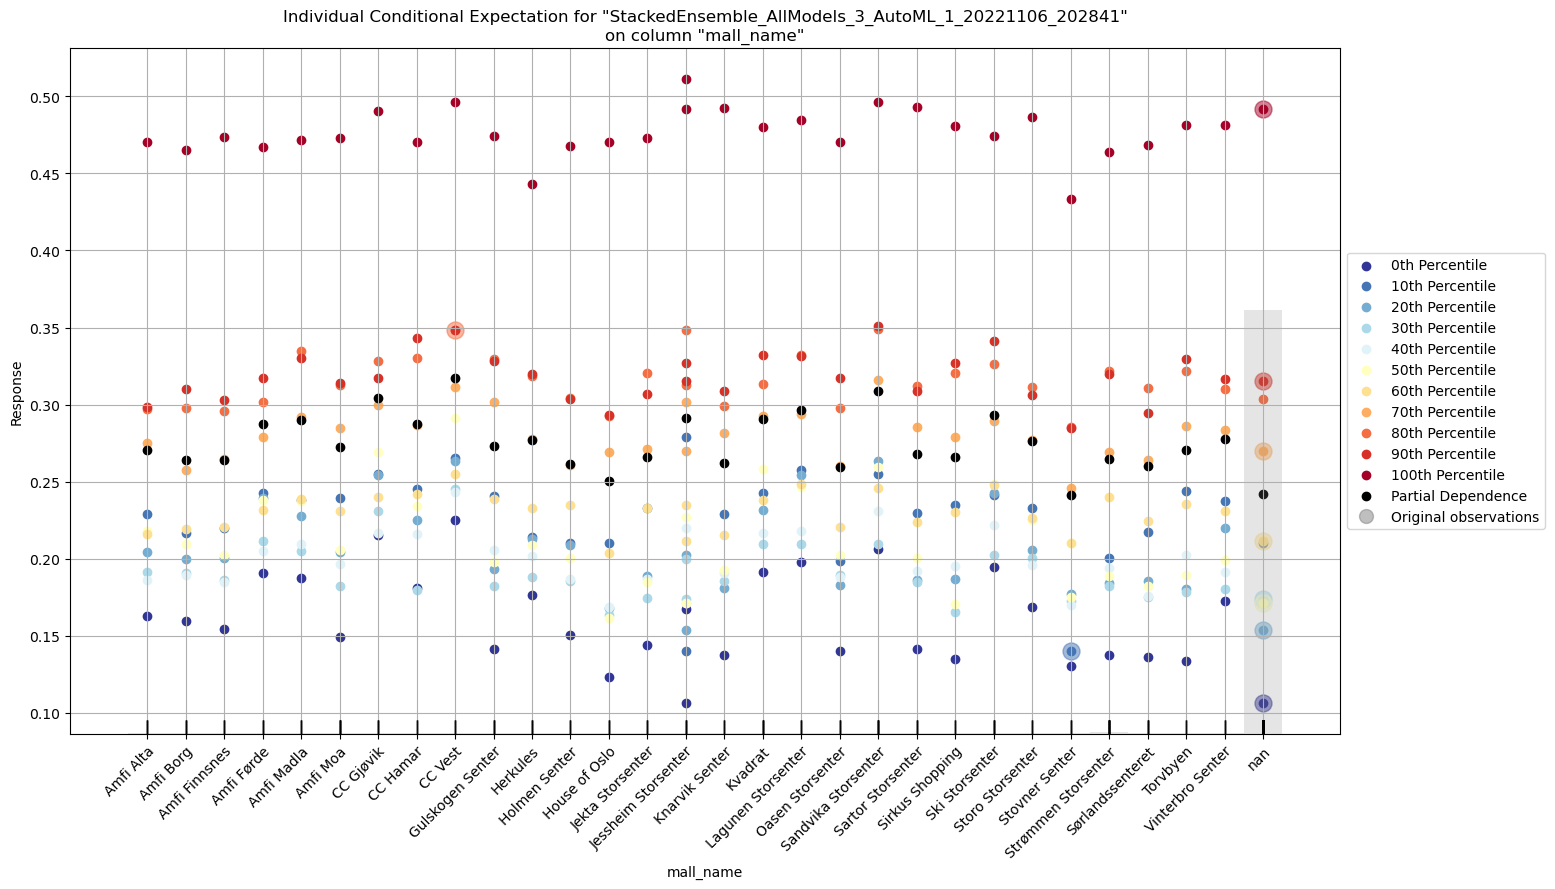

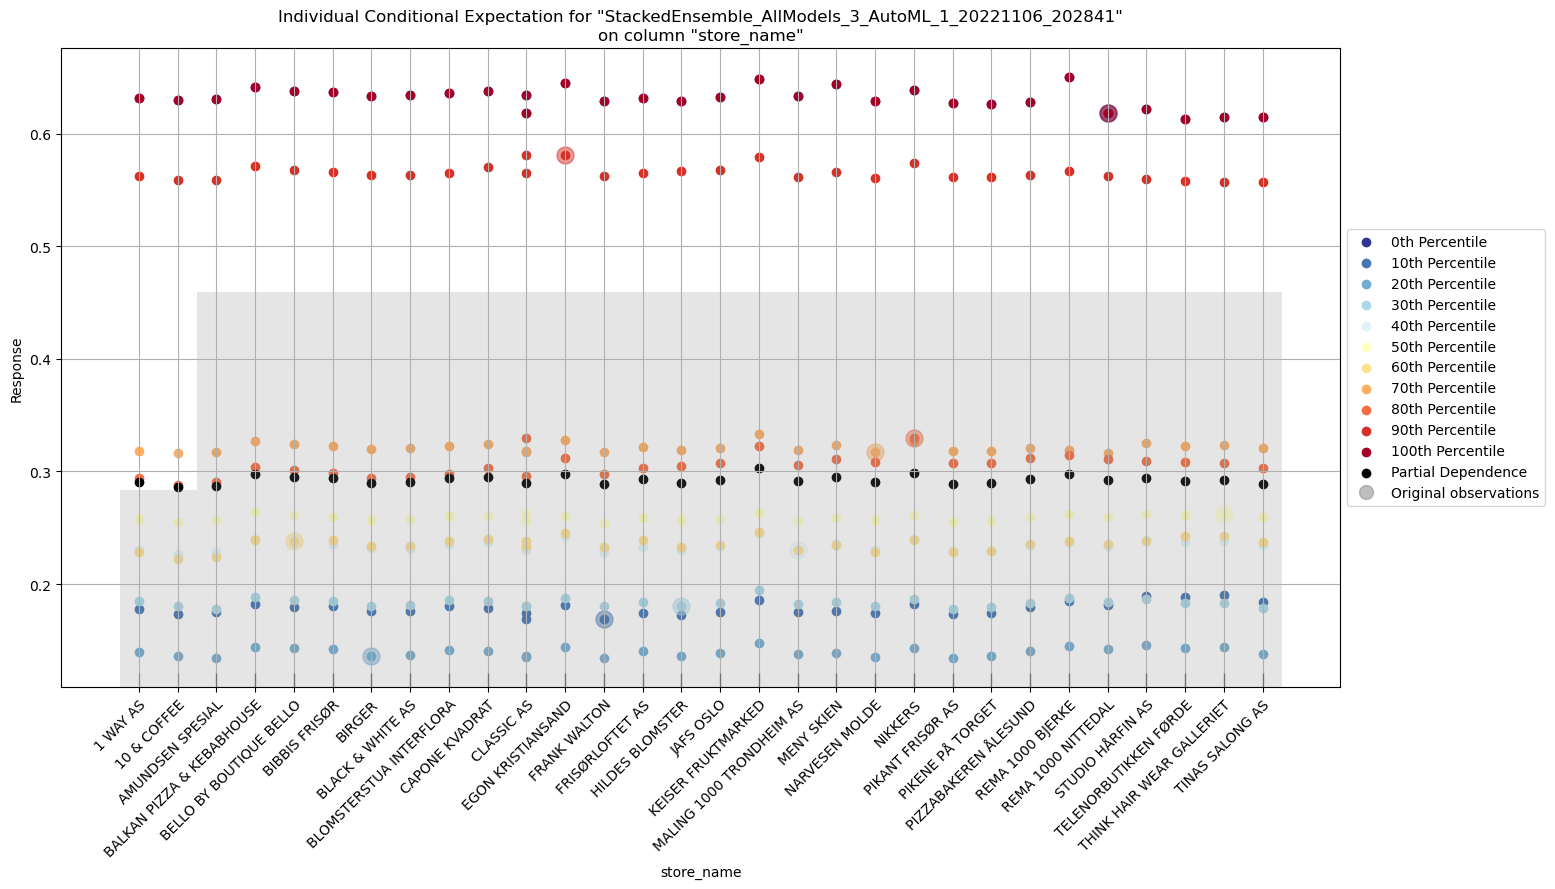

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                      rmse         mse        mae      rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------------------  ---------  ----------  ---------  ---------  ------------------------  ------------------  -------------------------  ---------------
DeepLearning_grid_1_AutoML_1_20221106_202841_model_1     0.0401889  0.00161514  0.0246431  0.0308117                0.00161514               76216                   0.823972  DeepLearning
GBM_grid_1_AutoML_1_20221106_202841_model_15             0.0422426  0.00178443  0.0287347  0.033689                 0.00178443                1564                   0.0143    GBM
GBM_grid_1_AutoML_1_20221106_202841_model_8              0.0426562  0.00181955  0.0308453  0.0349595                0.00181955                3011                   0.010667  GBM
GBM_grid_1_AutoML_1_20221106_202841_model_13             0.0537116  0.00288494  0.0408072  0.0433858                0.00288494                3527                   0.010181  GBM
DRF_1_AutoML_1_20221106_202841                           0.0565525  0.00319818  0.0425062  0.045241                 0.00319818               11095                   0.020307  DRF
GBM_grid_1_AutoML_1_20221106_202841_model_1              0.0565976  0.00320329  0.0393369  0.0447113                0.00320329                1456                   0.015466  GBM
GBM_grid_1_AutoML_1_20221106_202841_model_18             0.0589139  0.00347085  0.044483   0.047302                 0.00347085                1144                   0.012836  GBM
GBM_grid_1_AutoML_1_20221106_202841_model_5              0.0666208  0.00443834  0.0467443  0.0526596                0.00443834                2216                   0.009167  GBM
GBM_grid_1_AutoML_1_20221106_202841_model_10             0.0673117  0.00453087  0.0481429  0.0535346                0.00453087                1279                   0.010745  GBM
GBM_grid_1_AutoML_1_20221106_202841_model_21             0.072866   0.00530945  0.0534689  0.0588867                0.00530945                1399                   0.008433  GBM
GBM_grid_1_AutoML_1_20221106_202841_model_4              0.0742722  0.00551637  0.0525965  0.0583714                0.00551637                 977                   0.011324  GBM
GBM_grid_1_AutoML_1_20221106_202841_model_23             0.0774054  0.00599159  0.0554294  0.0617231                0.00599159                 936                   0.008067  GBM
XGBoost_grid_1_AutoML_1_20221106_202841_model_8          0.0780167  0.00608661  0.0618462  0.0636881                0.00608661               44651                   0.002927  XGBoost
StackedEnsemble_BestOfFamily_2_AutoML_1_20221106_202841  0.0831105  0.00690736  0.0622422  0.0658631                0.00690736                 342                   0.021801  StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20221106_202841     0.0861212  0.00741685  0.0646615  0.0684662                0.00741685                8853                   0.831941  StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20221106_202841     0.0861428  0.00742059  0.0643431  0.0684923                0.00742059                 335                   0.021821  StackedEnsemble
GBM_4_AutoML_1_20221106_202841                           0.0870066  0.00757016  0.0624855  0.0696326                0.00757016                 771                   0.008063  GBM
StackedEnsemble_AllModels_4_AutoML_1_20221106_202841     0.0870195  0.00757239  0.0655334  0.069244                 0.00757239                9022                   1.02176   StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20221106_202841  0.0877441  0.00769903  0.0664055  0.0698834                0.00769903                1208                   0.114399  StackedEnsemble
StackedEnsemble_AllModels_6_AutoML_1_20221106_202841     0.0881153  0.00776431  0.0667382  0.0702528                0.00776431                9375         

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [36]:
aml.explain(df)

# 15 - bus stop and stores distance feature engineering with more features and speed optimization

On the 7th of november, it was (temporarily) decided that the model runtime needed to be restricted. We therefore decided to try some speed optimization techniques. This would also help with faster testing in the future.

This was especially relevant for the bus stops engineering, which had the highes search space. We managed to optimize this using dataframes and lambda operations between columns.

In [1]:
# Import and init h2o lib. Running on java
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  -----------------------------
H2O_cluster_uptime:         16 hours 47 mins
H2O_cluster_timezone:       Europe/Oslo
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.1
H2O_cluster_version_age:    1 month and 19 days
H2O_cluster_name:           H2O_from_python_trymg_0954bv
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    7.818 Gb
H2O_cluster_total_cores:    24
H2O_cluster_allowed_cores:  24
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.10.6 final
--------------------------  -----------------------------

In [2]:
import numpy as np 

def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

### Read all data

In [3]:
import pandas as pd

stores_train = pd.read_csv('../data/stores_train.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_test = pd.read_csv('../data/stores_test.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_extra = pd.read_csv('../data/stores_extra.csv', engine="python", error_bad_lines=False, encoding='utf-8')
plaace_hierarchy = pd.read_csv('../data/plaace_hierarchy.csv', engine="python", error_bad_lines=False, encoding='utf-8')
busstops_norway = pd.read_csv('../data/busstops_norway.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_age_distribution = pd.read_csv('../data/grunnkrets_age_distribution.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_households_num_persons = pd.read_csv('../data/grunnkrets_households_num_persons.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_income_households = pd.read_csv('../data/grunnkrets_income_households.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_norway_stripped = pd.read_csv('../data/grunnkrets_norway_stripped.csv', engine="python", error_bad_lines=False, encoding='utf-8')

/tmp/ipykernel_250706/454644477.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  stores_train = pd.read_csv('../data/stores_train.csv', engine="python", error_bad_lines=False, encoding='utf-8')
/tmp/ipykernel_250706/454644477.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  stores_test = pd.read_csv('../data/stores_test.csv', engine="python", error_bad_lines=False, encoding='utf-8')
/tmp/ipykernel_250706/454644477.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  stores_extra = pd.read_csv('../data/stores_extra.csv', engine="python", error_bad_lines=False, encoding='utf-8')
/tmp/ipykernel_250706/454644477.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a

## bus stop engineering - speed optimized for stores x busstops

## haversine latlong distance calculation

In [4]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return km

## stores train

In [5]:
from tqdm import tqdm
import numpy as np

In [6]:
# Extract busstop coordinates and create df with only ['busstop_id', 'busstop_lat', 'busstop_lon']
new_busstops = busstops_norway.copy()
new_busstops['lonlat_list'] = busstops_norway['geometry'].map(lambda x: x[6:-1].split(' '))
new_busstops['busstop_lat'] = new_busstops['lonlat_list'].map(lambda x: float(x[1]))
new_busstops['busstop_lon'] = new_busstops['lonlat_list'].map(lambda x: float(x[0]))
new_busstops = new_busstops[['busstop_id', 'busstop_lat', 'busstop_lon']]

# new_stores = stores_train[['store_id', 'lat', 'lon']].append(stores_test[['store_id', 'lat', 'lon']], ignore_index=True)
new_stores_train = stores_train.copy()
new_stores_train = new_stores_train[['store_id', 'lat', 'lon']]

new_stores_train['busstop_distances'] = pd.Series(dtype='object')

for index, store in tqdm(new_stores_train.iterrows()):
    # if index == 10: break
    new_busstops['store_lat'] = store['lat']
    new_busstops['store_lon'] = store['lon']
    relevant_busstops = new_busstops[(abs(new_busstops['store_lat'] - new_busstops['busstop_lat']) < 1) & (abs(new_busstops['store_lon'] - new_busstops['busstop_lon']) < 1)]
    new_stores_train.at[index, 'busstop_distances'] = np.array(relevant_busstops.apply(lambda row: haversine(row['store_lat'], row['store_lon'], row['busstop_lat'], row['busstop_lon']), axis=1))
    new_stores_train.at[index, 'busstops_within_0_5_km'] = len(list(filter(lambda x: x < 0.5, new_stores_train.at[index, 'busstop_distances'])))
    new_stores_train.at[index, 'busstops_within_1_km'] = len(list(filter(lambda x: x < 1, new_stores_train.at[index, 'busstop_distances'])))
    new_stores_train.at[index, 'busstops_within_3_km'] = len(list(filter(lambda x: x < 3, new_stores_train.at[index, 'busstop_distances'])))
    new_stores_train.at[index, 'busstops_within_5_km'] = len(list(filter(lambda x: x < 5, new_stores_train.at[index, 'busstop_distances'])))
    new_stores_train.at[index, 'busstops_within_10_km'] = len(list(filter(lambda x: x < 10, new_stores_train.at[index, 'busstop_distances'])))

new_stores_train

2461it [04:25,  9.03it/s]

In [ ]:
stores_test.to_csv('../data/stores_train_busstop_distances.csv', index=False)

In [ ]:
new_stores_train = pd.read_csv('../data/stores_train_busstop_distances.csv', engine="python", error_bad_lines=False, encoding='utf-8')

/tmp/ipykernel_250291/1078444863.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  new_stores_train = pd.read_csv('../data/stores_train_busstop_distances.csv', engine="python", error_bad_lines=False, encoding='utf-8')


## stores test

In [ ]:
# Extract busstop coordinates and create df with only ['busstop_id', 'busstop_lat', 'busstop_lon']

new_busstops = busstops_norway.copy()
new_busstops['lonlat_list'] = busstops_norway['geometry'].map(lambda x: x[6:-1].split(' '))
new_busstops['busstop_lat'] = new_busstops['lonlat_list'].map(lambda x: float(x[1]))
new_busstops['busstop_lon'] = new_busstops['lonlat_list'].map(lambda x: float(x[0]))
new_busstops = new_busstops[['busstop_id', 'busstop_lat', 'busstop_lon']]

# new_stores = stores_train[['store_id', 'lat', 'lon']].append(stores_test[['store_id', 'lat', 'lon']], ignore_index=True)
new_stores_test = stores_train.copy()
new_stores_test = new_stores_test[['store_id', 'lat', 'lon']]

new_stores_test['busstop_distances'] = pd.Series(dtype='object')

for index, store in tqdm(new_stores_test.iterrows()):
    # if index == 10: break
    new_busstops['store_lat'] = store['lat']
    new_busstops['store_lon'] = store['lon']
    relevant_busstops = new_busstops[(abs(new_busstops['store_lat'] - new_busstops['busstop_lat']) < 1) & (abs(new_busstops['store_lon'] - new_busstops['busstop_lon']) < 1)]
    new_stores_test.at[index, 'busstop_distances'] = np.array(relevant_busstops.apply(lambda row: haversine(row['store_lat'], row['store_lon'], row['busstop_lat'], row['busstop_lon']), axis=1))
    new_stores_test.at[index, 'busstops_within_0_5_km'] = len(list(filter(lambda x: x < 0.5, new_stores_test.at[index, 'busstop_distances'])))
    new_stores_test.at[index, 'busstops_within_1_km'] = len(list(filter(lambda x: x < 1, new_stores_test.at[index, 'busstop_distances'])))
    new_stores_test.at[index, 'busstops_within_3_km'] = len(list(filter(lambda x: x < 3, new_stores_test.at[index, 'busstop_distances'])))
    new_stores_test.at[index, 'busstops_within_5_km'] = len(list(filter(lambda x: x < 5, new_stores_test.at[index, 'busstop_distances'])))
    new_stores_test.at[index, 'busstops_within_10_km'] = len(list(filter(lambda x: x < 10, new_stores_test.at[index, 'busstop_distances'])))

new_stores_test

10it [00:01,  9.68it/s]


store_id        lat        lon  \
0       983540538-974187930-44774  59.743104  10.204928   
1       987074191-973117734-44755  59.913759  10.734031   
2       984890265-981157303-64491  60.164751  10.254656   
3      914057442-992924179-126912  67.283669  14.379796   
4      913018583-913063538-668469  63.358068  10.374832   
...                           ...        ...        ...   
12854  915789943-915806929-781991  59.416276  10.480970   
12855  917921733-917982368-868081  60.799991  10.693635   
12856  911721961-911764474-496764  59.946562  11.007659   
12857  914337046-914343372-721294  58.850261   5.735674   
12858  917494436-917551936-851089  69.670422  19.042659   

                                       busstop_distances  \
0      [66.93297280812222, 66.93828906906987, 66.9437...   
1      [5.214933020448598, 5.2206355658637635, 5.2264...   
2      [63.614786400624475, 63.611851577982414, 63.60...   
3      [105.72463332880301, 105.70095806599575, 105.6...   
4      [134.8549224599188, 122.01353131945935, 134.28...   
...                                                  ...   
12854                                                NaN   
12855                                                NaN   
12856                                                NaN   
12857                                                NaN   
12858                                                NaN   

       busstops_within_0_5_km  busstops_within_1_km  busstops_within_3_km  \
0                         0.0                  10.0                  72.0   
1                        16.0                  30.0                 173.0   
2                         9.0                  14.0                  48.0   
3                         5.0                  11.0                  43.0   
4                         8.0                  29.0                 150.0   
...                       ...                   ...                   ...   
12854                     NaN                   NaN                   NaN   
12855                     NaN                   NaN                   NaN   
12856                     NaN                   NaN                   NaN   
12857                     NaN                   NaN                   NaN   
12858                     NaN                   NaN                   NaN   

       busstops_within_5_km  busstops_within_10_km  
0                     145.0                  429.0  
1                     328.0                  865.0  
2                      94.0                  193.0  
3                      90.0                  139.0  
4                     284.0                  687.0  
...                     ...                    ...  
12854                   NaN                    NaN  
12855                   NaN                    NaN  
12856                   NaN                    NaN  
12857                   NaN                    NaN  
12858                   NaN                    NaN  

[12859 rows x 9 columns]

In [ ]:
stores_test.to_csv('../data/stores_test_busstop_distances.csv', index=False)

In [ ]:
stores_test = pd.read_csv('../data/stores_test_busstop_distances.csv', engine="python", error_bad_lines=False, encoding='utf-8')

/tmp/ipykernel_250291/2619353580.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  stores_test = pd.read_csv('../data/stores_test_busstop_distances.csv', engine="python", error_bad_lines=False, encoding='utf-8')


## stores distances engineering

### train

In [ ]:
# Extract busstop coordinates and create df with only ['busstop_id', 'busstop_lat', 'busstop_lon']

other_stores_train = stores_train.copy()
# other_stores_train['lonlat_list'] = busstops_norway['geometry'].map(lambda x: x[6:-1].split(' '))
other_stores_train['other_store_lat'] = store['lat']
other_stores_train['other_store_lon'] = store['lon']
# other_stores_train['busstop_lat'] = other_stores_train['lonlat_list'].map(lambda x: float(x[1]))
# other_stores_train['busstop_lon'] = other_stores_train['lonlat_list'].map(lambda x: float(x[0]))
other_stores_train = other_stores_train[['store_id', 'other_store_lat', 'other_store_lon']]

# new_stores = stores_train[['store_id', 'lat', 'lon']].append(stores_test[['store_id', 'lat', 'lon']], ignore_index=True)
new_stores_train = stores_train.copy()
new_stores_train = new_stores_train[['store_id', 'lat', 'lon']]

new_stores_train['stores_distances'] = pd.Series(dtype='object')

for index, new_store_train in tqdm(new_stores_train.iterrows()):
    if index == 10: break
    other_stores_train['new_store_lat'] = new_store_train['lat']
    other_stores_train['new_store_lon'] = new_store_train['lon']
    relevant_other_stores = other_stores_train[(abs(other_stores_train['other_store_lat'] - other_stores_train['new_store_lat']) < 1) & (abs(other_stores_train['lon'] - other_stores_train['new_store_lon']) < 1)]
    new_stores_train.at[index, 'stores_distances'] = np.array(relevant_other_stores.apply(lambda row: haversine(row['store_lat'], row['lon'], row['other_store_lat'], row['other_store_lon']), axis=1))
    new_stores_train.at[index, 'busstops_within_0_5_km'] = len(list(filter(lambda x: x < 0.5, new_stores_train.at[index, 'stores_distances'])))
    new_stores_train.at[index, 'busstops_within_1_km'] = len(list(filter(lambda x: x < 1, new_stores_train.at[index, 'stores_distances'])))
    new_stores_train.at[index, 'busstops_within_3_km'] = len(list(filter(lambda x: x < 3, new_stores_train.at[index, 'stores_distances'])))
    new_stores_train.at[index, 'busstops_within_5_km'] = len(list(filter(lambda x: x < 5, new_stores_train.at[index, 'stores_distances'])))
    new_stores_train.at[index, 'busstops_within_10_km'] = len(list(filter(lambda x: x < 10, new_stores_train.at[index, 'stores_distances'])))

new_stores_train

In [ ]:
# save store x store distances

from tqdm import tqdm

stores = []
for i, store in tqdm(stores_train.iterrows()):

    distances_1_km = 0
    distances_5_km = 0
    distances_10_km = 0

    store_lat = store.lat
    store_lon = store.lon    

    for j, other_store in stores_train.iterrows():
        other_store_lat = other_store.lat
        other_store_lon = other_store.lon    
        
        distance = haversine(store_lon, store_lat, other_store_lon, other_store_lat) # km

        if distance < 10:
            distances_10_km += 1

        if distance < 5:
            distances_5_km += 1

        if distance < 1:
            distances_1_km += 1

    stores.append([distances_1_km, distances_5_km, distances_10_km])

In [ ]:
# save to csv

stores_distances = np.array(stores)

stores_train['stores_within_1km'] = stores_distances[:,0]
stores_train['stores_within_5km'] = stores_distances[:,1]
stores_train['stores_within_10km'] = stores_distances[:,2]

stores_train.to_csv('../data/stores_train_busstop_stores_distances.csv', index=False)

stores_train

In [ ]:
stores_train = pd.read_csv('../data/stores_train_busstop_stores_distances.csv', engine="python", error_bad_lines=False, encoding='utf-8')

## test

In [ ]:
# save store x store distances

from tqdm import tqdm

stores = []
for i, store in tqdm(stores_test.iterrows()):
    distances_1_km = 0
    distances_5_km = 0
    distances_10_km = 0

    store_lat = store.lat
    store_lon = store.lon    

    for j, other_store in stores_test.iterrows():
        other_store_lat = other_store.lat
        other_store_lon = other_store.lon    
        
        distance = haversine(store_lon, store_lat, other_store_lon, other_store_lat) # km
        
        if distance < 10:
            distances_10_km += 1

        if distance < 5:
            distances_5_km += 1

        if distance < 1:
            distances_1_km += 1

    stores.append([distances_1_km, distances_5_km, distances_10_km])

In [ ]:
# save to csv

stores_distances = np.array(stores)

stores_test['stores_within_1km'] = stores_distances[:,0]
stores_test['stores_within_5km'] = stores_distances[:,1]
stores_test['stores_within_10km'] = stores_distances[:,2]

stores_test.to_csv('../data/stores_test_busstop_stores_distances.csv', index=False)

stores_test

In [ ]:
# stores_test = pd.read_csv('../data/stores_test_busstop_stores_distances.csv', engine="python", error_bad_lines=False, encoding='utf-8')

### Merging datasets

In [ ]:
"""
Data cleaning
"""

# Remove 'year' column from stores since it only has one value
#stores_train.drop(['year'], axis=1, inplace=True)
#stores_test.drop(['year'], axis=1, inplace=True)
stores_extra.drop(['year'], axis=1, inplace=True)


# Remove all grunkretts from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_norway_stripped.drop(grunnkrets_norway_stripped[grunnkrets_norway_stripped['year'] != 2016].index, inplace=True)
grunnkrets_norway_stripped.drop(['year'], axis=1, inplace=True)


# Remove grunkrett age data from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_age_distribution.drop(grunnkrets_age_distribution[grunnkrets_age_distribution['year'] != 2016].index, inplace=True)
grunnkrets_age_distribution.drop(['year'], axis=1, inplace=True)

# Reduce age groups to children, teenager, adults
grunnkrets_age_distribution['children_age_distribution'] =  grunnkrets_age_distribution.iloc[:,2:8].sum(axis=1)
grunnkrets_age_distribution['teenagers_age_distribution'] =  grunnkrets_age_distribution.iloc[:,8:20].sum(axis=1)
grunnkrets_age_distribution['adults_age_distribution'] =  grunnkrets_age_distribution.iloc[:,20:].sum(axis=1)
grunnkrets_age_distribution = grunnkrets_age_distribution.loc[:, ["grunnkrets_id", "children_age_distribution", "teenagers_age_distribution", "adults_age_distribution"]]


# Remove grunkrets household data from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_households_num_persons.drop(grunnkrets_households_num_persons[grunnkrets_households_num_persons['year'] != 2016].index, inplace=True)
grunnkrets_households_num_persons.drop(['year'], axis=1, inplace=True)


# Remove grunkrets income data from 2015. Can't see how they would serve a purpose (for now)
grunnkrets_income_households.drop(grunnkrets_income_households[grunnkrets_income_households['year'] != 2016].index, inplace=True)
grunnkrets_income_households.drop(['year'], axis=1, inplace=True)



In [ ]:
# Merge all dataframes
merged = stores_train.merge(grunnkrets_norway_stripped,  how='left', on='grunnkrets_id')
merged = merged.merge(grunnkrets_age_distribution,       how='left', on='grunnkrets_id')
merged = merged.merge(grunnkrets_households_num_persons, how='left', on='grunnkrets_id')
merged = merged.merge(grunnkrets_income_households,      how='left', on='grunnkrets_id')
merged = merged.merge(plaace_hierarchy,                  how='left', on='plaace_hierarchy_id')

In [ ]:
# Merge test data
merged_test = stores_test.merge(grunnkrets_norway_stripped,        how='left', on='grunnkrets_id')
merged_test = merged_test.merge(grunnkrets_age_distribution,       how='left', on='grunnkrets_id')
merged_test = merged_test.merge(grunnkrets_households_num_persons, how='left', on='grunnkrets_id')
merged_test = merged_test.merge(grunnkrets_income_households,      how='left', on='grunnkrets_id')
merged_test = merged_test.merge(plaace_hierarchy,                  how='left', on='plaace_hierarchy_id')

In [ ]:
# TODO: Fix duplicate columns 'sales_channel_name_x', 'couple_without_children_x', 'singles_x'
merged = stores_train
merged_test = stores_test

list(merged.columns)

## revenue feature engineering

In [ ]:
import matplotlib.pyplot as plt

# Remove rows with revenue=0
merged = merged.loc[~(merged['revenue'] == 0)]
plt.hist(merged['revenue'], bins=100)
plt.show()

# Perform log transform on revenue
merged['revenue'] = merged['revenue'].map(lambda x: np.log(x+2))
plt.hist(merged['revenue'], bins=100)
plt.show()

# Normalize revenue between 0 and 1
min_revenue, max_revenue = merged['revenue'].min(), merged['revenue'].max()
merged['revenue'] = (merged['revenue'] - min_revenue) / (max_revenue - min_revenue)
plt.hist(merged['revenue'], bins=100)
plt.show()

# Normalize revenue between 0 and 1
#normalization_factor = merged['revenue'].abs().max()
#merged['revenue'] = merged['revenue'] / normalization_factor
#plt.hist(merged['revenue'], bins=100)
#plt.show()


# Inverse normalization
#merged['revenue'] = merged['revenue'] * (max_revenue - min_revenue) + min_revenue
#plt.hist(merged['revenue'], bins=100)
#plt.show()

# Inverse log transform
#merged['revenue'] = np.exp(merged['revenue'])
#plt.hist(merged['revenue'], bins=100)
#plt.show()

In [ ]:
merged['revenue']

### Building a Model


In [ ]:
df = h2o.H2OFrame(merged)
df_test = h2o.H2OFrame(merged_test)

In [ ]:
# Setting features as factor
catagorical_columns = ['store_name',
                       'plaace_hierarchy_id',
                       'sales_channel_name',
                       'grunnkrets_id',
                       'address',
                       'chain_name',
                       'mall_name']

for column in catagorical_columns:
    if column == 'lv2' or column == 'lv3' or column == 'lv4':
        continue
    df[column] = df[column].asfactor()
    df_test[column] = df_test[column].asfactor()

In [ ]:
# Removing labels from train set
y = "revenue"
x = df.columns
x.remove(y)

In [ ]:
# Running fit/training on train set with cross validation n=5
aml = H2OAutoML(seed = 1)
aml.train(x = x, y = y, training_frame = df)

In [ ]:
lb = aml.leaderboard
# Showing best perforimg models
lb.head()

### Creating a Submission

Finally, we used the "trained" model to make predictions on the test set and turn it into a submission for kaggle. The format for submissions is a simple csv file with two columns; one for the store id and one for the predicted revenue.
An example of what the start of the file should look like can be seen below:


```
id,predicted
914206820-914239427-717245,181.66162783399506
916789157-916823770-824309,206.81469433388355
913341082-977479363-2948,83.49386666841214
...
```

Keep in mind the following when generating predictions:
- Make sure that the csv  <id, predicted> columns.
- Make sure that the ID values correctly correspond to each prediction. 
- Make sure there are no negative, nan, or other non-numeric values in your submission 


In [ ]:
def inverse_log_transform(column: pd.Series):
    return np.exp(column).map(lambda x: x - 2)

In [ ]:
# Predict on the test set
#preds = aml.predict(df_test)
preds = aml.get_best_model(criterion="RMSLE").predict(df_test)
preds = h2o.as_list(preds)

# Inverse normalization
preds['predict'] = preds['predict'] * (max_revenue - min_revenue) + min_revenue
#preds['predict'] = preds['predict'] * normalization_factor

# Inverse log transform
# preds['predict'] = np.exp(preds['predict'])
preds['predict'] = inverse_log_transform(preds['predict'])

# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = stores_test.store_id 
submission['predicted'] = np.asarray(preds)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('sample_submission.csv', index=False)
submission

In [ ]:
aml.explain(df)

# 16 - Faster busstop and store-to-store distance calculations and better distance features

In addition to the store-to-busstop distance calculation speed optimization, the store-to-store distance calculation has also been optimized the same way. The combined runtime of both distance calculations has been brought down to approximately 1 hour. This allowed us to more thoroughly test different combinations of the distance features to find the one producing the best results. 

By doing this, we were able to test multiple different combinations of radiuses for both store-to-store and store-to-busstop distances, and used the one with the best score.

In addition, we mad sure that the result was reproducable by including "max_models" and "seed" as training parameters.

In [22]:
# Import and init h2o lib. Running on java
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ------------------------------
H2O_cluster_uptime:         2 hours 48 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.1
H2O_cluster_version_age:    1 month and 23 days
H2O_cluster_name:           H2O_from_python_jupyter_okcnnb
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    931 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.7.12 final
--------------------------  ------------------------------

### Read all data

In [23]:
import pandas as pd

stores_train = pd.read_csv('data/stores_train.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_test = pd.read_csv('data/stores_test.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_extra = pd.read_csv('data/stores_extra.csv', engine="python", error_bad_lines=False, encoding='utf-8')
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv', engine="python", error_bad_lines=False, encoding='utf-8')
busstops_norway = pd.read_csv('data/busstops_norway.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_age_distribution = pd.read_csv('data/grunnkrets_age_distribution.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_households_num_persons = pd.read_csv('data/grunnkrets_households_num_persons.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_income_households = pd.read_csv('data/grunnkrets_income_households.csv', engine="python", error_bad_lines=False, encoding='utf-8')

Skipping line 12465: unexpected end of data


## Feature engineering: Calculate distances between all stores and busstops

Create a dataset with one row for each store (both from stores_train and stores_test) containing information about the amount of busstops and different stores nearby. This dataframe can be used as a look-up table for when generating the final dataset to train on.

#### haversine latlong distance calculation

In [3]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return round(km, 3)

In [4]:
from tqdm import tqdm
import numpy as np

# Extract busstop coordinates and create df with only ['busstop_id', 'busstop_lat', 'busstop_lon']
df_busstop_coordinates = busstops_norway.copy()
df_busstop_coordinates['lonlat_list'] = busstops_norway['geometry'].map(lambda x: x[6:-1].split(' '))
df_busstop_coordinates['busstop_lat'] = df_busstop_coordinates['lonlat_list'].map(lambda x: float(x[1]))
df_busstop_coordinates['busstop_lon'] = df_busstop_coordinates['lonlat_list'].map(lambda x: float(x[0]))
df_busstop_coordinates = df_busstop_coordinates[['busstop_id', 'busstop_lat', 'busstop_lon']]

# Initialize the df_stores_distances dataframe with all stores from both stores_train and stores_test. Only with ['store_id', 'lat', 'lon'] for now
df_stores_distances = stores_train[['store_id', 'lat', 'lon']].append(stores_test[['store_id', 'lat', 'lon']], ignore_index=True)

# Create temp column to hold all calculated busstop distances in long lists
df_stores_distances['busstop_distances'] = pd.Series(dtype='object')

# Iterate over all stores in 'df_stores_distances' (stores used for training and testing)
for index, store in tqdm(df_stores_distances.iterrows()):
    #if index == 10: break
    
    # Remove busstops that are more than half a degree lat or half a degree longitude away to reduce computational strain
    df_busstop_coordinates['store_lat'] = store['lat']
    df_busstop_coordinates['store_lon'] = store['lon']
    df_relevant_busstops = df_busstop_coordinates[(abs(df_busstop_coordinates['store_lat'] - df_busstop_coordinates['busstop_lat']) < 0.5) & (abs(df_busstop_coordinates['store_lon'] - df_busstop_coordinates['busstop_lon']) < 0.5)]
    
    # Calculate all distances from the current 'store' to each busstop in 'df_relevant_busstops'. Then, assign distances to relevant cell in 'df_stores_distances'
    list_of_distances = np.array(df_relevant_busstops.apply(lambda row: haversine(store['lat'], store['lon'], row['busstop_lat'], row['busstop_lon']), axis=1))
    df_stores_distances.at[index, 'busstop_distances'] = list_of_distances
    
    # Find number of busstops within certain distances and populate relevant columns
    df_stores_distances.at[index, 'busstops_within_0_5_km'] = len(list(filter(lambda x: x < 0.5, df_stores_distances.at[index, 'busstop_distances'])))
    df_stores_distances.at[index, 'busstops_within_1_km'] = len(list(filter(lambda x: x < 1, df_stores_distances.at[index, 'busstop_distances'])))
    df_stores_distances.at[index, 'busstops_within_3_km'] = len(list(filter(lambda x: x < 3, df_stores_distances.at[index, 'busstop_distances'])))
    df_stores_distances.at[index, 'busstops_within_5_km'] = len(list(filter(lambda x: x < 5, df_stores_distances.at[index, 'busstop_distances'])))
    df_stores_distances.at[index, 'busstops_within_10_km'] = len(list(filter(lambda x: x < 10, df_stores_distances.at[index, 'busstop_distances'])))

# The dataframe 'df_stores_distances' can now be used as a lookup-table to find number of nearby busstops for each store
df_stores_distances

21436it [28:48, 12.40it/s]


store_id        lat        lon  \
0       983540538-974187930-44774  59.743104  10.204928   
1       987074191-973117734-44755  59.913759  10.734031   
2       984890265-981157303-64491  60.164751  10.254656   
3      914057442-992924179-126912  67.283669  14.379796   
4      913018583-913063538-668469  63.358068  10.374832   
...                           ...        ...        ...   
21431  917323003-917383529-844309  59.259575   5.325813   
21432  917353379-917411824-845904  58.976219   5.721546   
21433  917072302-917089248-833647  59.928330  11.163202   
21434  916960557-916993161-829908  60.445790   5.161587   
21435   987280891-972040746-45320  59.097903   9.055490   

                                       busstop_distances  \
0      [70.566, 64.002, 63.796, 55.469, 63.691, 60.79...   
1      [5.215, 5.221, 5.226, 5.237, 5.241, 2.792, 2.7...   
2      [57.171, 57.171, 56.917, 56.838, 37.002, 53.34...   
3      [42.919, 42.909, 24.212, 41.574, 21.112, 7.203...   
4      [37.087, 37.087, 16.381, 16.557, 17.093, 17.21...   
...                                                  ...   
21431  [35.09, 50.967, 49.634, 47.725, 61.199, 61.186...   
21432  [34.243, 10.63, 10.6, 10.34, 10.312, 11.298, 5...   
21433  [42.818, 42.816, 42.814, 42.811, 42.809, 50.09...   
21434  [24.034, 24.428, 22.436, 10.54, 42.328, 17.934...   
21435  [33.773, 52.221, 52.046, 52.627, 52.688, 54.00...   

       busstops_within_0_5_km  busstops_within_1_km  busstops_within_3_km  \
0                         0.0                  10.0                  72.0   
1                        16.0                  30.0                 172.0   
2                         9.0                  14.0                  48.0   
3                         5.0                  11.0                  43.0   
4                         8.0                  29.0                 150.0   
...                       ...                   ...                   ...   
21431                     4.0                   9.0                  25.0   
21432                     7.0                  28.0                 227.0   
21433                     5.0                   6.0                  31.0   
21434                     4.0                   8.0                  38.0   
21435                     4.0                   4.0                  10.0   

       busstops_within_5_km  busstops_within_10_km  
0                     145.0                  429.0  
1                     328.0                  865.0  
2                      94.0                  193.0  
3                      90.0                  139.0  
4                     284.0                  687.0  
...                     ...                    ...  
21431                  49.0                  129.0  
21432                 449.0                  815.0  
21433                  48.0                  104.0  
21434                  84.0                  399.0  
21435                  16.0                   29.0  

[21436 rows x 9 columns]

## Stores distances engineering

In [5]:
# Create dataframe with all provided stores and their coordinates ['store_id', 'lat', 'lon']
df_all_stores_coordinates = stores_train[['store_id', 'lat', 'lon']].append(stores_test[['store_id', 'lat', 'lon']], ignore_index=True).append(stores_extra[['store_id', 'lat', 'lon']], ignore_index=True)

# The same 'df_stores_distances' as before will be used to store the distances between stores
df_stores_distances = df_stores_distances

# Create temp column to hold all calculated store-to-store distances in long lists
df_stores_distances['store_to_store_distances'] = pd.Series(dtype='object')

# Iterate over all stores in 'df_stores_distances' (stores used for training and testing)
for index, store in tqdm(df_stores_distances.iterrows()):
    #if index == 10: break
    
    # Remove stores that are more than half a degree lat or half a degree longitude away to reduce computational strain
    df_all_stores_coordinates['store_lat'] = store['lat']
    df_all_stores_coordinates['store_lon'] = store['lon']
    df_relevant_stores = df_all_stores_coordinates[(abs(df_all_stores_coordinates['store_lat'] - df_all_stores_coordinates['lat']) < 0.5) & (abs(df_all_stores_coordinates['store_lon'] - df_all_stores_coordinates['lon']) < 0.5)]
    
    # Calculate all distances from the current 'store' to each other store in 'df_relevant_busstops'. Then, assign distances to relevant cell in 'df_stores_distances'
    list_of_distances = np.array(df_relevant_stores.apply(lambda row: haversine(store['lat'], store['lon'], row['lat'], row['lon']), axis=1))
    df_stores_distances.at[index, 'store_to_store_distances'] = list_of_distances
    
    # Find number of other stores within certain distances and populate relevant columns
    df_stores_distances.at[index, 'stores_within_0_5_km'] = len(list(filter(lambda x: x < 0.5, df_stores_distances.at[index, 'store_to_store_distances'])))
    df_stores_distances.at[index, 'stores_within_1_km'] = len(list(filter(lambda x: x < 1, df_stores_distances.at[index, 'store_to_store_distances'])))
    df_stores_distances.at[index, 'stores_within_3_km'] = len(list(filter(lambda x: x < 3, df_stores_distances.at[index, 'store_to_store_distances'])))
    df_stores_distances.at[index, 'stores_within_5_km'] = len(list(filter(lambda x: x < 5, df_stores_distances.at[index, 'store_to_store_distances'])))
    df_stores_distances.at[index, 'stores_within_10_km'] = len(list(filter(lambda x: x < 10, df_stores_distances.at[index, 'store_to_store_distances'])))

# The dataframe 'df_stores_distances' can now be used as a lookup-table to find number of nearby other stores for each store
df_stores_distances

21436it [40:30,  8.82it/s]


store_id        lat        lon  \
0       983540538-974187930-44774  59.743104  10.204928   
1       987074191-973117734-44755  59.913759  10.734031   
2       984890265-981157303-64491  60.164751  10.254656   
3      914057442-992924179-126912  67.283669  14.379796   
4      913018583-913063538-668469  63.358068  10.374832   
...                           ...        ...        ...   
21431  917323003-917383529-844309  59.259575   5.325813   
21432  917353379-917411824-845904  58.976219   5.721546   
21433  917072302-917089248-833647  59.928330  11.163202   
21434  916960557-916993161-829908  60.445790   5.161587   
21435   987280891-972040746-45320  59.097903   9.055490   

                                       busstop_distances  \
0      [70.566, 64.002, 63.796, 55.469, 63.691, 60.79...   
1      [5.215, 5.221, 5.226, 5.237, 5.241, 2.792, 2.7...   
2      [57.171, 57.171, 56.917, 56.838, 37.002, 53.34...   
3      [42.919, 42.909, 24.212, 41.574, 21.112, 7.203...   
4      [37.087, 37.087, 16.381, 16.557, 17.093, 17.21...   
...                                                  ...   
21431  [35.09, 50.967, 49.634, 47.725, 61.199, 61.186...   
21432  [34.243, 10.63, 10.6, 10.34, 10.312, 11.298, 5...   
21433  [42.818, 42.816, 42.814, 42.811, 42.809, 50.09...   
21434  [24.034, 24.428, 22.436, 10.54, 42.328, 17.934...   
21435  [33.773, 52.221, 52.046, 52.627, 52.688, 54.00...   

       busstops_within_0_5_km  busstops_within_1_km  busstops_within_3_km  \
0                         0.0                  10.0                  72.0   
1                        16.0                  30.0                 172.0   
2                         9.0                  14.0                  48.0   
3                         5.0                  11.0                  43.0   
4                         8.0                  29.0                 150.0   
...                       ...                   ...                   ...   
21431                     4.0                   9.0                  25.0   
21432                     7.0                  28.0                 227.0   
21433                     5.0                   6.0                  31.0   
21434                     4.0                   8.0                  38.0   
21435                     4.0                   4.0                  10.0   

       busstops_within_5_km  busstops_within_10_km  \
0                     145.0                  429.0   
1                     328.0                  865.0   
2                      94.0                  193.0   
3                      90.0                  139.0   
4                     284.0                  687.0   
...                     ...                    ...   
21431                  49.0                  129.0   
21432                 449.0                  815.0   
21433                  48.0                  104.0   
21434                  84.0                  399.0   
21435                  16.0                   29.0   

                                store_to_store_distances  \
0      [0.0, 46.47, 56.881, 58.81, 58.133, 31.476, 56...   
1      [0.0, 59.953, 24.266, 3.233, 2.988, 1.831, 2.0...   
2      [46.47, 59.953, 0.0, 61.558, 58.062, 60.778, 5...   
3      [0.0, 4.809, 0.264, 1.124, 0.216, 0.037, 21.71...   
4      [0.0, 5.683, 8.753, 8.572, 18.066, 12.297, 8.2...   
...                                                  ...   
21431  [55.341, 55.272, 55.747, 56.408, 58.05, 75.473...   
21432  [1.311, 1.242, 1.815, 2.512, 9.166, 23.419, 13...   
21433  [47.748, 23.484, 44.545, 44.96, 45.917, 49.719...   
21434  [18.197, 19.022, 18.701, 10.529, 33.507, 23.87...   
21435  [55.027, 22.347, 37.131, 34.776, 45.918, 37.13...   

       stores_within_0_5_km  stores_within_1_km  stores_within_3_km  \
0                     257.0               371.0               532.0   
1                     241.0               822.0              3339.0   
2                     159.0               174.0               258.0   
3               

### Attach busstop distance and store-to-store distance columns to main dataset

In [54]:
columns_to_add = df_stores_distances[['store_id',
                                      'busstops_within_0_5_km',
                                      'busstops_within_1_km',
                                      'busstops_within_3_km',
                                      'busstops_within_5_km',
                                      'busstops_within_10_km',
                                      'stores_within_0_5_km',
                                      'stores_within_1_km',
                                      'stores_within_3_km',
                                      'stores_within_5_km',
                                      'stores_within_10_km',
                                     ]]

merged = stores_train.merge(columns_to_add,  how='left', on='store_id')
merged_test = stores_test.merge(columns_to_add,  how='left', on='store_id')

list(merged.columns)

['store_id',
 'year',
 'store_name',
 'plaace_hierarchy_id',
 'sales_channel_name',
 'grunnkrets_id',
 'address',
 'lat',
 'lon',
 'chain_name',
 'mall_name',
 'revenue',
 'busstops_within_0_5_km',
 'busstops_within_1_km',
 'busstops_within_3_km',
 'busstops_within_5_km',
 'busstops_within_10_km',
 'stores_within_0_5_km',
 'stores_within_1_km',
 'stores_within_3_km',
 'stores_within_5_km',
 'stores_within_10_km']

## revenue feature engineering

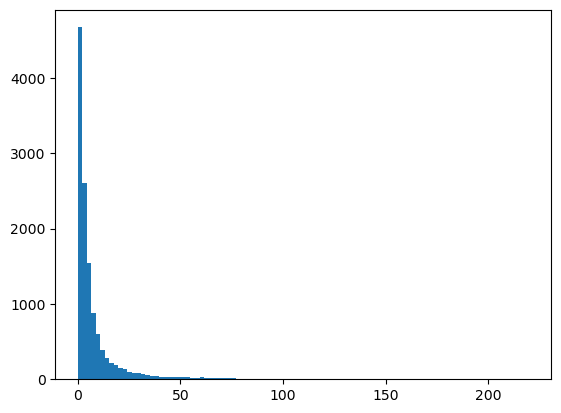

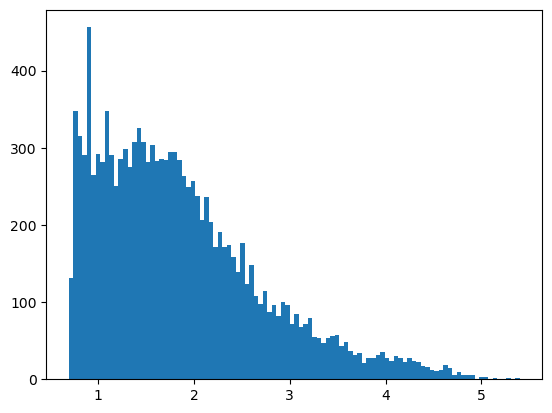

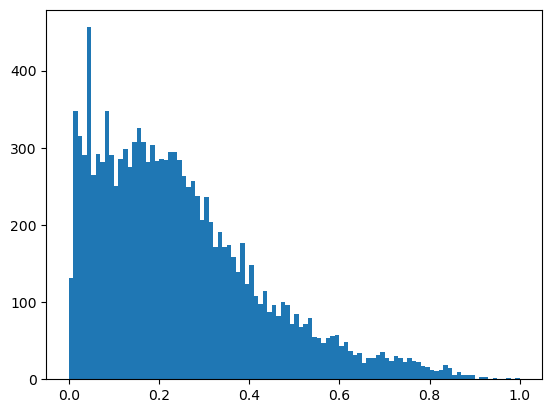

In [55]:
import matplotlib.pyplot as plt

# Remove rows with revenue=0
merged = merged.loc[~(merged['revenue'] == 0)]
plt.hist(merged['revenue'], bins=100)
plt.show()

# Perform log transform on revenue
merged['revenue'] = merged['revenue'].map(lambda x: np.log(x+2))
plt.hist(merged['revenue'], bins=100)
plt.show()

# Normalize revenue between 0 and 1
min_revenue, max_revenue = merged['revenue'].min(), merged['revenue'].max()
merged['revenue'] = (merged['revenue'] - min_revenue) / (max_revenue - min_revenue)
plt.hist(merged['revenue'], bins=100)
plt.show()

# Inverse normalization
#merged['revenue'] = merged['revenue'] * (max_revenue - min_revenue) + min_revenue
#plt.hist(merged['revenue'], bins=100)
#plt.show()

# Inverse log transform
#merged['revenue'] = np.exp(merged['revenue'])
#plt.hist(merged['revenue'], bins=100)
#plt.show()

### Building a Model


In [56]:
df = h2o.H2OFrame(merged)
df_test = h2o.H2OFrame(merged_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [57]:
# Setting features as factor
catagorical_columns = ['store_name',
                       'plaace_hierarchy_id',
                       'sales_channel_name',
                       'grunnkrets_id',
                       'address',
                       'chain_name',
                       'mall_name']

for column in catagorical_columns:
    if column == 'lv2' or column == 'lv3' or column == 'lv4':
        continue
    df[column] = df[column].asfactor()
    df_test[column] = df_test[column].asfactor()

In [58]:
# Removing labels from train set
y = "revenue"
x = df.columns
x.remove(y)

In [59]:
# Running fit/training on train set with cross validation n=5
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(x = x, y = y, training_frame = df)

AutoML progress: |
14:29:30.824: _train param, Dropping bad and constant columns: [store_id, year]

███
14:29:54.706: _train param, Dropping bad and constant columns: [store_id, year]

█████████████
14:31:30.883: _train param, Dropping bad and constant columns: [store_id, year]

█
14:31:48.568: _train param, Dropping bad and constant columns: [store_id, year]

█
14:32:08.633: _train param, Dropping bad and constant columns: [store_id, year]

█████████████████
14:36:52.822: _train param, Dropping bad and constant columns: [store_id, year]

█
14:37:06.737: _train param, Dropping bad and constant columns: [store_id, year]

█
14:37:22.83: _train param, Dropping bad and constant columns: [store_id, year]


14:37:42.559: _train param, Dropping bad and constant columns: [store_id, year]

█
14:38:07.561: _train param, Dropping bad and constant columns: [store_id, year]

██████
14:41:39.233: _train param, Dropping bad and constant columns: [store_id, year]


14:41:51.140: _train param, Dropping

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_6_20221112_142930

No summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.00799976736660712
RMSE: 0.08944141863033658
MAE: 0.06643794317806846
RMSLE: 0.07123665465360023
Mean Residual Deviance: 0.00799976736660712
R^2: 0.7577303340696095
Null degrees of freedom: 10050
Residual degrees of freedom: 10036
Null deviance: 331.886637187441
Residual deviance: 80.40566180176816
AIC: -19974.171258173716

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.014200393096848823
RMSE: 0.11916540226445267
MAE: 0.08932605466681662
RMSLE: 0.09375782842949679
Mean Residual Deviance: 0.014200393096848823
R^2: 0.5710408464296848
Null degrees of freedom: 12641
Residual degrees of freedom: 12630
Null deviance: 418.5115641885422
Residual deviance: 179.52136953036282
AIC: -17882.765484697815

Cross-Validation Metrics Summary: 
                        mean       sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     0.0894035  0.00117945   0.0909261     0.087795      0.0899579     0.0888218     0.0895167
mean_residual_deviance  0.0141995  0.000174252  0.014418      0.0139863     0.0142221     0.0143026     0.0140686
mse                     0.0141995  0.000174252  0.014418      0.0139863     0.0142221     0.0143026     0.0140686
null_deviance           83.7023    2.46313      87.0168       81.7855       83.2465       85.3476       81.1152
r2                      0.571006   0.00874796   0.572341      0.565099      0.560553      0.573653      0.583382
residual_deviance       35.9076    1.32018      37.2128       35.5672       36.5793       36.3858       33.7928
rmse                    0.11916    0.000731218  0.120075      0.118264      0.119257      0.119593      0.118611
rmsle                   0.0937582  0.000587158  0.0945522     0.0930269     0.0941039     0.0936274     0.0934806

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [60]:
lb = aml.leaderboard
# Showing best perforimg models
lb.head()

model_id                                                     rmse        mse        mae      rmsle    mean_residual_deviance
-------------------------------------------------------  --------  ---------  ---------  ---------  ------------------------
StackedEnsemble_AllModels_1_AutoML_6_20221112_142930     0.119165  0.0142004  0.0893261  0.0937578                 0.0142004
StackedEnsemble_BestOfFamily_1_AutoML_6_20221112_142930  0.119295  0.0142313  0.0894489  0.0938624                 0.0142313
GBM_5_AutoML_6_20221112_142930                           0.120639  0.0145537  0.0904751  0.0949231                 0.0145537
GBM_1_AutoML_6_20221112_142930                           0.120873  0.0146104  0.090812   0.0950419                 0.0146104
GBM_2_AutoML_6_20221112_142930                           0.120972  0.0146343  0.0907669  0.0951048                 0.0146343
GBM_3_AutoML_6_20221112_142930                           0.121047  0.0146523  0.0906134  0.0951866                 0.0146523
DRF_1_AutoML_6_20221112_142930                           0.121528  0.014769   0.090604   0.095556                  0.014769
GBM_4_AutoML_6_20221112_142930                           0.12188   0.0148547  0.091117   0.0958507                 0.0148547
XGBoost_3_AutoML_6_20221112_142930                       0.123115  0.0151572  0.0931795  0.0966325                 0.0151572
DeepLearning_1_AutoML_6_20221112_142930                  0.123164  0.0151693  0.0924085  0.0966144                 0.0151693
[10 rows x 6 columns]

### Creating a Submission

In [61]:
def inverse_log_transform(column: pd.Series):
    return np.exp(column).map(lambda x: x - 2)

In [62]:
# Predict on the test set
#preds = aml.predict(df_test)
preds = aml.get_best_model(criterion="RMSLE").predict(df_test)
preds = h2o.as_list(preds)

# Inverse normalization
preds['predict'] = preds['predict'] * (max_revenue - min_revenue) + min_revenue
#preds['predict'] = preds['predict'] * normalization_factor

# Inverse log transform
# preds['predict'] = np.exp(preds['predict'])
preds['predict'] = inverse_log_transform(preds['predict'])

# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = stores_test.store_id 
submission['predicted'] = np.asarray(preds)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('sample_submission.csv', index=False)
submission

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'store_name' has levels not trained on: ["0047 OSLO AS", "1001 IMPORT TROMSØ AS", "1001 NATT", "2 FRISØRER MØRSTAD STORSENTER", "2 WEAR AMFI BERTHEUS", "24-7 TRENIGSSENTER SENTRUM", "24-7 TRENINGSSENTER MARIERO", "3 BYGG ØSTFOLD AS", "3 T ROSTEN", "3 T STEINKJER", ...8493 not listed..., "ØSTVOLD ERNST AS", "ØVERLANDS ARNULF GALLERI AS", "ØVERÅS TORE AS", "ØVRE SUKKE GÅRD AS", "ØYA FYRVERKERI AS", "ØYE GUNNAR AS", "ØYENE OPTIKK AS", "ØYENLEGE ALTENAU", "ØYEREN BÅTSERVICE AS", "ØYNOR CONSULT AS"]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'plaace_hierarchy_id' has levels not trained on: ["1.5.1.0"]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'sales_channel_name' has levels not trained on: ["Bowling alleys"]
  warnings.warn(w)
/opt/conda/lib/python

id  predicted
0     914206820-914239427-717245   4.295183
1     916789157-916823770-824309   6.143602
2       913341082-977479363-2948   3.413632
3      889682582-889697172-28720   6.967496
4     997991699-998006945-417222  19.202838
...                          ...        ...
8572  917323003-917383529-844309   6.243141
8573  917353379-917411824-845904   3.182829
8574  917072302-917089248-833647   5.787802
8575  916960557-916993161-829908   2.896941
8576   987280891-972040746-45320   2.540035

[8577 rows x 2 columns]

In [63]:
#aml.explain(df)